## [빅콘테스트 퓨처스리그]
## 2020 통통통 튀는 KBO
**KBO 정규시즌 종료 후 잔여경기의 팀별 승률, 타율 및 방어율 예측**

## 통통통
## 2020년 09월 28일 

## 목차

### 1. 라이브러리 및 데이터
### 2. 데이터 전처리
### 3. EDA
- 팀타자 상관관계
- 팀투수 상관관계
- 개인투수별 상대 타율 변화

### 4. 변수선택 및 학습데이터 구축

1. BOW 피쳐
2. Sabermetrics 피쳐 & 기타 피쳐
3. 학습데이터 구축
    - SHAP 변수 중요도를 통한 addition/subtraction 피쳐

### 5. 모델링
1. 머신러닝
2. 딥러닝

### 6. 앙상블
### 7. 최종결과

## 개요
본 분석은 KBO 정규시즌의 경기기록을 통해 정규시즌 종료 후 잔여경기의 각 팀별 경기결과를 예측하는 것을 목표로 한다.  
이를 통해 각 팀은 현재보다 더욱 체계적인 전략을 세우며, KBO가 더욱 발전할 수 있는 기대효과를 가진다.

분석에 사용된 피쳐들은 2020년 데이터셋 기준인 7월 19일까지의 경기수인 320경기만을 이용하여 생성하고,  
2016년부터 2019년까지의 경기기록 데이터 중 년도별로 나머지 400경기에 결합시켜 학습데이터로 사용한다.

승률 예측은 승패 여부를 분류기법을, 타율과 방어율 예측은 회귀기법을 활용하여 머신러닝과 딥러닝으로 학습시키고  
두 모델을 앙상블하여 최적의 모델을 도출해낸다.

## 1.라이브러리 및 데이터
## Library & Data

In [1]:
#기본 패키지
import time
import warnings
warnings.filterwarnings('ignore')

#데이터 처리 패키지
import pandas as pd
import numpy as np

#시각화 패키지
import matplotlib as mpl
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
from matplotlib import rc 
rc('font', family='malgun gothic')
rc('axes', unicode_minus = False)
import seaborn as sns
plt.style.use('ggplot')

#수학 패키지
from scipy.stats.mstats import gmean
from scipy.stats import randint as sp_randint
from scipy.stats import uniform
import uuid
import random
from tqdm import tqdm
from itertools import combinations

#머신러닝 패키지
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import ShuffleSplit
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectPercentile
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import *
from sklearn.naive_bayes import GaussianNB 
from sklearn.linear_model import LogisticRegression, SGDClassifier, LinearRegression, SGDRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.svm import SVC
from xgboost import XGBClassifier, XGBRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
from catboost import CatBoostClassifier, CatBoostRegressor
from vecstack import stacking, StackingTransformer
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

#딥러닝 패키지
import tensorflow.keras as keras
import tensorflow as tf
from keras import backend as K
from keras.models import * #Model
from keras.optimizers import *
from keras.regularizers import *
from keras.utils.np_utils import *
from keras.utils.vis_utils import * #model_to_dot
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.losses import *
from keras import layers
print('tf Version \n', tf.__version__)
print('tf.keras Version \n', tf.keras.__version__)

from hyperopt import hp
from hyperopt.pyll.stochastic import sample
from hyperopt import STATUS_OK
from hyperopt import fmin,rand,tpe,Trials



Using TensorFlow backend.


tf Version 
 2.2.0
tf.keras Version 
 2.3.0-tf


In [47]:
kdata=['개인타자','개인투수','경기','선수','팀타자','팀투수']
edata=['hit_p','pit_p','game','player','hit_t','pit_t']
for k,e in zip(kdata,edata):
    for i in range(16,21):
        globals()[e+'{}'.format(i)]=pd.read_csv('2020빅콘테스트_스포츠투아이_제공데이터_'+k+'_20'+str(i)+'.csv',encoding='cp949')

In [48]:
game2020=pd.read_csv('game2020.csv',encoding='cp949',index_col='연번').reset_index(drop=True)
game2020.columns=['GDAY_DS','GWEEK','VISIT_KEY','HOME_KEY',"STADIUM",'비고']

## 2. 데이터 전처리
## Data Cleansing & Pre-Processing

**column명 변경**

In [49]:
for j in range(16,21):
    globals()['hit_t'+'{}'.format(j)].columns=['게임키','일자','팀코드','상대팀코드','더블헤더코드','초말',
                                                '타자','타수',
                                                '타점','득점','안타','2루타','3루타',
                                                '홈런','도루','도루실패','희타','희비',
                                                '4구','고4','사구','삼진','병살타',
                                                '실책','잔루','득점권타율','득점권타수','득점권안타']
    
    globals()['pit_t'+'{}'.format(j)].columns=['게임키','일자','팀코드','상대팀코드','더블헤더코드','초말','완투','결과',
                                               '홀드','이닝*3','투구수','타자','타수','안타','2루타','3루타',
                                               '홈런','도루','도루실패','희타','희비','4구','고4','사구','삼진','병살타','폭투','보크',
                                               '실책','실점','자책점','득점권WHIP','2점차WHIP','345번타자WHIP']
    
    globals()['hit_p'+'{}'.format(j)].columns=['게임키','일자','팀코드','상대팀코드','더블헤더코드','초말',
                                               '선수코드','선발','타순','타자','타수','타점','득점','안타','2루타','3루타',
                                               '홈런','도루','도루실패','희타','희비','4구','고4','사구','삼진','병살타',
                                               '실책','잔루','득점권타율','득점권타수','득점권안타']
    
    globals()['pit_p'+'{}'.format(j)].columns=['게임키','일자','팀코드','상대팀코드','더블헤더코드','초말',
                                               '선수코드','선발','구원','완투','종료','결과','홀드','이닝*3','투구수','타자','타수',
                                               '안타','2루타','3루타','홈런','도루','도루실패','희타','희비',
                                               '4구','고4','사구','삼진','병살타','폭투','보크',
                                               '실책','실점','자책점','득점권WHIP','2점차WHIP','345번타자WHIP']

In [5]:
def teamn(x):
    if x=='KIA':
        return 'HT'
    if x=='키움':
        return 'WO'
    if x=='삼성':
        return 'SS'
    if x=='롯데':
        return 'LT'
    if x=='두산':
        return 'OB'
    if x=='한화':
        return 'HH'
    else:
        return x

game2020['VISIT_KEY']=game2020['VISIT_KEY'].apply(teamn)
game2020['HOME_KEY']=game2020['HOME_KEY'].apply(teamn)

## 3. 탐색적 데이터 분석
## Exploratory Data Analysis (EDA)

In [6]:
hit_tt = pd.concat([hit_t16,hit_t17,hit_t18,hit_t19,hit_t20]).reset_index().iloc[:,1:]
pit_tt = pd.concat([pit_t16,pit_t17,pit_t18,pit_t19,pit_t20]).reset_index().iloc[:,1:]
pit_pp = pd.concat([pit_p16,pit_p17,pit_p18,pit_p19,pit_p20]).reset_index().iloc[:,1:]

hit_tt['일자'] = hit_tt['일자'].apply(lambda x: pd.to_datetime(x,format='%Y%m%d'))
hit_tt['년도'] = hit_tt['일자'].apply(lambda x: str(x.year))
hit_tt = hit_tt.merge(pit_tt[['게임키','팀코드','결과']],on=['게임키','팀코드'])
hit_tt['결과'] = hit_tt['결과'].apply(lambda x: 1 if x=='W' else 0)
hit_tt['타율'] = hit_tt['안타'] / hit_tt['타수']

pit_tt['일자'] = pit_tt['일자'].apply(lambda x: pd.to_datetime(x,format='%Y%m%d'))
pit_tt['년도'] = pit_tt['일자'].apply(lambda x: str(x.year))
pit_tt['결과'] = pit_tt['결과'].apply(lambda x: 1 if x=='W' else 0)
pit_tt = pit_tt[list(pit_tt.columns.drop('결과')) + ['결과']]
pit_tt['방어율'] = pit_tt['자책점'] / pit_tt['이닝*3'] * 27

vs_era = pit_tt[['게임키','상대팀코드','방어율']]
vs_era.columns = ['게임키','팀코드','상대팀방어율']
hit_tt = hit_tt.merge(vs_era,on=['게임키','팀코드'])

vs_avg = hit_tt[['게임키','상대팀코드','타율']]
vs_avg.columns = ['게임키','팀코드','상대팀타율']
pit_tt = pit_tt.merge(vs_avg,on=['게임키','팀코드'])

### 팀타자 상관관계

타율에 직접적인 관계가 있는 **'안타', '타수'** column은 제외한다.

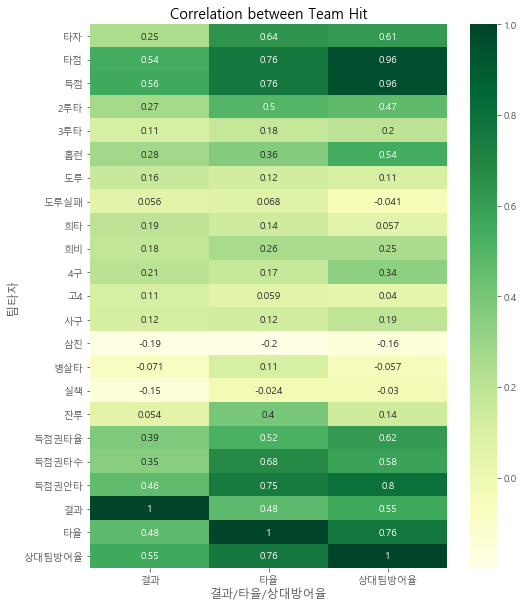

In [7]:
h = hit_tt.iloc[:,6:].drop(['안타','타수'],axis=1).corr()[['결과','타율','상대팀방어율']]
plt.figure(figsize = (8,10))
g = sns.heatmap(h,annot=True, cmap='YlGn')
g.set_title("Correlation between Team Hit")
g.set(xlabel = '결과/타율/상대방어율',ylabel = '팀타자')
# plt.savefig('Team_hit.png')
plt.show()

**결과와 상관관계가 높게 나온 columns**
- 타점, 득점, 타율, 상대팀방어율

<font color='red'>**위의 상관관계가 높은 열들을 이용해 의미있는 피쳐를 생성한다.**</font>

### 팀투수 상관관계

방어율에 직접적 관계가 있는 **'평균자책점', '이닝*3'** column은 제외한다.

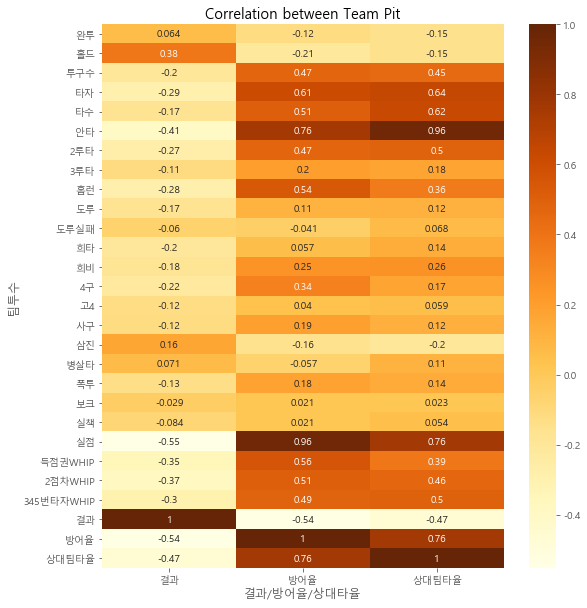

In [8]:
p = pit_tt.iloc[:,6:].drop(['자책점','이닝*3'],axis=1).corr()[['결과','방어율','상대팀타율']]
plt.figure(figsize = (9,10))
g = sns.heatmap(p,annot=True, cmap='YlOrBr')
g.set_title("Correlation between Team Pit")
g.set(xlabel = '결과/방어율/상대타율',ylabel = '팀투수')
# plt.savefig('Team_pit.png')
plt.show()

**결과와 상관관계가 높게 나온 columns**
- 홀드, 안타, 실점, 방어율, 상대팀타율

<font color='red'>**위의 상관관계가 높은 열들을 이용해 의미있는 피쳐를 생성한다.**</font>

### 개인투수(선발투수)별 상대 타율의 변화

In [9]:
pit_pp['일자'] = pit_pp['일자'].apply(lambda x: pd.to_datetime(x,format='%Y%m%d'))
pit_pp['년도'] = pit_pp['일자'].apply(lambda x: str(x.year))

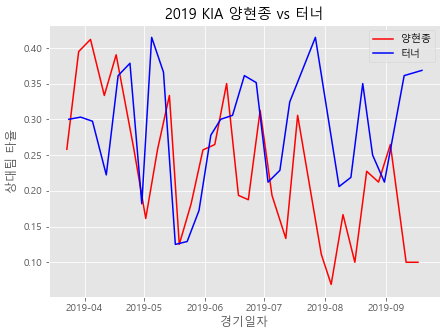

In [10]:
yang = int(player19[player19.NAME == '양현종'].PCODE)
ter = int(player19[player19.NAME == '터너'].PCODE)
didguswhd = pit_pp.query('년도 == "2019" and 선수코드 == @yang')
xjsj = pit_pp.query('년도 == "2019" and 선수코드 == @ter')
vs_avg_2 = hit_tt[['게임키','팀코드','타율']]
vs_avg_2.columns = ['게임키','상대팀코드','상대팀타율']
didguswhd = didguswhd.merge(vs_avg_2,on=['게임키','상대팀코드'])
xjsj = xjsj.merge(vs_avg_2,on=['게임키','상대팀코드'])
plt.figure(figsize = (7,5))
plt.plot(didguswhd[['일자']],didguswhd[['상대팀타율']],color = 'r')
plt.plot(xjsj[['일자']],xjsj[['상대팀타율']],color = 'b')
plt.title('2019 KIA 양현종 vs 터너')
plt.xlabel("경기일자")
plt.ylabel('상대팀 타율')
plt.legend(['양현종','터너'])
#plt.savefig('KIA hit_p.png')
plt.show()

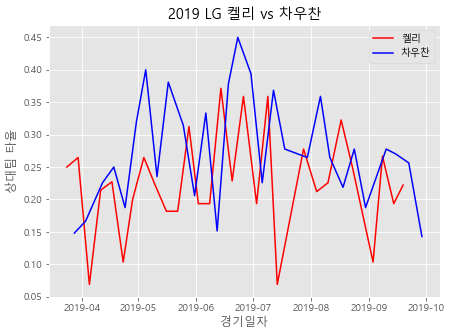

In [11]:
kel = int(player19[player19.NAME == '켈리'].PCODE)
cha = int(player19[player19.NAME == '차우찬'].PCODE)
zpffl = pit_pp.query('년도 == "2019" and 선수코드 == @kel')
ckdncks = pit_pp.query('년도 == "2019" and 선수코드 == @cha')
vs_avg_2 = hit_tt[['게임키','팀코드','타율']]
vs_avg_2.columns = ['게임키','상대팀코드','상대팀타율']
zpffl = zpffl.merge(vs_avg_2,on=['게임키','상대팀코드'])
ckdncks = ckdncks.merge(vs_avg_2,on=['게임키','상대팀코드'])
plt.figure(figsize = (7,5))
plt.plot(zpffl[['일자']],zpffl[['상대팀타율']],color = 'r')
plt.plot(ckdncks[['일자']],ckdncks[['상대팀타율']],color = 'b')
plt.title('2019 LG 켈리 vs 차우찬')
plt.xlabel("경기일자")
plt.ylabel('상대팀 타율')
plt.legend(['켈리','차우찬'])
#plt.savefig('LG hit_p.png')
plt.show()

<font color='red'>**개인 선발투수가 상대팀의 타율에 크게 영향을 미치는 것을 확인할 수 있다.**</font>

## 4. 변수선택 및 학습데이터 구축
## Feature Engineering & Rebuilding Data

2020년도 데이터셋에는 7월 19일까지의 기록만 있기 때문에 <font color='red'>Data Leakage를 방지하기 위하여</font>  
각 년도별 모든 피쳐셋은 2020년 데이터셋 기준 7월 19일까지의 경기수인 320경기만을 이용하여 생성하였다.

## 1) Back Of Words (BOW) Features

### (2016~2020) 보우(Bow) 피쳐셋 생성

**학습(train)에 사용할 2016년~2019년의 데이터와  
예측(test)에 사용할 2020년의 데이터를 통해  
Pivot table을 활용하여 팀별 개인선수들의 다음과 같은 기록을 나타내는 피쳐셋을 생성한다.**

**1) 2루타율 + 3루타율**
- 2루타율 = 2루타 / (2루타 + 3루타)
- 3루타율 = 3루타 / (2루타 + 3루타)

**2) 도루성공률**
- 도루시도 = 도루 / 도루실패
- 도루성공률 = 도루 / 도루시도

**3) 안타**

**4) 삼진**

In [12]:
playerr = pd.concat([player16,player17,player18,player19,player20]).reset_index().iloc[:,1:]
def player_position(x):
    position = playerr[playerr.PCODE==x].POSITION.unique()[0]
    return position

In [13]:
# hit_pp 개인타자 데이터
gamekey = hit_p16.게임키.unique()[:320]
hit_p16_1 = hit_p16.query('게임키 in @gamekey')
hit_p16_1['포지션'] = hit_p16_1.선수코드.apply(player_position)
hit_p16_1['2루타율'] = hit_p16_1['2루타']/(hit_p16_1['2루타']+hit_p16_1['3루타'])
hit_p16_1['3루타율'] = hit_p16_1['3루타']/(hit_p16_1['2루타']+hit_p16_1['3루타'])
hit_p16_1['도루시도'] = hit_p16_1['도루']+hit_p16_1['도루실패']
hit_p16_1['도루성공률'] = hit_p16_1['도루']/hit_p16_1['도루시도']

gamekey = hit_p17.게임키.unique()[:320]
hit_p17_1 = hit_p17.query('게임키 in @gamekey')
hit_p17_1['포지션'] = hit_p17_1.선수코드.apply(player_position)
hit_p17_1['2루타율'] = hit_p17_1['2루타']/(hit_p17_1['2루타']+hit_p17_1['3루타'])
hit_p17_1['3루타율'] = hit_p17_1['3루타']/(hit_p17_1['2루타']+hit_p17_1['3루타'])
hit_p17_1['도루시도'] = hit_p17_1['도루']+hit_p17_1['도루실패']
hit_p17_1['도루성공률'] = hit_p17_1['도루']/hit_p17_1['도루시도']


gamekey = hit_p18.게임키.unique()[:320]
hit_p18_1 = hit_p18.query('게임키 in @gamekey')
hit_p18_1['포지션'] = hit_p18_1.선수코드.apply(player_position)
hit_p18_1['2루타율'] = hit_p18_1['2루타']/(hit_p18_1['2루타']+hit_p18_1['3루타'])
hit_p18_1['3루타율'] = hit_p18_1['3루타']/(hit_p18_1['2루타']+hit_p18_1['3루타'])
hit_p18_1['도루시도'] = hit_p18_1['도루']+hit_p18_1['도루실패']
hit_p18_1['도루성공률'] = hit_p18_1['도루']/hit_p18_1['도루시도']


gamekey = hit_p19.게임키.unique()[:320]
hit_p19_1 = hit_p19.query('게임키 in @gamekey')
hit_p19_1['포지션'] = hit_p19_1.선수코드.apply(player_position)
hit_p19_1['2루타율'] = hit_p19_1['2루타']/(hit_p19_1['2루타']+hit_p19_1['3루타'])
hit_p19_1['3루타율'] = hit_p19_1['3루타']/(hit_p19_1['2루타']+hit_p19_1['3루타'])
hit_p19_1['도루시도'] = hit_p19_1['도루']+hit_p19_1['도루실패']
hit_p19_1['도루성공률'] = hit_p19_1['도루']/hit_p19_1['도루시도']

gamekey = hit_p20.게임키.unique()[:320]
hit_p20_1 = hit_p20.query('게임키 in @gamekey')
hit_p20_1['포지션'] = hit_p20_1.선수코드.apply(player_position)
hit_p20_1['2루타율'] = hit_p20_1['2루타']/(hit_p20_1['2루타']+hit_p20_1['3루타'])
hit_p20_1['3루타율'] = hit_p20_1['3루타']/(hit_p20_1['2루타']+hit_p20_1['3루타'])
hit_p20_1['도루시도'] = hit_p20_1['도루']+hit_p20_1['도루실패']
hit_p20_1['도루성공률'] = hit_p20_1['도루']/hit_p20_1['도루시도']

In [14]:
# pit_pp 개인투수 데이터
gamekey = pit_p16.게임키.unique()[:320]
pit_p16_1 = pit_p16.query('게임키 in @gamekey')
pit_p16_1['포지션'] = pit_p16_1.선수코드.apply(player_position)
pit_p16_1['2루타율'] = pit_p16_1['2루타']/(pit_p16_1['2루타']+pit_p16_1['3루타'])
pit_p16_1['3루타율'] = pit_p16_1['3루타']/(pit_p16_1['2루타']+pit_p16_1['3루타'])
pit_p16_1['도루시도'] = pit_p16_1['도루']+pit_p16_1['도루실패']
pit_p16_1['도루성공률'] = pit_p16_1['도루']/pit_p16_1['도루시도']

gamekey = pit_p17.게임키.unique()[:320]
pit_p17_1 = pit_p17.query('게임키 in @gamekey')
pit_p17_1['포지션'] = pit_p17_1.선수코드.apply(player_position)
pit_p17_1['2루타율'] = pit_p17_1['2루타']/(pit_p17_1['2루타']+pit_p17_1['3루타'])
pit_p17_1['3루타율'] = pit_p17_1['3루타']/(pit_p17_1['2루타']+pit_p17_1['3루타'])
pit_p17_1['도루시도'] = pit_p17_1['도루']+pit_p17_1['도루실패']
pit_p17_1['도루성공률'] = pit_p17_1['도루']/pit_p17_1['도루시도']

gamekey = pit_p18.게임키.unique()[:320]
pit_p18_1 = pit_p18.query('게임키 in @gamekey')
pit_p18_1['포지션'] = pit_p18_1.선수코드.apply(player_position)
pit_p18_1['2루타율'] = pit_p18_1['2루타']/(pit_p18_1['2루타']+pit_p18_1['3루타'])
pit_p18_1['3루타율'] = pit_p18_1['3루타']/(pit_p18_1['2루타']+pit_p18_1['3루타'])
pit_p18_1['도루시도'] = pit_p18_1['도루']+pit_p18_1['도루실패']
pit_p18_1['도루성공률'] = pit_p18_1['도루']/pit_p18_1['도루시도']

gamekey = pit_p19.게임키.unique()[:320]
pit_p19_1 = pit_p19.query('게임키 in @gamekey')
pit_p19_1['포지션'] = pit_p19_1.선수코드.apply(player_position)
pit_p19_1['2루타율'] = pit_p19_1['2루타']/(pit_p19_1['2루타']+pit_p19_1['3루타'])
pit_p19_1['3루타율'] = pit_p19_1['3루타']/(pit_p19_1['2루타']+pit_p19_1['3루타'])
pit_p19_1['도루시도'] = pit_p19_1['도루']+pit_p19_1['도루실패']
pit_p19_1['도루성공률'] = pit_p19_1['도루']/pit_p19_1['도루시도']

gamekey = pit_p20.게임키.unique()[:320]
pit_p20_1 = pit_p20.query('게임키 in @gamekey')
pit_p20_1['포지션'] = pit_p20_1.선수코드.apply(player_position)
pit_p20_1['2루타율'] = pit_p20_1['2루타']/(pit_p20_1['2루타']+pit_p20_1['3루타'])
pit_p20_1['3루타율'] = pit_p20_1['3루타']/(pit_p20_1['2루타']+pit_p20_1['3루타'])
pit_p20_1['도루시도'] = pit_p20_1['도루']+pit_p20_1['도루실패']
pit_p20_1['도루성공률'] = pit_p20_1['도루']/pit_p20_1['도루시도']

안타, 삼진 : 포지션이 **타자**인 선수의 기록만 추출함.

In [15]:
# 2루타율+3루타율
hit_p16_320 = pd.pivot_table(hit_p16_1,index='팀코드',columns='선수코드',values=['2루타율','3루타율'],aggfunc = lambda x:np.mean(x),fill_value = 0).reset_index()
hit_p17_320 = pd.pivot_table(hit_p17_1,index='팀코드',columns='선수코드',values=['2루타율','3루타율'],aggfunc = lambda x:np.mean(x),fill_value = 0).reset_index()
hit_p18_320 = pd.pivot_table(hit_p18_1,index='팀코드',columns='선수코드',values=['2루타율','3루타율'],aggfunc = lambda x:np.mean(x),fill_value = 0).reset_index()
hit_p19_320 = pd.pivot_table(hit_p19_1,index='팀코드',columns='선수코드',values=['2루타율','3루타율'],aggfunc = lambda x:np.mean(x),fill_value = 0).reset_index()
hit_p20_320 = pd.pivot_table(hit_p20_1,index='팀코드',columns='선수코드',values=['2루타율','3루타율'],aggfunc = lambda x:np.mean(x),fill_value = 0).reset_index()

# 도루성공률
hhit_p16_320 = pd.pivot_table(hit_p16_1,index='팀코드',columns='선수코드',values=['도루성공률'],aggfunc = lambda x:np.mean(x),fill_value = 0).reset_index()
hhit_p17_320 = pd.pivot_table(hit_p17_1,index='팀코드',columns='선수코드',values=['도루성공률'],aggfunc = lambda x:np.mean(x),fill_value = 0).reset_index()
hhit_p18_320 = pd.pivot_table(hit_p18_1,index='팀코드',columns='선수코드',values=['도루성공률'],aggfunc = lambda x:np.mean(x),fill_value = 0).reset_index()
hhit_p19_320 = pd.pivot_table(hit_p19_1,index='팀코드',columns='선수코드',values=['도루성공률'],aggfunc = lambda x:np.mean(x),fill_value = 0).reset_index()
hhit_p20_320 = pd.pivot_table(hit_p20_1,index='팀코드',columns='선수코드',values=['도루성공률'],aggfunc = lambda x:np.mean(x),fill_value = 0).reset_index()

#안타
hhhit_p16_320 = pd.pivot_table(hit_p16_1.query('포지션!="투"'),index='팀코드',columns='선수코드',values='안타',aggfunc = lambda x:sum(x),fill_value = 0).reset_index()
hhhit_p17_320 = pd.pivot_table(hit_p17_1.query('포지션!="투"'),index='팀코드',columns='선수코드',values='안타',aggfunc = lambda x:sum(x),fill_value = 0).reset_index()
hhhit_p18_320 = pd.pivot_table(hit_p18_1.query('포지션!="투"'),index='팀코드',columns='선수코드',values='안타',aggfunc = lambda x:sum(x),fill_value = 0).reset_index()
hhhit_p19_320 = pd.pivot_table(hit_p19_1.query('포지션!="투"'),index='팀코드',columns='선수코드',values='안타',aggfunc = lambda x:sum(x),fill_value = 0).reset_index()
hhhit_p20_320 = pd.pivot_table(hit_p20_1.query('포지션!="투"'),index='팀코드',columns='선수코드',values='안타',aggfunc = lambda x:sum(x),fill_value = 0).reset_index()

#삼진
kkhit_p16_320 = pd.pivot_table(hit_p16_1.query('포지션!="투"'),index='팀코드',columns='선수코드',values='삼진',aggfunc = lambda x:sum(x),fill_value = 0).reset_index()
kkhit_p17_320 = pd.pivot_table(hit_p17_1.query('포지션!="투"'),index='팀코드',columns='선수코드',values='삼진',aggfunc = lambda x:sum(x),fill_value = 0).reset_index()
kkhit_p18_320 = pd.pivot_table(hit_p18_1.query('포지션!="투"'),index='팀코드',columns='선수코드',values='삼진',aggfunc = lambda x:sum(x),fill_value = 0).reset_index()
kkhit_p19_320 = pd.pivot_table(hit_p19_1.query('포지션!="투"'),index='팀코드',columns='선수코드',values='삼진',aggfunc = lambda x:sum(x),fill_value = 0).reset_index()
kkhit_p20_320 = pd.pivot_table(hit_p20_1.query('포지션!="투"'),index='팀코드',columns='선수코드',values='삼진',aggfunc = lambda x:sum(x),fill_value = 0).reset_index()

안타, 삼진 : 포지션이 **투수**인 선수의 기록만 추출함.

In [16]:
# 2루타율+3루타율
pit_p16_320 = pd.pivot_table(pit_p16_1,index='팀코드',columns='선수코드',values=['2루타율','3루타율'],aggfunc = lambda x:np.mean(x),fill_value = 0).reset_index()
pit_p17_320 = pd.pivot_table(pit_p17_1,index='팀코드',columns='선수코드',values=['2루타율','3루타율'],aggfunc = lambda x:np.mean(x),fill_value = 0).reset_index()
pit_p18_320 = pd.pivot_table(pit_p18_1,index='팀코드',columns='선수코드',values=['2루타율','3루타율'],aggfunc = lambda x:np.mean(x),fill_value = 0).reset_index()
pit_p19_320 = pd.pivot_table(pit_p19_1,index='팀코드',columns='선수코드',values=['2루타율','3루타율'],aggfunc = lambda x:np.mean(x),fill_value = 0).reset_index()
pit_p20_320 = pd.pivot_table(pit_p20_1,index='팀코드',columns='선수코드',values=['2루타율','3루타율'],aggfunc = lambda x:np.mean(x),fill_value = 0).reset_index()

# 도루성공률
ppit_p16_320 = pd.pivot_table(pit_p16_1,index='팀코드',columns='선수코드',values=['도루성공률'],aggfunc = lambda x:np.mean(x),fill_value = 0).reset_index()
ppit_p17_320 = pd.pivot_table(pit_p17_1,index='팀코드',columns='선수코드',values=['도루성공률'],aggfunc = lambda x:np.mean(x),fill_value = 0).reset_index()
ppit_p18_320 = pd.pivot_table(pit_p18_1,index='팀코드',columns='선수코드',values=['도루성공률'],aggfunc = lambda x:np.mean(x),fill_value = 0).reset_index()
ppit_p19_320 = pd.pivot_table(pit_p19_1,index='팀코드',columns='선수코드',values=['도루성공률'],aggfunc = lambda x:np.mean(x),fill_value = 0).reset_index()
ppit_p20_320 = pd.pivot_table(pit_p20_1,index='팀코드',columns='선수코드',values=['도루성공률'],aggfunc = lambda x:np.mean(x),fill_value = 0).reset_index()

#안타
pppit_p16_320 = pd.pivot_table(pit_p16_1.query('포지션=="투"'),index='팀코드',columns='선수코드',values='안타',aggfunc = lambda x:sum(x),fill_value = 0).reset_index()
pppit_p17_320 = pd.pivot_table(pit_p17_1.query('포지션=="투"'),index='팀코드',columns='선수코드',values='안타',aggfunc = lambda x:sum(x),fill_value = 0).reset_index()
pppit_p18_320 = pd.pivot_table(pit_p18_1.query('포지션=="투"'),index='팀코드',columns='선수코드',values='안타',aggfunc = lambda x:sum(x),fill_value = 0).reset_index()
pppit_p19_320 = pd.pivot_table(pit_p19_1.query('포지션=="투"'),index='팀코드',columns='선수코드',values='안타',aggfunc = lambda x:sum(x),fill_value = 0).reset_index()
pppit_p20_320 = pd.pivot_table(pit_p20_1.query('포지션=="투"'),index='팀코드',columns='선수코드',values='안타',aggfunc = lambda x:sum(x),fill_value = 0).reset_index()

#삼진
kkpit_p16_320 = pd.pivot_table(pit_p16_1.query('포지션=="투"'),index='팀코드',columns='선수코드',values='삼진',aggfunc = lambda x:sum(x),fill_value = 0).reset_index()
kkpit_p17_320 = pd.pivot_table(pit_p17_1.query('포지션=="투"'),index='팀코드',columns='선수코드',values='삼진',aggfunc = lambda x:sum(x),fill_value = 0).reset_index()
kkpit_p18_320 = pd.pivot_table(pit_p18_1.query('포지션=="투"'),index='팀코드',columns='선수코드',values='삼진',aggfunc = lambda x:sum(x),fill_value = 0).reset_index()
kkpit_p19_320 = pd.pivot_table(pit_p19_1.query('포지션=="투"'),index='팀코드',columns='선수코드',values='삼진',aggfunc = lambda x:sum(x),fill_value = 0).reset_index()
kkpit_p20_320 = pd.pivot_table(pit_p20_1.query('포지션=="투"'),index='팀코드',columns='선수코드',values='삼진',aggfunc = lambda x:sum(x),fill_value = 0).reset_index()

In [17]:
# 2루타율+3루타율
p16_320 = hit_p16_320.merge(pit_p16_320,on='팀코드')
p17_320 = hit_p17_320.merge(pit_p17_320,on='팀코드')
p18_320 = hit_p18_320.merge(pit_p18_320,on='팀코드')
p19_320 = hit_p19_320.merge(pit_p19_320,on='팀코드')
p20_320 = hit_p20_320.merge(pit_p20_320,on='팀코드')

# 도루성공률
pp16_320 = hhit_p16_320.merge(ppit_p16_320,on='팀코드')
pp17_320 = hhit_p17_320.merge(ppit_p17_320,on='팀코드')
pp18_320 = hhit_p18_320.merge(ppit_p18_320,on='팀코드')
pp19_320 = hhit_p19_320.merge(ppit_p19_320,on='팀코드')
pp20_320 = hhit_p20_320.merge(ppit_p20_320,on='팀코드')


#안타
hp16_320 = hhhit_p16_320.merge(pppit_p16_320,on='팀코드')
hp17_320 = hhhit_p17_320.merge(pppit_p17_320,on='팀코드')
hp18_320 = hhhit_p18_320.merge(pppit_p18_320,on='팀코드')
hp19_320 = hhhit_p19_320.merge(pppit_p19_320,on='팀코드')
hp20_320 = hhhit_p20_320.merge(pppit_p20_320,on='팀코드')

#삼진
kp16_320 = kkhit_p16_320.merge(kkpit_p16_320,on='팀코드')
kp17_320 = kkhit_p17_320.merge(kkpit_p17_320,on='팀코드')
kp18_320 = kkhit_p18_320.merge(kkpit_p18_320,on='팀코드')
kp19_320 = kkhit_p19_320.merge(kkpit_p19_320,on='팀코드')
kp20_320 = kkhit_p20_320.merge(kkpit_p20_320,on='팀코드')

## 승률예측 데이터셋 생성
### (2016~2019) 미진행 경기 BOW 피쳐 생성

**시즌별 진행 보우(BOW) 피쳐셋의 각 팀코드를 미진행 경기의 팀코드에 매칭하여 팀별로 결합하였다.**  
경기하는 두 팀의 기록을 column 결합하여 <font color='red'>총 1600개의 row</font>로 만들었다.

In [18]:
gamekey = pit_t16.게임키.unique()[:320]
game_p16_400 = pit_t16.query('게임키 not in @gamekey')[['게임키','팀코드','상대팀코드']].reset_index().drop('index',axis=1)
game_p16_400['홈팀'] = game_p16_400.게임키.apply(lambda x: x[8:10])
game_p16_400 = game_p16_400.query('팀코드 == 홈팀')

gamekey = pit_t17.게임키.unique()[:320]
game_p17_400 = pit_t17.query('게임키 not in @gamekey')[['게임키','팀코드','상대팀코드']].reset_index().drop('index',axis=1)
game_p17_400['홈팀'] = game_p17_400.게임키.apply(lambda x: x[8:10])
game_p17_400 = game_p17_400.query('팀코드 == 홈팀')

gamekey = pit_t18.게임키.unique()[:320]
game_p18_400 = pit_t18.query('게임키 not in @gamekey')[['게임키','팀코드','상대팀코드']].reset_index().drop('index',axis=1)
game_p18_400['홈팀'] = game_p18_400.게임키.apply(lambda x: x[8:10])
game_p18_400 = game_p18_400.query('팀코드 == 홈팀')

gamekey = pit_t19.게임키.unique()[:320]
game_p19_400 = pit_t19.query('게임키 not in @gamekey')[['게임키','팀코드','상대팀코드']].reset_index().drop('index',axis=1)
game_p19_400['홈팀'] = game_p19_400.게임키.apply(lambda x: x[8:10])
game_p19_400 = game_p19_400.query('팀코드 == 홈팀')

In [19]:
# 2루타율+3루타율
ggame_p16_400 = game_p16_400.merge(p16_320,on='팀코드')
ggame_p16_400 = ggame_p16_400.merge(p16_320.rename(columns={'팀코드':'상대팀코드'}),on='상대팀코드').drop(['상대팀코드','홈팀'],axis=1)

ggame_p17_400 = game_p17_400.merge(p17_320,on='팀코드')
ggame_p17_400 = ggame_p17_400.merge(p17_320.rename(columns={'팀코드':'상대팀코드'}),on='상대팀코드').drop(['상대팀코드','홈팀'],axis=1)

ggame_p18_400 = game_p18_400.merge(p18_320,on='팀코드')
ggame_p18_400 = ggame_p18_400.merge(p18_320.rename(columns={'팀코드':'상대팀코드'}),on='상대팀코드').drop(['상대팀코드','홈팀'],axis=1)

ggame_p19_400 = game_p19_400.merge(p19_320,on='팀코드')
ggame_p19_400 = ggame_p19_400.merge(p19_320.rename(columns={'팀코드':'상대팀코드'}),on='상대팀코드').drop(['상대팀코드','홈팀'],axis=1)

# 도루성공률
gggame_p16_400 = game_p16_400.merge(pp16_320,on='팀코드')
gggame_p16_400 = gggame_p16_400.merge(pp16_320.rename(columns={'팀코드':'상대팀코드'}),on='상대팀코드').drop(['상대팀코드','홈팀'],axis=1)

gggame_p17_400 = game_p17_400.merge(pp17_320,on='팀코드')
gggame_p17_400 = gggame_p17_400.merge(pp17_320.rename(columns={'팀코드':'상대팀코드'}),on='상대팀코드').drop(['상대팀코드','홈팀'],axis=1)

gggame_p18_400 = game_p18_400.merge(pp18_320,on='팀코드')
gggame_p18_400 = gggame_p18_400.merge(pp18_320.rename(columns={'팀코드':'상대팀코드'}),on='상대팀코드').drop(['상대팀코드','홈팀'],axis=1)

gggame_p19_400 = game_p19_400.merge(pp19_320,on='팀코드')
gggame_p19_400 = gggame_p19_400.merge(pp19_320.rename(columns={'팀코드':'상대팀코드'}),on='상대팀코드').drop(['상대팀코드','홈팀'],axis=1)

#안타
ggggame_p16_400 = game_p16_400.merge(hp16_320,on='팀코드')
ggggame_p16_400 = ggggame_p16_400.merge(hp16_320.rename(columns={'팀코드':'상대팀코드'}),on='상대팀코드').drop(['상대팀코드','홈팀'],axis=1)

ggggame_p17_400 = game_p17_400.merge(hp17_320,on='팀코드')
ggggame_p17_400 = ggggame_p17_400.merge(hp17_320.rename(columns={'팀코드':'상대팀코드'}),on='상대팀코드').drop(['상대팀코드','홈팀'],axis=1)

ggggame_p18_400 = game_p18_400.merge(hp18_320,on='팀코드')
ggggame_p18_400 = ggggame_p18_400.merge(hp18_320.rename(columns={'팀코드':'상대팀코드'}),on='상대팀코드').drop(['상대팀코드','홈팀'],axis=1)

ggggame_p19_400 = game_p19_400.merge(hp19_320,on='팀코드')
ggggame_p19_400 = ggggame_p19_400.merge(hp19_320.rename(columns={'팀코드':'상대팀코드'}),on='상대팀코드').drop(['상대팀코드','홈팀'],axis=1)

#삼진
gggggame_p16_400 = game_p16_400.merge(kp16_320,on='팀코드')
gggggame_p16_400 = gggggame_p16_400.merge(kp16_320.rename(columns={'팀코드':'상대팀코드'}),on='상대팀코드').drop(['상대팀코드','홈팀'],axis=1)

gggggame_p17_400 = game_p17_400.merge(kp17_320,on='팀코드')
gggggame_p17_400 = gggggame_p17_400.merge(kp17_320.rename(columns={'팀코드':'상대팀코드'}),on='상대팀코드').drop(['상대팀코드','홈팀'],axis=1)

gggggame_p18_400 = game_p18_400.merge(kp18_320,on='팀코드')
gggggame_p18_400 = gggggame_p18_400.merge(kp18_320.rename(columns={'팀코드':'상대팀코드'}),on='상대팀코드').drop(['상대팀코드','홈팀'],axis=1)

gggggame_p19_400 = game_p19_400.merge(kp19_320,on='팀코드')
gggggame_p19_400 = gggggame_p19_400.merge(kp19_320.rename(columns={'팀코드':'상대팀코드'}),on='상대팀코드').drop(['상대팀코드','홈팀'],axis=1)

In [20]:
ggame_400 = pd.concat([ggame_p16_400,ggame_p17_400,ggame_p18_400,ggame_p19_400]).reset_index().drop('index',axis=1).fillna(0)
gggame_400 = pd.concat([gggame_p16_400,gggame_p17_400,gggame_p18_400,gggame_p19_400]).reset_index().drop('index',axis=1).fillna(0)
ggggame_400 = pd.concat([ggggame_p16_400,ggggame_p17_400,ggggame_p18_400,ggggame_p19_400]).reset_index().drop('index',axis=1).fillna(0)
gggggame_400 = pd.concat([gggggame_p16_400,gggggame_p17_400,gggggame_p18_400,gggggame_p19_400]).reset_index().drop('index',axis=1).fillna(0)

**경기결과 y값 생성**

In [21]:
WL = pit_tt.groupby(['게임키','팀코드'])['결과'].agg([('WL',lambda x : x)]).reset_index()
ggame_400 = ggame_400.merge(WL,on=['게임키','팀코드'])
gggame_400 = gggame_400.merge(WL,on=['게임키','팀코드'])
ggggame_400 = ggggame_400.merge(WL,on=['게임키','팀코드'])
gggggame_400 = gggggame_400.merge(WL,on=['게임키','팀코드'])

**데이터 정제**
- 이상치를 제거한다
- 왼쪽으로 치우진 분포를 정규분포로 바꾸기 위해 로그 변환을 수행한다.
- 특성 차원이 너무 많을 경우 과적합이 발생하기 때문에 차원 축소를 실행한다.
- 분산의 설명량이 99%이상이 되는 차원의 수를 뽑아 PCA를 진행한다.

In [22]:
train_test1 = ggame_400.drop(['게임키','WL'],axis=1)
train_test2 = gggame_400.drop(['게임키','WL'],axis=1)
train_test3 = ggggame_400.drop(['게임키','WL'],axis=1)
train_test4 = gggggame_400.drop(['게임키','WL'],axis=1)

In [23]:
# 이상치(outlier)를 제거한다.
train_test1.iloc[:,1:] = train_test1.iloc[:,1:].apply(lambda x: x.clip(x.quantile(.05), x.quantile(.95)), axis=0)

# 왼쪽으로 치우진 분포를 정규분포로 바꾸기 위해 로그 변환을 수행한다.
train_test1.iloc[:,1:] = np.log1p(train_test1.iloc[:,1:])

# 특성 차원이 너무 많을 경우 과적합이 발생하기 때문에 차원 축소를 실행한다.
max_d = num_d = train_test1.shape[1] - 1
pca = PCA(n_components=1600, random_state=0).fit(train_test1.iloc[:,1:])
cumsum = np.cumsum(pca.explained_variance_ratio_) #분산의 설명량을 누적합
num_d = np.argmax(cumsum >= 0.99) + 1             # 분산의 설명량이 99%이상 되는 차원의 수
if num_d == 1: num_d = max_d
pca = PCA(n_components=num_d, random_state=0).fit_transform(train_test1.iloc[:,1:])
train_test1 = pd.concat([train_test1.iloc[:,0], pd.DataFrame(pca)], axis=1)

In [24]:
# 이상치(outlier)를 제거한다.
train_test2.iloc[:,1:] = train_test2.iloc[:,1:].apply(lambda x: x.clip(x.quantile(.05), x.quantile(.95)), axis=0)

# 왼쪽으로 치우진 분포를 정규분포로 바꾸기 위해 로그 변환을 수행한다.
train_test2.iloc[:,1:] = np.log1p(train_test2.iloc[:,1:])

# 특성 차원이 너무 많을 경우 과적합이 발생하기 때문에 차원 축소를 실행한다.
max_d = num_d = train_test2.shape[1] - 1
pca = PCA(n_components=1138, random_state=0).fit(train_test2.iloc[:,1:])
cumsum = np.cumsum(pca.explained_variance_ratio_) #분산의 설명량을 누적합
num_d = np.argmax(cumsum >= 0.99) + 1             # 분산의 설명량이 99%이상 되는 차원의 수
if num_d == 1: num_d = max_d
pca = PCA(n_components=num_d, random_state=0).fit_transform(train_test2.iloc[:,1:])
train_test2 = pd.concat([train_test2.iloc[:,0], pd.DataFrame(pca)], axis=1)

In [25]:
train_test3.iloc[:,1:] = train_test3.iloc[:,1:].apply(lambda x: x.clip(x.quantile(.05), x.quantile(.95)), axis=0)

train_test3.iloc[:,1:] = np.log1p(train_test3.iloc[:,1:])

max_d = num_d = train_test3.shape[1] - 1
pca = PCA(n_components=max_d, random_state=0).fit(train_test3.iloc[:,1:])
cumsum = np.cumsum(pca.explained_variance_ratio_) 
num_d = np.argmax(cumsum >= 0.99) + 1             
if num_d == 1: num_d = max_d
pca = PCA(n_components=num_d, random_state=0).fit_transform(train_test3.iloc[:,1:])
train_test3 = pd.concat([train_test3.iloc[:,0], pd.DataFrame(pca)], axis=1)

In [26]:
train_test4.iloc[:,1:] = train_test4.iloc[:,1:].apply(lambda x: x.clip(x.quantile(.05), x.quantile(.95)), axis=0)

train_test4.iloc[:,1:] = np.log1p(train_test4.iloc[:,1:])

max_d = num_d = train_test4.shape[1] - 1
pca = PCA(n_components=max_d, random_state=0).fit(train_test4.iloc[:,1:])
cumsum = np.cumsum(pca.explained_variance_ratio_) 
num_d = np.argmax(cumsum >= 0.99) + 1             
if num_d == 1: num_d = max_d
pca = PCA(n_components=num_d, random_state=0).fit_transform(train_test4.iloc[:,1:])
train_test4 = pd.concat([train_test4.iloc[:,0], pd.DataFrame(pca)], axis=1)

**Kmeans**
- Kmeans 알고리즘을 이용하여 설명률이 높은 피쳐를 군집화하여 생성한다.

In [27]:
class KMeansFeaturizer:


    def __init__(self, k=100, target_scale=5, random_state=None):
        self.k = k
        self.target_scale = target_scale
        self.random_state = random_state
        self.cluster_encoder = OneHotEncoder().fit(np.array(range(k)).reshape(-1,1))
        
    def fit(self, X, y=None):
        if y is None:
            km_model = KMeans(n_clusters=self.k, n_init=20, random_state=self.random_state)
            km_model.fit(X)
            self.km_model_ = km_model
            self.cluster_centers_ = km_model.cluster_centers_
            return self
       
        data_with_target = np.hstack((X, y[:,np.newaxis]*self.target_scale))

        km_model_pretrain = KMeans(n_clusters=self.k, n_init=20, random_state=self.random_state)
        km_model_pretrain.fit(data_with_target)
        km_model = KMeans(n_clusters=self.k, 
                          init=km_model_pretrain.cluster_centers_[:,:data_with_target.shape[1]-1], 
                          n_init=1, max_iter=1)
        km_model.fit(X)
        
        self.km_model = km_model
        self.cluster_centers_ = km_model.cluster_centers_
        return self
        
    def transform(self, X, y=None):
        clusters = self.km_model.predict(X)
        onehot = self.cluster_encoder.transform(clusters.reshape(-1,1)).toarray()
        max_col = onehot.shape[1]
        pca = PCA(n_components=max_col, random_state=0).fit(onehot)
        cumsum = np.cumsum(pca.explained_variance_ratio_)
        num_col = np.argmax(cumsum >= 0.99) + 1
        if num_col == 1: num_col = max_col
        pca = PCA(n_components = num_col, random_state=0).fit_transform(onehot)
        return pd.DataFrame(pca)
    
    def fit_transform(self, X, y=None):
        self.fit(X, y)
        return self.transform(X, y)

In [28]:
ttrain_x = train_test1.iloc[:,1:]
tttrain_x = train_test2.iloc[:,1:]
ttttrain_x = train_test3.iloc[:,1:]
tttttrain_x = train_test4.iloc[:,1:]

In [29]:
# Perform k-means clustering
kmf_hint = KMeansFeaturizer(k=5, target_scale=5, random_state=0).fit(ttrain_x, ggame_400.WL)

# Generate k-means clustering features
training_cluster_features = kmf_hint.transform(ttrain_x)

# Augment existing features with the k-means clustering features
ttrain_x = pd.concat([ttrain_x, training_cluster_features], axis=1)
ttrain_x.columns = range( ttrain_x.shape[1])

In [30]:
# Perform k-means clustering
kmf_hint = KMeansFeaturizer(k=5, target_scale=5, random_state=0).fit(tttrain_x, gggame_400.WL)

# Generate k-means clustering features
training_cluster_features = kmf_hint.transform(tttrain_x)

# Augment existing features with the k-means clustering features
tttrain_x = pd.concat([tttrain_x, training_cluster_features], axis=1)
tttrain_x.columns = range(tttrain_x.shape[1])

In [31]:
# Perform k-means clustering
kmf_hint = KMeansFeaturizer(k=5, target_scale=5, random_state=0).fit(ttttrain_x, ggggame_400.WL)

# Generate k-means clustering features
training_cluster_features = kmf_hint.transform(ttttrain_x)

# Augment existing features with the k-means clustering features
ttttrain_x = pd.concat([ttttrain_x, training_cluster_features], axis=1)
ttttrain_x.columns = range(ttttrain_x.shape[1])

In [32]:
# Perform k-means clustering
kmf_hint = KMeansFeaturizer(k=5, target_scale=5, random_state=0).fit(tttttrain_x, gggggame_400.WL)

# Generate k-means clustering features
training_cluster_features = kmf_hint.transform(tttttrain_x)

# Augment existing features with the k-means clustering features
tttttrain_x = pd.concat([tttttrain_x, training_cluster_features], axis=1)
tttttrain_x.columns = range( tttttrain_x.shape[1])

In [33]:
# 승률bow피쳐 column명 변경

# 선수코드별 2루타율+3루타율
ttrain_x.columns = ttrain_x.columns.astype(str)
ttrain_x.columns = '이루삼루타율_' + ttrain_x.columns

# 선수코드별 도루성공률
tttrain_x.columns = tttrain_x.columns.astype(str)
tttrain_x.columns = '도루성공률_' + tttrain_x.columns

# 선수코드별 안타
ttttrain_x.columns = ttttrain_x.columns.astype(str)
ttttrain_x.columns = '안타_' + ttttrain_x.columns

# 선수코드별 삼진
tttttrain_x.columns = tttttrain_x.columns.astype(str)
tttttrain_x.columns = '삼진_' + tttttrain_x.columns

In [34]:
bow_wl = pd.concat([ggame_400.loc[:,['게임키','팀코드']], ttrain_x, tttrain_x, ttttrain_x, tttttrain_x, ggame_400.loc[:,'WL']],axis=1)
# bow_wl.to_csv('features/bowwl.csv',encoding='cp949',index=False)
bow_wl

,게임키,팀코드,이루삼루타율_0,이루삼루타율_1,이루삼루타율_2,이루삼루타율_3,이루삼루타율_4,이루삼루타율_5,이루삼루타율_6,이루삼루타율_7,...,삼진_59,삼진_60,삼진_61,삼진_62,삼진_63,삼진_64,삼진_65,삼진_66,삼진_67,WL
0,20160619WOHH0,WO,2.709928,-0.108878,-0.641543,-0.913352,-0.309802,0.024614,0.207212,-0.647192,...,0.336402,-0.308898,0.289314,0.016777,-0.184393,-0.156669,0.311875,0.677272,-0.681922,1
1,20160824WOHH0,WO,2.709928,-0.108878,-0.641543,-0.913352,-0.309802,0.024614,0.207212,-0.647192,...,0.336402,-0.308898,0.289314,0.016777,-0.184393,-0.156669,0.311875,0.677272,-0.681922,1
2,20161002WOHH0,WO,2.709928,-0.108878,-0.641543,-0.913352,-0.309802,0.024614,0.207212,-0.647192,...,0.336402,-0.308898,0.289314,0.016777,-0.184393,-0.156669,0.311875,0.677272,-0.681922,1
3,20160719KTHH0,KT,2.860669,0.096450,-0.705928,-0.398442,-0.656635,-0.052974,-0.061856,-0.739828,...,-0.062040,-0.262493,0.445977,-0.380268,0.007326,-0.156669,0.311875,0.677272,-0.681922,0
4,20160720KTHH0,KT,2.860669,0.096450,-0.705928,-0.398442,-0.656635,-0.052974,-0.061856,-0.739828,...,-0.062040,-0.262493,0.445977,-0.380268,0.007326,-0.156669,0.311875,0.677272,-0.681922,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1595,20190703NCHT0,NC,0.140448,-0.812716,2.189156,-0.001974,-0.324447,0.064356,0.100299,-0.722761,...,0.541676,1.678388,0.615844,0.540129,-1.486946,-0.220048,0.814294,-0.459800,-0.010635,1
1596,20190704NCHT0,NC,0.140448,-0.812716,2.189156,-0.001974,-0.324447,0.064356,0.100299,-0.722761,...,0.541676,1.678388,0.615844,0.540129,-1.486946,-0.220048,0.814294,-0.459800,-0.010635,1
1597,20190803NCHT0,NC,0.140448,-0.812716,2.189156,-0.001974,-0.324447,0.064356,0.100299,-0.722761,...,0.541676,1.678388,0.615844,0.540129,-1.486946,-0.220048,0.814294,-0.459800,-0.010635,0
1598,20190804NCHT0,NC,0.140448,-0.812716,2.189156,-0.001974,-0.324447,0.064356,0.100299,-0.722761,...,0.541676,1.678388,0.615844,0.540129,-1.486946,-0.220048,0.814294,-0.459800,-0.010635,0


<font color='blue'> **결과 : bow_wl** </font>

### (2020) 미진행 경기 BOW 피쳐 생성

**최종테스트용 데이터셋을 생성하기 위해 2020년 잔여경기들의 정보를 담은 데이터셋을 생성한다.**

In [35]:
T=[]
VT=[]
BT=[]
d=[]
for i in range(len(game2020)):
    T.append(game2020.iloc[i,3])
    T.append(game2020.iloc[i,2])
    VT.append(game2020.iloc[i,2])
    VT.append(game2020.iloc[i,3])
    d.append(game2020.iloc[i,0])
    d.append(game2020.iloc[i,0])
for j in range(len(game2020)):
    BT.append('B')
    BT.append('T')

game2020=pd.DataFrame({'날짜':d,'팀코드':T,'상대팀코드':VT,'초말':BT})
#test20.to_csv('Datasets/game20.csv',index=False,encoding='cp949')

**추후의 피쳐 생성에 필요한 2020년 잔여 경기들의 예상 선발 로테이션 정보를 추가한다.**

In [36]:
#선발투수 로테이션
SKs=['문승원','이건욱','핀토','조영우','박종훈']*6
LGs=['윌슨','이민호','임찬규','정찬헌','켈리']*6
KTs=['쿠에바스','소형준','데스파이네','배제성','김민수']*6
LTs=['샘슨','박세웅','노경은','서준원','스트레일리']*6
SSs=['김대우','라이블리','최채흥','뷰캐넌','원태인']*6
NCs=['루친스키','김영규','송명기','라이트','이재학']*6
WOs=['브리검','요키시','최원태','이승호','한현희']*6
HTs=['임기영','가뇽','김기훈','이민우','양현종']*6
OBs=['최원준','유희관','알칸타라','플렉센','함덕주']*6
HHs=['김진욱','서폴드','김이환','김민우','장시환']*6

In [37]:
for i in game2020['팀코드'].unique():
    a=game2020.query('팀코드==@i')
    a['선발투수']=globals()['{}s'.format(i)][:len(a)]
    if i =='WO':
        game202020=a
    else: 
        game202020=pd.concat([game202020,a],axis=0)
        
game202020=game202020.reset_index().sort_values(by='index').reset_index(drop=True)

pc=[]
for i in range(len(game202020)):
    x=game202020['선발투수'][i]
    t=game202020['팀코드'][i]
    pc.append(int(player20.query('NAME==@x & T_ID==@t')['PCODE']))
game202020['선수코드']=pc;#game202020

In [38]:
f20_400 = game202020
f20_400['Index'] = range(0,258)

def home(x):
    team = f20_400.팀코드[x]
    vsteam = f20_400.상대팀코드[x]
    cho = f20_400.초말[x]
    if cho == 'B':
        return team
    else:
        return vsteam

def away(x):
    team = f20_400.팀코드[x]
    vsteam = f20_400.상대팀코드[x]
    cho = f20_400.초말[x]
    if cho == 'B':
        return vsteam
    else:
        return team

f20_400['홈팀'] = f20_400.Index.apply(home)
f20_400['원정팀'] = f20_400.Index.apply(away)
f20_400 = f20_400.drop(['Index'],axis=1)

f20_400['년'] = f20_400['날짜'].apply(lambda x : str(pd.to_datetime('2020/'+x,format = '%Y/%m/%d'))[:4])
f20_400['월'] = f20_400['날짜'].apply(lambda x : str(pd.to_datetime('2020/'+x,format = '%Y/%m/%d'))[5:7])
f20_400['일'] = f20_400['날짜'].apply(lambda x : str(pd.to_datetime('2020/'+x,format = '%Y/%m/%d'))[8:10])

f20_400['게임키'] = f20_400['년'] + f20_400['월'] + f20_400['일'] + f20_400['홈팀'] + f20_400['원정팀']
f20_400 = f20_400[['게임키','팀코드','상대팀코드','초말']]

In [39]:
#더블헤더 게임키 재설정
for i in range(2,len(f20_400.게임키)):
    if f20_400.게임키[i]==f20_400.게임키[i-2]:
        f20_400['게임키'][i-2]=str(f20_400['게임키'][i-2])+'1'
    else: 
        f20_400['게임키'][i-2]=str(f20_400['게임키'][i-2])+'0'

In [40]:
f20_400_wl = f20_400.query('초말 == "B"')
f20_400_avgera = f20_400.drop(['상대팀코드','초말'],axis=1)

In [41]:
# 2루타율+3루타율
ggame_p20_400 = f20_400_wl.merge(p20_320,on='팀코드')
ggame_p20_400 = ggame_p20_400.merge(p20_320.rename(columns={'팀코드':'상대팀코드'}),on='상대팀코드').drop(['상대팀코드','초말'],axis=1)

# 도루성공률
gggame_p20_400 = f20_400_wl.merge(pp20_320,on='팀코드')
gggame_p20_400 = gggame_p20_400.merge(pp20_320.rename(columns={'팀코드':'상대팀코드'}),on='상대팀코드').drop(['상대팀코드','초말'],axis=1)

#안타
ggggame_p20_400 = f20_400_wl.merge(hp20_320,on='팀코드')
ggggame_p20_400 = ggggame_p20_400.merge(hp20_320.rename(columns={'팀코드':'상대팀코드'}),on='상대팀코드').drop(['상대팀코드','초말'],axis=1)

#삼진
gggggame_p20_400 = f20_400_wl.merge(kp20_320,on='팀코드')
gggggame_p20_400 = gggggame_p20_400.merge(kp20_320.rename(columns={'팀코드':'상대팀코드'}),on='상대팀코드').drop(['상대팀코드','초말'],axis=1)

**데이터 정제**
- 이상치를 제거한다
- 왼쪽으로 치우진 분포를 정규분포로 바꾸기 위해 로그 변환을 수행한다.
- 특성 차원이 너무 많을 경우 과적합이 발생하기 때문에 차원 축소를 실행한다.
- 분산의 설명량이 99%이상이 되는 차원의 수를 뽑아 PCA를 진행한다.

In [42]:
train_test1 = ggame_p20_400.drop(['게임키'],axis=1)
train_test2 = gggame_p20_400.drop(['게임키'],axis=1)
train_test3 = ggggame_p20_400.drop(['게임키'],axis=1)
train_test4 = gggggame_p20_400.drop(['게임키'],axis=1)

In [43]:
# 이상치(outlier)를 제거한다.
train_test1.iloc[:,1:] = train_test1.iloc[:,1:].apply(lambda x: x.clip(x.quantile(.05), x.quantile(.95)), axis=0)

# 왼쪽으로 치우진 분포를 정규분포로 바꾸기 위해 로그 변환을 수행한다.
train_test1.iloc[:,1:] = np.log1p(train_test1.iloc[:,1:])

# 특성 차원이 너무 많을 경우 과적합이 발생하기 때문에 차원 축소를 실행한다.
max_d = num_d = train_test1.shape[0] - 1
pca = PCA(n_components=max_d, random_state=0).fit(train_test1.iloc[:,1:])
cumsum = np.cumsum(pca.explained_variance_ratio_) #분산의 설명량을 누적합
num_d = np.argmax(cumsum >= 0.99) + 1             # 분산의 설명량이 99%이상 되는 차원의 수
if num_d == 1: num_d = max_d
pca = PCA(n_components=num_d, random_state=0).fit_transform(train_test1.iloc[:,1:])
train_test1 = pd.concat([train_test1.iloc[:,0], pd.DataFrame(pca)], axis=1)

In [44]:
# 이상치(outlier)를 제거한다.
train_test2.iloc[:,1:] = train_test2.iloc[:,1:].apply(lambda x: x.clip(x.quantile(.05), x.quantile(.95)), axis=0)

# 왼쪽으로 치우진 분포를 정규분포로 바꾸기 위해 로그 변환을 수행한다.
train_test2.iloc[:,1:] = np.log1p(train_test2.iloc[:,1:])

# 특성 차원이 너무 많을 경우 과적합이 발생하기 때문에 차원 축소를 실행한다.
max_d = num_d = train_test2.shape[0] - 1
pca = PCA(n_components=max_d, random_state=0).fit(train_test2.iloc[:,1:])
cumsum = np.cumsum(pca.explained_variance_ratio_) #분산의 설명량을 누적합
num_d = np.argmax(cumsum >= 0.99) + 1             # 분산의 설명량이 99%이상 되는 차원의 수
if num_d == 1: num_d = max_d
pca = PCA(n_components=num_d, random_state=0).fit_transform(train_test2.iloc[:,1:])
train_test2 = pd.concat([train_test2.iloc[:,0], pd.DataFrame(pca)], axis=1)

In [45]:
# 이상치(outlier)를 제거한다.
train_test3.iloc[:,1:] = train_test3.iloc[:,1:].apply(lambda x: x.clip(x.quantile(.05), x.quantile(.95)), axis=0)

# 왼쪽으로 치우진 분포를 정규분포로 바꾸기 위해 로그 변환을 수행한다.
train_test3.iloc[:,1:] = np.log1p(train_test3.iloc[:,1:])

# 특성 차원이 너무 많을 경우 과적합이 발생하기 때문에 차원 축소를 실행한다.
max_d = num_d = train_test3.shape[0] - 1
pca = PCA(n_components=max_d, random_state=0).fit(train_test3.iloc[:,1:])
cumsum = np.cumsum(pca.explained_variance_ratio_) #분산의 설명량을 누적합
num_d = np.argmax(cumsum >= 0.99) + 1             # 분산의 설명량이 99%이상 되는 차원의 수
if num_d == 1: num_d = max_d
pca = PCA(n_components=num_d, random_state=0).fit_transform(train_test3.iloc[:,1:])
train_test3 = pd.concat([train_test3.iloc[:,0], pd.DataFrame(pca)], axis=1)

In [46]:
# 이상치(outlier)를 제거한다.
train_test4.iloc[:,1:] = train_test4.iloc[:,1:].apply(lambda x: x.clip(x.quantile(.05), x.quantile(.95)), axis=0)

# 왼쪽으로 치우진 분포를 정규분포로 바꾸기 위해 로그 변환을 수행한다.
train_test4.iloc[:,1:] = np.log1p(train_test4.iloc[:,1:])

# 특성 차원이 너무 많을 경우 과적합이 발생하기 때문에 차원 축소를 실행한다.
max_d = num_d = train_test4.shape[0] - 1
pca = PCA(n_components=max_d, random_state=0).fit(train_test4.iloc[:,1:])
cumsum = np.cumsum(pca.explained_variance_ratio_) #분산의 설명량을 누적합
num_d = np.argmax(cumsum >= 0.99) + 1             # 분산의 설명량이 99%이상 되는 차원의 수
if num_d == 1: num_d = max_d
pca = PCA(n_components=num_d, random_state=0).fit_transform(train_test4.iloc[:,1:])
train_test4 = pd.concat([train_test4.iloc[:,0], pd.DataFrame(pca)], axis=1)

In [47]:
ttrain_x = train_test1.iloc[:,1:]
tttrain_x = train_test2.iloc[:,1:]
ttttrain_x = train_test3.iloc[:,1:]
tttttrain_x = train_test4.iloc[:,1:]

In [48]:
# 승률bow피쳐 column명 변경

# 선수코드별 2루타율+3루타율
ttrain_x.columns = ttrain_x.columns.astype(str)
ttrain_x.columns = '이루삼루타율_' + ttrain_x.columns

# 선수코드별 도루성공률
tttrain_x.columns = tttrain_x.columns.astype(str)
tttrain_x.columns = '도루성공률_' + tttrain_x.columns

# 선수코드별 안타
ttttrain_x.columns = ttttrain_x.columns.astype(str)
ttttrain_x.columns = '안타_' + ttttrain_x.columns

# 선수코드별 삼진
tttttrain_x.columns = tttttrain_x.columns.astype(str)
tttttrain_x.columns = '삼진_' + tttttrain_x.columns

In [49]:
bow_wl_20 = pd.concat([ggame_p20_400.loc[:,['게임키','팀코드']], ttrain_x, tttrain_x, ttttrain_x, tttttrain_x],axis=1)
bow_wl_20

,게임키,팀코드,이루삼루타율_0,이루삼루타율_1,이루삼루타율_2,이루삼루타율_3,이루삼루타율_4,이루삼루타율_5,이루삼루타율_6,이루삼루타율_7,...,삼진_8,삼진_9,삼진_10,삼진_11,삼진_12,삼진_13,삼진_14,삼진_15,삼진_16,삼진_17
0,20200929WOHT0,WO,0.161739,0.702029,-1.761025,2.906417,-0.736226,0.534430,2.594067,0.483735,...,2.755238,-5.570609,-3.543573,2.501392,-1.674719,7.631548,-6.510515,-6.672428,-4.705348,2.240342
1,20200930WOHT0,WO,0.161739,0.702029,-1.761025,2.906417,-0.736226,0.534430,2.594067,0.483735,...,2.755238,-5.570609,-3.543573,2.501392,-1.674719,7.631548,-6.510515,-6.672428,-4.705348,2.240342
2,20201001WOHT0,WO,0.161739,0.702029,-1.761025,2.906417,-0.736226,0.534430,2.594067,0.483735,...,2.755238,-5.570609,-3.543573,2.501392,-1.674719,7.631548,-6.510515,-6.672428,-4.705348,2.240342
3,20201016LGHT0,LG,0.344790,2.099243,-2.151189,2.505478,-1.288835,0.535127,-0.319970,-0.585149,...,0.431820,-5.500646,-7.704104,-12.005076,2.106409,-1.449019,-0.158856,-2.671522,1.994362,-1.135115
4,20201017LGHT0,LG,0.344790,2.099243,-2.151189,2.505478,-1.288835,0.535127,-0.319970,-0.585149,...,0.431820,-5.500646,-7.704104,-12.005076,2.106409,-1.449019,-0.158856,-2.671522,1.994362,-1.135115
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,20201003KTLG0,KT,-0.365528,-1.616310,-1.269965,0.113477,4.234116,-0.992103,-0.809691,-1.462235,...,-2.906000,-3.009131,-5.918249,0.504712,-2.912562,3.372074,5.853157,-1.926548,-1.212127,1.488005
125,20201004KTLG0,KT,-0.365528,-1.616310,-1.269965,0.113477,4.234116,-0.992103,-0.809691,-1.462235,...,-2.906000,-3.009131,-5.918249,0.504712,-2.912562,3.372074,5.853157,-1.926548,-1.212127,1.488005
126,20200723KTLG0,KT,-0.365528,-1.616310,-1.269965,0.113477,4.234116,-0.992103,-0.809691,-1.462235,...,-2.906000,-3.009131,-5.918249,0.504712,-2.912562,3.372074,5.853157,-1.926548,-1.212127,1.488005
127,20200902SKLG0,SK,-0.871642,-2.168430,-1.283125,-1.383150,0.902163,0.373075,-1.100104,0.087674,...,9.190002,-5.753206,2.583447,-4.486657,-4.501543,10.916284,10.628634,-1.551938,-2.016383,-4.073177


<font color='blue'> **결과 : bow_wl_20** </font>

## 타율/ 방어율 예측 데이터셋 생성
### (2016~2019) 미진행 경기 BOW 피쳐 생성

**시즌별 진행 보우(BOW) 피쳐셋의 각 팀코드를 미진행 경기의 팀코드에 매칭하여 팀별로 결합하였다.**  
경기하는 두 팀의 기록을 row 결합하여 <font color='red'>총 3200개의 row</font>로 만들었다.

In [50]:
gamekey = pit_t16.게임키.unique()[:320]
game_p16_400_1 = pit_t16.query('게임키 not in @gamekey')[['게임키','팀코드']].reset_index().drop('index',axis=1)

gamekey = pit_t17.게임키.unique()[:320]
game_p17_400_1 = pit_t17.query('게임키 not in @gamekey')[['게임키','팀코드']].reset_index().drop('index',axis=1)

gamekey = pit_t18.게임키.unique()[:320]
game_p18_400_1 = pit_t18.query('게임키 not in @gamekey')[['게임키','팀코드']].reset_index().drop('index',axis=1)

gamekey = pit_t19.게임키.unique()[:320]
game_p19_400_1 = pit_t19.query('게임키 not in @gamekey')[['게임키','팀코드']].reset_index().drop('index',axis=1)

In [51]:
# 2루타율+3루타율
ggame_p16_400 = game_p16_400_1.merge(p16_320,on='팀코드')
ggame_p17_400 = game_p17_400_1.merge(p17_320,on='팀코드')
ggame_p18_400 = game_p18_400_1.merge(p18_320,on='팀코드')
ggame_p19_400 = game_p19_400_1.merge(p19_320,on='팀코드')

# 도루성공률
gggame_p16_400 = game_p16_400_1.merge(pp16_320,on='팀코드')
gggame_p17_400 = game_p17_400_1.merge(pp17_320,on='팀코드')
gggame_p18_400 = game_p18_400_1.merge(pp18_320,on='팀코드')
gggame_p19_400 = game_p19_400_1.merge(pp19_320,on='팀코드')

#안타
ggggame_p16_400 = game_p16_400_1.merge(hp16_320,on='팀코드')
ggggame_p17_400 = game_p17_400_1.merge(hp17_320,on='팀코드')
ggggame_p18_400 = game_p18_400_1.merge(hp18_320,on='팀코드')
ggggame_p19_400 = game_p19_400_1.merge(hp19_320,on='팀코드')

#삼진
gggggame_p16_400 = game_p16_400_1.merge(kp16_320,on='팀코드')
gggggame_p17_400 = game_p17_400_1.merge(kp17_320,on='팀코드')
gggggame_p18_400 = game_p18_400_1.merge(kp18_320,on='팀코드')
gggggame_p19_400 = game_p19_400_1.merge(kp19_320,on='팀코드')

In [52]:
ggame_400 = pd.concat([ggame_p16_400,ggame_p17_400,ggame_p18_400,ggame_p19_400]).reset_index().drop('index',axis=1).fillna(0)
gggame_400 = pd.concat([gggame_p16_400,gggame_p17_400,gggame_p18_400,gggame_p19_400]).reset_index().drop('index',axis=1).fillna(0)
ggggame_400 = pd.concat([ggggame_p16_400,ggggame_p17_400,ggggame_p18_400,ggggame_p19_400]).reset_index().drop('index',axis=1).fillna(0)
gggggame_400 = pd.concat([gggggame_p16_400,gggggame_p17_400,gggggame_p18_400,gggggame_p19_400]).reset_index().drop('index',axis=1).fillna(0)

**데이터 정제**
- 이상치를 제거한다
- 왼쪽으로 치우진 분포를 정규분포로 바꾸기 위해 로그 변환을 수행한다.
- 특성 차원이 너무 많을 경우 과적합이 발생하기 때문에 차원 축소를 실행한다.
- 분산의 설명량이 99%이상이 되는 차원의 수를 뽑아 PCA를 진행한다.

In [53]:
train_test1 = ggame_400.drop('게임키',axis=1)
train_test2 = gggame_400.drop('게임키',axis=1)
train_test3 = ggggame_400.drop('게임키',axis=1)
train_test4 = gggggame_400.drop('게임키',axis=1)

In [54]:
# 이상치(outlier)를 제거한다.
train_test1.iloc[:,1:] = train_test1.iloc[:,1:].apply(lambda x: x.clip(x.quantile(.05), x.quantile(.95)), axis=0)

# 왼쪽으로 치우진 분포를 정규분포로 바꾸기 위해 로그 변환을 수행한다.
train_test1.iloc[:,1:] = np.log1p(train_test1.iloc[:,1:])

# 특성 차원이 너무 많을 경우 과적합이 발생하기 때문에 차원 축소를 실행한다.
max_d = num_d = train_test1.shape[1] - 1
pca = PCA(n_components=max_d, random_state=0).fit(train_test1.iloc[:,1:])
cumsum = np.cumsum(pca.explained_variance_ratio_) #분산의 설명량을 누적합
num_d = np.argmax(cumsum >= 0.99) + 1             # 분산의 설명량이 99%이상 되는 차원의 수
if num_d == 1: num_d = max_d
pca = PCA(n_components=num_d, random_state=0).fit_transform(train_test1.iloc[:,1:])
train_test1 = pd.concat([train_test1.iloc[:,0], pd.DataFrame(pca)], axis=1)

In [55]:
# 이상치(outlier)를 제거한다.
train_test2.iloc[:,1:] = train_test2.iloc[:,1:].apply(lambda x: x.clip(x.quantile(.05), x.quantile(.95)), axis=0)

# 왼쪽으로 치우진 분포를 정규분포로 바꾸기 위해 로그 변환을 수행한다.
train_test2.iloc[:,1:] = np.log1p(train_test2.iloc[:,1:])

# 특성 차원이 너무 많을 경우 과적합이 발생하기 때문에 차원 축소를 실행한다.
max_d = num_d = train_test2.shape[1] - 1
pca = PCA(n_components=max_d, random_state=0).fit(train_test2.iloc[:,1:])
cumsum = np.cumsum(pca.explained_variance_ratio_) #분산의 설명량을 누적합
num_d = np.argmax(cumsum >= 0.99) + 1             # 분산의 설명량이 99%이상 되는 차원의 수
if num_d == 1: num_d = max_d
pca = PCA(n_components=num_d, random_state=0).fit_transform(train_test2.iloc[:,1:])
train_test2 = pd.concat([train_test2.iloc[:,0], pd.DataFrame(pca)], axis=1)

In [56]:
# 이상치(outlier)를 제거한다.
train_test3.iloc[:,1:] = train_test3.iloc[:,1:].apply(lambda x: x.clip(x.quantile(.05), x.quantile(.95)), axis=0)

# 왼쪽으로 치우진 분포를 정규분포로 바꾸기 위해 로그 변환을 수행한다.
train_test3.iloc[:,1:] = np.log1p(train_test3.iloc[:,1:])

# 특성 차원이 너무 많을 경우 과적합이 발생하기 때문에 차원 축소를 실행한다.
max_d = num_d = train_test3.shape[1] - 1
pca = PCA(n_components=max_d, random_state=0).fit(train_test3.iloc[:,1:])
cumsum = np.cumsum(pca.explained_variance_ratio_) #분산의 설명량을 누적합
num_d = np.argmax(cumsum >= 0.99) + 1             # 분산의 설명량이 99%이상 되는 차원의 수
if num_d == 1: num_d = max_d
pca = PCA(n_components=num_d, random_state=0).fit_transform(train_test3.iloc[:,1:])
train_test3 = pd.concat([train_test3.iloc[:,0], pd.DataFrame(pca)], axis=1)

In [57]:
# 이상치(outlier)를 제거한다.
train_test4.iloc[:,1:] = train_test4.iloc[:,1:].apply(lambda x: x.clip(x.quantile(.05), x.quantile(.95)), axis=0)

# 왼쪽으로 치우진 분포를 정규분포로 바꾸기 위해 로그 변환을 수행한다.
train_test4.iloc[:,1:] = np.log1p(train_test4.iloc[:,1:])

# 특성 차원이 너무 많을 경우 과적합이 발생하기 때문에 차원 축소를 실행한다.
max_d = num_d = train_test4.shape[1] - 1
pca = PCA(n_components=max_d, random_state=0).fit(train_test4.iloc[:,1:])
cumsum = np.cumsum(pca.explained_variance_ratio_) #분산의 설명량을 누적합
num_d = np.argmax(cumsum >= 0.99) + 1             # 분산의 설명량이 99%이상 되는 차원의 수
if num_d == 1: num_d = max_d
pca = PCA(n_components=num_d, random_state=0).fit_transform(train_test4.iloc[:,1:])
train_test4 = pd.concat([train_test4.iloc[:,0], pd.DataFrame(pca)], axis=1)

In [58]:
ttrain_x = train_test1.iloc[:,1:]
tttrain_x = train_test2.iloc[:,1:]
ttttrain_x = train_test3.iloc[:,1:]
tttttrain_x = train_test4.iloc[:,1:]

In [59]:
# 승률bow피쳐 column명 변경

# 선수코드별 2루타율+3루타율
ttrain_x.columns = ttrain_x.columns.astype(str)
ttrain_x.columns = '이루삼루타율_' + ttrain_x.columns

# 선수코드별 도루성공률
tttrain_x.columns = tttrain_x.columns.astype(str)
tttrain_x.columns = '도루성공률_' + tttrain_x.columns

# 선수코드별 안타
ttttrain_x.columns = ttttrain_x.columns.astype(str)
ttttrain_x.columns = '안타_' + ttttrain_x.columns

# 선수코드별 삼진
tttttrain_x.columns = tttttrain_x.columns.astype(str)
tttttrain_x.columns = '삼진_' + tttttrain_x.columns

In [60]:
bow_avgera = pd.concat([ggame_400.loc[:,['게임키','팀코드']], ttrain_x, tttrain_x, ttttrain_x, tttttrain_x],axis=1)
# bow_avgera.to_csv('features/bow_avgera.csv',encoding='cp949',index=False)
bow_avgera

,게임키,팀코드,이루삼루타율_0,이루삼루타율_1,이루삼루타율_2,이루삼루타율_3,이루삼루타율_4,이루삼루타율_5,이루삼루타율_6,이루삼루타율_7,...,삼진_24,삼진_25,삼진_26,삼진_27,삼진_28,삼진_29,삼진_30,삼진_31,삼진_32,삼진_33
0,20160619WOHH0,HH,2.969593,0.042357,0.002978,0.042376,-0.058793,-0.185816,-0.032002,-0.048296,...,-0.380906,0.119495,0.019453,0.435137,0.472158,-0.105784,0.115839,0.871671,1.909102,-0.174992
1,20160621HHNC0,HH,2.969593,0.042357,0.002978,0.042376,-0.058793,-0.185816,-0.032002,-0.048296,...,-0.380906,0.119495,0.019453,0.435137,0.472158,-0.105784,0.115839,0.871671,1.909102,-0.174992
2,20160623HHNC0,HH,2.969593,0.042357,0.002978,0.042376,-0.058793,-0.185816,-0.032002,-0.048296,...,-0.380906,0.119495,0.019453,0.435137,0.472158,-0.105784,0.115839,0.871671,1.909102,-0.174992
3,20160624LTHH0,HH,2.969593,0.042357,0.002978,0.042376,-0.058793,-0.185816,-0.032002,-0.048296,...,-0.380906,0.119495,0.019453,0.435137,0.472158,-0.105784,0.115839,0.871671,1.909102,-0.174992
4,20160625LTHH0,HH,2.969593,0.042357,0.002978,0.042376,-0.058793,-0.185816,-0.032002,-0.048296,...,-0.380906,0.119495,0.019453,0.435137,0.472158,-0.105784,0.115839,0.871671,1.909102,-0.174992
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3195,20190917WOHH0,WO,-0.229300,-0.016491,0.123620,-0.175577,0.156233,-0.090002,0.411469,0.992179,...,1.254187,1.090394,-1.667292,-1.233256,0.019174,-0.880081,-0.144462,0.501984,-0.291577,-0.289323
3196,20190920WOSK0,WO,-0.229300,-0.016491,0.123620,-0.175577,0.156233,-0.090002,0.411469,0.992179,...,1.254187,1.090394,-1.667292,-1.233256,0.019174,-0.880081,-0.144462,0.501984,-0.291577,-0.289323
3197,20190924WOHT0,WO,-0.229300,-0.016491,0.123620,-0.175577,0.156233,-0.090002,0.411469,0.992179,...,1.254187,1.090394,-1.667292,-1.233256,0.019174,-0.880081,-0.144462,0.501984,-0.291577,-0.289323
3198,20190929WOLT0,WO,-0.229300,-0.016491,0.123620,-0.175577,0.156233,-0.090002,0.411469,0.992179,...,1.254187,1.090394,-1.667292,-1.233256,0.019174,-0.880081,-0.144462,0.501984,-0.291577,-0.289323


<font color='blue'> **결과 : bow_avgera** </font>

### (2020) 미진행 경기 BOW 피쳐 생성

In [61]:
# 2루타율+3루타율
ggame_p20_400 = f20_400_avgera.merge(p20_320,on='팀코드')

# 도루성공률
gggame_p20_400 = f20_400_avgera.merge(pp20_320,on='팀코드')

#안타
ggggame_p20_400 = f20_400_avgera.merge(hp20_320,on='팀코드')

#삼진
gggggame_p20_400 = f20_400_avgera.merge(kp20_320,on='팀코드')

**데이터 정제**
- 이상치를 제거한다
- 왼쪽으로 치우진 분포를 정규분포로 바꾸기 위해 로그 변환을 수행한다.
- 특성 차원이 너무 많을 경우 과적합이 발생하기 때문에 차원 축소를 실행한다.
- 분산의 설명량이 99%이상이 되는 차원의 수를 뽑아 PCA를 진행한다.

In [62]:
train_test1 = ggame_p20_400.drop(['게임키'],axis=1)
train_test2 = gggame_p20_400.drop(['게임키'],axis=1)
train_test3 = ggggame_p20_400.drop(['게임키'],axis=1)
train_test4 = gggggame_p20_400.drop(['게임키'],axis=1)

In [63]:
# 이상치(outlier)를 제거한다.
train_test1.iloc[:,1:] = train_test1.iloc[:,1:].apply(lambda x: x.clip(x.quantile(.05), x.quantile(.95)), axis=0)

# 왼쪽으로 치우진 분포를 정규분포로 바꾸기 위해 로그 변환을 수행한다.
train_test1.iloc[:,1:] = np.log1p(train_test1.iloc[:,1:])

# 특성 차원이 너무 많을 경우 과적합이 발생하기 때문에 차원 축소를 실행한다.
max_d = num_d = train_test1.shape[0] - 1
pca = PCA(n_components=max_d, random_state=0).fit(train_test1.iloc[:,1:])
cumsum = np.cumsum(pca.explained_variance_ratio_) #분산의 설명량을 누적합
num_d = np.argmax(cumsum >= 0.99) + 1             # 분산의 설명량이 99%이상 되는 차원의 수
if num_d == 1: num_d = max_d
pca = PCA(n_components=num_d, random_state=0).fit_transform(train_test1.iloc[:,1:])
train_test1 = pd.concat([train_test1.iloc[:,0], pd.DataFrame(pca)], axis=1)

In [64]:
# 이상치(outlier)를 제거한다.
train_test2.iloc[:,1:] = train_test2.iloc[:,1:].apply(lambda x: x.clip(x.quantile(.05), x.quantile(.95)), axis=0)

# 왼쪽으로 치우진 분포를 정규분포로 바꾸기 위해 로그 변환을 수행한다.
train_test2.iloc[:,1:] = np.log1p(train_test2.iloc[:,1:])

# 특성 차원이 너무 많을 경우 과적합이 발생하기 때문에 차원 축소를 실행한다.
max_d = num_d = train_test2.shape[0] - 1
pca = PCA(n_components=max_d, random_state=0).fit(train_test2.iloc[:,1:])
cumsum = np.cumsum(pca.explained_variance_ratio_) #분산의 설명량을 누적합
num_d = np.argmax(cumsum >= 0.99) + 1             # 분산의 설명량이 99%이상 되는 차원의 수
if num_d == 1: num_d = max_d
pca = PCA(n_components=num_d, random_state=0).fit_transform(train_test2.iloc[:,1:])
train_test2 = pd.concat([train_test2.iloc[:,0], pd.DataFrame(pca)], axis=1)

In [65]:
# 이상치(outlier)를 제거한다.
train_test3.iloc[:,1:] = train_test3.iloc[:,1:].apply(lambda x: x.clip(x.quantile(.05), x.quantile(.95)), axis=0)

# 왼쪽으로 치우진 분포를 정규분포로 바꾸기 위해 로그 변환을 수행한다.
train_test3.iloc[:,1:] = np.log1p(train_test3.iloc[:,1:])

# 특성 차원이 너무 많을 경우 과적합이 발생하기 때문에 차원 축소를 실행한다.
max_d = num_d = train_test3.shape[0] - 1
pca = PCA(n_components=max_d, random_state=0).fit(train_test3.iloc[:,1:])
cumsum = np.cumsum(pca.explained_variance_ratio_) #분산의 설명량을 누적합
num_d = np.argmax(cumsum >= 0.99) + 1             # 분산의 설명량이 99%이상 되는 차원의 수
if num_d == 1: num_d = max_d
pca = PCA(n_components=num_d, random_state=0).fit_transform(train_test3.iloc[:,1:])
train_test3 = pd.concat([train_test3.iloc[:,0], pd.DataFrame(pca)], axis=1)

In [66]:
# 이상치(outlier)를 제거한다.
train_test4.iloc[:,1:] = train_test4.iloc[:,1:].apply(lambda x: x.clip(x.quantile(.05), x.quantile(.95)), axis=0)

# 왼쪽으로 치우진 분포를 정규분포로 바꾸기 위해 로그 변환을 수행한다.
train_test4.iloc[:,1:] = np.log1p(train_test4.iloc[:,1:])

# 특성 차원이 너무 많을 경우 과적합이 발생하기 때문에 차원 축소를 실행한다.
max_d = num_d = train_test4.shape[0] - 1
pca = PCA(n_components=max_d, random_state=0).fit(train_test4.iloc[:,1:])
cumsum = np.cumsum(pca.explained_variance_ratio_) #분산의 설명량을 누적합
num_d = np.argmax(cumsum >= 0.99) + 1             # 분산의 설명량이 99%이상 되는 차원의 수
if num_d == 1: num_d = max_d
pca = PCA(n_components=num_d, random_state=0).fit_transform(train_test4.iloc[:,1:])
train_test4 = pd.concat([train_test4.iloc[:,0], pd.DataFrame(pca)], axis=1)

In [67]:
ttrain_x = train_test1.iloc[:,1:]
tttrain_x = train_test2.iloc[:,1:]
ttttrain_x = train_test3.iloc[:,1:]
tttttrain_x = train_test4.iloc[:,1:]

In [68]:
# 승률bow피쳐 column명 변경

# 선수코드별 2루타율+3루타율
ttrain_x.columns = ttrain_x.columns.astype(str)
ttrain_x.columns = '이루삼루타율_' + ttrain_x.columns

# 선수코드별 도루성공률
tttrain_x.columns = tttrain_x.columns.astype(str)
tttrain_x.columns = '도루성공률_' + tttrain_x.columns

# 선수코드별 안타
ttttrain_x.columns = ttttrain_x.columns.astype(str)
ttttrain_x.columns = '안타_' + ttttrain_x.columns

# 선수코드별 삼진
tttttrain_x.columns = tttttrain_x.columns.astype(str)
tttttrain_x.columns = '삼진_' + tttttrain_x.columns

In [69]:
bow_avgera_20 = pd.concat([ggame_p20_400.loc[:,['게임키','팀코드']], ttrain_x, tttrain_x, ttttrain_x, tttttrain_x],axis=1)
bow_avgera_20

,게임키,팀코드,이루삼루타율_0,이루삼루타율_1,이루삼루타율_2,이루삼루타율_3,이루삼루타율_4,이루삼루타율_5,이루삼루타율_6,이루삼루타율_7,...,안타_8,삼진_0,삼진_1,삼진_2,삼진_3,삼진_4,삼진_5,삼진_6,삼진_7,삼진_8
0,20200929WOHT0,WO,-0.231448,-0.265988,-0.079405,-0.125998,-0.114097,0.209865,0.015432,0.066080,...,20.126636,-1.145646,-0.743618,-0.711285,-0.273901,-0.405892,0.115452,1.584111,2.330829,18.235285
1,20200930WOHT0,WO,-0.231448,-0.265988,-0.079405,-0.125998,-0.114097,0.209865,0.015432,0.066080,...,20.126636,-1.145646,-0.743618,-0.711285,-0.273901,-0.405892,0.115452,1.584111,2.330829,18.235285
2,20201001WOHT0,WO,-0.231448,-0.265988,-0.079405,-0.125998,-0.114097,0.209865,0.015432,0.066080,...,20.126636,-1.145646,-0.743618,-0.711285,-0.273901,-0.405892,0.115452,1.584111,2.330829,18.235285
3,20201002SKWO0,WO,-0.231448,-0.265988,-0.079405,-0.125998,-0.114097,0.209865,0.015432,0.066080,...,20.126636,-1.145646,-0.743618,-0.711285,-0.273901,-0.405892,0.115452,1.584111,2.330829,18.235285
4,20201003SKWO0,WO,-0.231448,-0.265988,-0.079405,-0.125998,-0.114097,0.209865,0.015432,0.066080,...,20.126636,-1.145646,-0.743618,-0.711285,-0.273901,-0.405892,0.115452,1.584111,2.330829,18.235285
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253,20200722SKLT0,SK,0.309246,-0.623050,-0.549332,-2.651030,2.861564,-0.949728,-0.042356,-0.160371,...,-2.264469,0.753032,-2.500602,-6.635164,16.083208,4.484639,-0.752024,-2.650797,-2.072508,-1.096303
254,20200723SKLT0,SK,0.309246,-0.623050,-0.549332,-2.651030,2.861564,-0.949728,-0.042356,-0.160371,...,-2.264469,0.753032,-2.500602,-6.635164,16.083208,4.484639,-0.752024,-2.650797,-2.072508,-1.096303
255,20200805SKLT0,SK,0.309246,-0.623050,-0.549332,-2.651030,2.861564,-0.949728,-0.042356,-0.160371,...,-2.264469,0.753032,-2.500602,-6.635164,16.083208,4.484639,-0.752024,-2.650797,-2.072508,-1.096303
256,20200810SKSS0,SK,0.309246,-0.623050,-0.549332,-2.651030,2.861564,-0.949728,-0.042356,-0.160371,...,-2.264469,0.753032,-2.500602,-6.635164,16.083208,4.484639,-0.752024,-2.650797,-2.072508,-1.096303


<font color='blue'> **결과 : bow_avgera_20** </font>

## 2) Sabermetrics Features


- 야구에 사회과학의 게임 이론과 통계학적 방법론을 적극 도입하여 기존 야구 기록의 부실한 부분을 보완하고, 선수의 가치를 비롯한 '야구의 본질'에 대해 좀더 학문적이고 깊이있는 접근을 시도하는 방법론.  
- 기존 주먹구구식 선수 평가론을 전면 부정하고, 야구선수에 대해 좀 더 객관적인 평가를 하기 위해 창안된 이론  

출처 : <a> https://namu.wiki/w/%EC%84%B8%EC%9D%B4%EB%B2%84%EB%A9%94%ED%8A%B8%EB%A6%AD%EC%8A%A4 </a> 나무위키(세이버메트릭스)

### 타자용 피쳐
**1) 1루타**
- 안타-2루타-3루타-홈런

**2) 타율**
- 안타/타수

**3) 득점권 타율**
- 득점권안타/득점권타수

**4) 장타율**
- 1* 1루타 +2* 2루타 + 3* 3루타 + 4* 홈런

**5) 출루율**
- (안타+4구+사구+고4)/타자


**6) 도루성공률**
- 도루/(도루+도루실패)

### 타자용 세이버메트릭스(SaberMetrics) 피쳐

**1) OPS**
- 장타율+출루율  

**2) wOBA**
- (0.691* 4구+0.722* 사구+0.884* 1루타+1.257* 2루타+1.593* 3루타+2.058* 홈런)/(타자-고4)

**3) RawEqA**
- 1루타+안타+1.5*(4구+사구+도루+희타+희비-고4/2)(타자+희타+희비)

**4) BBK** 
- 4구/삼진

**5) A**
- 안타+사구-도루실패+사구-병살타

**6) B**
- 0.24* (4구-고4+사구)+0.62* 도루+0.5(희비+희타-삼진)

**7) RC**
- ((2.4* 타자+A)* (3* 타자+B)/(9* 타자))-(0.9* 타자)

**8) IsoP**
- 장타율-타율

**9) IsoD**
- 출루율-타율

**10) XR**
- 0.5* 1루타+0.72* 2루타+1.04* 3루타+1.44* 홈런+0.34* (4구+사구-고4)+0.25* 고4+0.18* 도루-0.32* 도루실패-0.09* (타수-안타-삼진)-0.098* 삼진-0.37* 병살타+0.37* 희비+0.04* 희타

**11) GPA**
- (1.8* 출루율+장타율)/4

**12) BABIP**
- (안타-홈런)/(타수-삼진-홈런+희비)

### 투수용 피쳐
**1) 1루타**
- 안타-2루타-3루타-홈런

**2) 장타율**
- 1* 1루타 +2* 2루타 + 3* 3루타 + 4* 홈런

**3) 출루율**
- (안타+4구+사구+고4)/타자

**4) 방어율**
- (자책점/이닝* 3)* 27

**5) 도루저지율**
- 도루실패/(도루+도루실패)

**6) 이닝당투구수** 
- (투구수/이닝* 3 /3)

### 투수용 세이버메트릭스(Sabermetrics) 피쳐
**1) OPS**
- 장타율+출루율

**2) BABIP**
- (안타-홈런)/(타수-삼진-홈런+희비)

**3) WHIP**
- ((안타+4구)/이닝* 3)* 3

**4) C**
- (9* 자책점-13* 홈런-3* (4구+사구-고4)+2* 삼진)/(이닝* 3 /3)

**5) K/BB**
- 삼진/4구

**6) RA9**
- (실점/이닝* 3)* 27

**7) pFIP**
- (17.5* 홈런+7* 4구-9* 삼진)/(타자+C)

**8) kwERA**
- 5.40-12* (삼진-4구)/타자

## (팀별) 개인타자 피쳐셋 생성

**Pivot_table을 활용하여 팀의 타순별로 평균 성적을 나타내는 피쳐셋을 생성하였다.**

In [70]:
hitter=['타자','타수','타점','득점','안타','2루타','3루타','홈런',
        '도루','도루실패','희타','희비','4구','고4','사구',
        '삼진','병살타','실책','잔루','득점권타수','득점권안타']

for j,k in zip([hit_p16,hit_p17,hit_p18,hit_p19,hit_p20],range(16,21)):
    for i in hitter:
        globals()['h'+'{}'.format(k)]=pd.pivot_table(data=j,columns='타순',index='팀코드',values=i,aggfunc=np.sum).reset_index()
        globals()['h'+'{}'.format(k)].columns=['팀코드',i+'1',i+'2',i+'3',i+'4',i+'5',i+'6',i+'7',i+'8',i+'9']
        globals()['h'+'{}'.format(k)][i+'std']=globals()['h'+'{}'.format(k)].std(axis=1)
        if i!='타자':
            globals()['hnum'+'{}'.format(k)]=pd.merge(globals()['hnum'+'{}'.format(k)],globals()['h'+'{}'.format(k)],on='팀코드')
        if i=='타자':
            globals()['hnum'+'{}'.format(k)]=globals()['h'+'{}'.format(k)]

**개인타자 피쳐셋에 세이버메트릭스 공식을 적용하였다.**

In [71]:
for pivs in [hnum16,hnum17,hnum18,hnum19,hnum20]:
    for i in range(1,10):
        i=str(i)
        pivs['1루타'+i]=pivs['안타'+i]-pivs['2루타'+i]-pivs['3루타'+i]-pivs['홈런'+i]
        pivs['타율'+i]=pivs['안타'+i]/pivs['타수'+i]
        pivs['득점권타율'+i]=pivs['득점권안타'+i]/pivs['득점권타수'+i]
        pivs['장타율'+i]=(pivs['1루타'+i]+2*pivs['2루타'+i]+3*pivs['3루타'+i]+4*pivs['홈런'+i])/pivs['타수'+i]
        pivs['출루율'+i]=(pivs['안타'+i]+pivs['4구'+i]+pivs['사구'+i]+pivs['고4'+i])/pivs['타자'+i]
        pivs['OPS'+i]=pivs['장타율'+i]+pivs['출루율'+i]
        pivs['wOBA'+i]=(0.691*pivs['4구'+i]+0.722*pivs['사구'+i]+0.884*pivs['1루타'+i]+1.257*pivs['2루타'+i]+1.593*pivs['3루타'+i]+2.058*pivs['홈런'+i])/(pivs['타자'+i]-pivs['고4'+i])
        pivs['RawEqA'+i]=(pivs['1루타'+i]+pivs['안타'+i]+1.5*(pivs['4구'+i]+pivs['사구'+i]+pivs['도루'+i])+pivs['희비'+i]+pivs['희타'+i]-pivs['고4'+i]/2)/(pivs['타자'+i]+pivs['희타'+i]+pivs['희비'+i])
        pivs['BBK'+i]=pivs['4구'+i]/pivs['삼진'+i]
        pivs['A'+i]=pivs['안타'+i]+pivs['4구'+i]-pivs['도루실패'+i]+pivs['사구'+i]-pivs['병살타'+i]
        pivs['B'+i]=0.24*(pivs['4구'+i]-pivs['고4'+i]+pivs['사구'+i])+0.62*pivs['도루'+i]+0.5*(pivs['희비'+i]+pivs['희타'+i])-0.03*pivs['삼진'+i]
        pivs['RC'+i]=((2.4*pivs['타자'+i]+pivs['A'+i])*(3*pivs['타자'+i]+pivs['B'+i])/(9*pivs['타자'+i]))-(0.9*pivs['타자'+i])
        pivs['IsoP'+i]=pivs['장타율'+i]-pivs['타율'+i]
        pivs['IsoD'+i]=pivs['출루율'+i]-pivs['타율'+i]
        pivs['XR'+i]=0.5*pivs['1루타'+i]+0.72*pivs['2루타'+i]+1.04*pivs['3루타'+i]+1.44*pivs['홈런'+i]+0.34*(pivs['4구'+i]+pivs['사구'+i]-pivs['고4'+i])+pivs['고4'+i]*0.25+pivs['도루'+i]*0.32-pivs['도루실패'+i]*0.32-(pivs['타수'+i]-pivs['안타'+i]-pivs['삼진'+i])*0.09-pivs['삼진'+i]*0.098-pivs['병살타'+i]*0.37+pivs['희비'+i]*0.37+pivs['희타'+i]*0.04
        pivs['GPA'+i]=(pivs['출루율'+i]*1.8+pivs['장타율'+i])/4
        pivs['BABIP'+i]=(pivs['안타'+i]-pivs['홈런'+i])/(pivs['타수'+i]-pivs['삼진'+i]-pivs['홈런'+i]+pivs['희비'+i])
        pivs['도루성공률'+i]=pivs['도루'+i]/(pivs['도루'+i]+pivs['도루실패'+i])

## (팀별)개인투수 피쳐셋 생성

**Pivot_table을 활용하여 팀의 구원투수와 선발투수별로 평균 성적을 나타내는 피쳐셋을 생성하였다.**

In [72]:
pitcher=['이닝*3','투구수','타자','타수','안타',
        '2루타','3루타','홈런','도루','도루실패','희타','희비',
        '4구','고4','사구','삼진','병살타','폭투','보크','실점','자책점','득점권WHIP','2점차WHIP','345번타자WHIP']

for j,k in zip([pit_p16,pit_p17,pit_p18,pit_p19,pit_p20],range(16,21)):
    for i in pitcher:
        globals()['p'+'{}'.format(k)]=pd.pivot_table(data=j,columns='선발',index='팀코드',values=i,aggfunc=np.sum).reset_index()
        globals()['p'+'{}'.format(k)].columns=['팀코드','팀구원'+i,'팀선발'+i]
        globals()['p'+'{}'.format(k)][i+'std']=globals()['p'+'{}'.format(k)].std(axis=1)
        if i!='이닝*3':
            globals()['pnum'+'{}'.format(k)]=pd.merge(globals()['pnum'+'{}'.format(k)],globals()['p'+'{}'.format(k)],on='팀코드')
        if i=='이닝*3':
            globals()['pnum'+'{}'.format(k)]=globals()['p'+'{}'.format(k)]

**개인투수 피쳐셋에 세이버메트릭스 공식을 적용하였다.**

In [73]:
for pnum in [pnum16,pnum17,pnum18,pnum19,pnum20]:
    for i in ['팀구원','팀선발']:
        i=str(i)
        pnum[i+'1루타']=pnum[i+'안타']-pnum[i+'2루타']-pnum[i+'3루타']-pnum[i+'홈런']
        pnum[i+'장타율']=(pnum[i+'1루타']+2*pnum[i+'2루타']+3*pnum[i+'3루타']+4*pnum[i+'홈런'])/pnum[i+'타수']
        pnum[i+'출루율']=(pnum[i+'안타']+pnum[i+'4구']+pnum[i+'사구']+pnum[i+'고4'])/pnum[i+'타자']
        pnum[i+'OPS']=pnum[i+'장타율']+pnum[i+'출루율']
        pnum[i+'BABIP']=(pnum[i+'안타']-pnum[i+'홈런'])/(pnum[i+'타수']-pnum[i+'삼진']-pnum[i+'홈런']+pnum[i+'희비'])
        pnum[i+'방어율']=pnum[i+'자책점']/pnum[i+'이닝*3']*27
        pnum[i+'WHIP']=(pnum[i+'안타']+pnum[i+'4구'])/pnum[i+'이닝*3']*3
        pnum[i+'C']=(9*pnum[i+'자책점']-13*pnum[i+'홈런']-3*(pnum[i+'4구']+pnum[i+'사구']-pnum[i+'고4'])+2*pnum[i+'삼진'])/(pnum[i+'이닝*3']/3)
        pnum[i+'FIP']=((-2*pnum[i+'삼진']+3*(pnum[i+'4구']+pnum[i+'사구'])+13*pnum[i+'홈런'])/(pnum[i+'이닝*3']/3))+pnum[i+'C']
        pnum[i+'K/BB']=pnum[i+'삼진']/pnum[i+'4구']
        pnum[i+'RA9']=pnum[i+'실점']/pnum[i+'이닝*3']*27
        pnum[i+'pFIP']=(17.5*pnum[i+'홈런']+7*pnum[i+'4구']-9*pnum[i+'삼진'])/pnum[i+'타자']+pnum[i+'C']
        pnum[i+'kwERA']=5.40-12*(pnum[i+'삼진']-pnum[i+'4구'])/pnum[i+'타자']
        pnum[i+'이닝당투구수']=pnum[i+'투구수']/(pnum[i+'이닝*3']/3)
        pnum[i+'도루저지율']=pnum[i+'도루실패']/(pnum[i+'도루']+pnum[i+'도루실패'])

## 팀타자 피쳐셋 생성

**팀타자 데이터셋에 팀별로 그룹바이를 적용하여 팀타자 피쳐셋을 생성하였다.**

In [74]:
for j in range(16,21):
    globals()['hit'+'{}'.format(j)]=globals()['hit_t'+'{}'.format(j)].groupby('팀코드')['타자','타수','타점','득점','안타','2루타','3루타','홈런',
                       '도루','도루실패','희타','희비','4구','고4','사구',
                       '삼진','병살타','실책','잔루','득점권타수','득점권안타'].agg(np.sum).reset_index()

**팀타자 피쳐셋에 세이버메트릭스 공식을 적용하였다.**

In [75]:
for hitt in [hit16,hit17,hit18,hit19,hit20]:
    hitt['1루타' ]=hitt['안타' ]-hitt['2루타' ]-hitt['3루타' ]-hitt['홈런' ]
    hitt['타율' ]=hitt['안타' ]/hitt['타수' ]
    hitt['득점권타율' ]=hitt['득점권안타' ]/hitt['득점권타수' ]
    hitt['장타율' ]=(hitt['1루타' ]+2*hitt['2루타' ]+3*hitt['3루타' ]+4*hitt['홈런' ])/hitt['타수' ]
    hitt['출루율' ]=(hitt['안타' ]+hitt['4구' ]+hitt['사구' ]+hitt['고4' ])/hitt['타자' ]
    hitt['OPS' ]=hitt['장타율' ]+hitt['출루율' ]
    hitt['wOBA' ]=(0.691*hitt['4구' ]+0.722*hitt['사구' ]+0.884*hitt['1루타' ]+1.257*hitt['2루타' ]+1.593*hitt['3루타' ]+2.058*hitt['홈런' ])/(hitt['타자' ]-hitt['고4' ])
    hitt['RawEqA' ]=(hitt['1루타' ]+hitt['안타' ]+1.5*(hitt['4구' ]+hitt['사구' ]+hitt['도루' ])+hitt['희비' ]+hitt['희타' ]-hitt['고4' ]/2)/(hitt['타자' ]+hitt['희타' ]+hitt['희비' ])
    hitt['BBK' ]=hitt['4구' ]/hitt['삼진' ]
    hitt['A' ]=hitt['안타' ]+hitt['4구' ]-hitt['도루실패' ]+hitt['사구' ]-hitt['병살타' ]
    hitt['B' ]=0.24*(hitt['4구' ]-hitt['고4' ]+hitt['사구' ])+0.62*hitt['도루' ]+0.5*(hitt['희비' ]+hitt['희타' ])-0.03*hitt['삼진' ]
    hitt['RC' ]=((2.4*hitt['타자' ]+hitt['A' ])*(3*hitt['타자' ]+hitt['B' ])/(9*hitt['타자' ]))-(0.9*hitt['타자' ])
    hitt['IsoP' ]=hitt['장타율' ]-hitt['타율' ]
    hitt['IsoD' ]=hitt['출루율' ]-hitt['타율' ]
    hitt['XR' ]=0.5*hitt['1루타' ]+0.72*hitt['2루타' ]+1.04*hitt['3루타' ]+1.44*hitt['홈런' ]+0.34*(hitt['4구' ]+hitt['사구' ]-hitt['고4' ])+hitt['고4' ]*0.25+hitt['도루' ]*0.32-hitt['도루실패' ]*0.32-(hitt['타수' ]-hitt['안타' ]-hitt['삼진' ])*0.09-hitt['삼진' ]*0.098-hitt['병살타' ]*0.37+hitt['희비' ]*0.37+hitt['희타' ]*0.04
    hitt['GPA' ]=(hitt['출루율' ]*1.8+hitt['장타율' ])/4
    hitt['BABIP' ]=(hitt['안타' ]-hitt['홈런' ])/(hitt['타수' ]-hitt['삼진' ]-hitt['홈런' ]+hitt['희비' ])
    hitt['도루성공률' ]=hitt['도루' ]/(hitt['도루' ]+hitt['도루실패' ])

## 팀투수 피쳐셋 생성

**팀투수 데이터셋에 팀별로 그룹바이를 적용하여 팀투수 피쳐셋을 생성하였다.**

In [76]:
for j in range(16,21):
    globals()['pit'+'{}'.format(j)]=globals()['pit_t'+'{}'.format(j)].groupby('팀코드')['완투','홀드','이닝*3','투구수','타자','타수','안타',
                            '2루타','3루타','홈런','도루','도루실패','희타','희비',
                            '4구','고4','사구','삼진','병살타','폭투','보크','실점','자책점'].agg(np.sum).reset_index()

**팀투수 피쳐셋에 세이버메트릭스 공식을 적용하였다.**

In [77]:
for pitt in [pit16,pit17,pit18,pit19,pit20]:
        pitt['1루타']=pitt['안타']-pitt['2루타']-pitt['3루타']-pitt['홈런']
        pitt['장타율']=(pitt['1루타']+2*pitt['2루타']+3*pitt['3루타']+4*pitt['홈런'])/pitt['타수']
        pitt['출루율']=(pitt['안타']+pitt['4구']+pitt['사구']+pitt['고4'])/pitt['타자']
        pitt['OPS']=pitt['장타율']+pitt['출루율']
        pitt['BABIP']=(pitt['안타']-pitt['홈런'])/(pitt['타수']-pitt['삼진']-pitt['홈런']+pitt['희비'])
        pitt['방어율']=pitt['자책점']/pitt['이닝*3']*27
        pitt['WHIP']=(pitt['안타']+pitt['4구'])/pitt['이닝*3']*3
        pitt['C']=(9*pitt['자책점']-13*pitt['홈런']-3*(pitt['4구']+pitt['사구']-pitt['고4'])+2*pitt['삼진'])/(pitt['이닝*3']/3)
        pitt['FIP']=((-2*pitt['삼진']+3*(pitt['4구']+pitt['사구'])+13*pitt['홈런'])/(pitt['이닝*3']/3))+pitt['C']
        pitt['K/BB']=pitt['삼진']/pitt['4구']
        pitt['RA9']=pitt['실점']/pitt['이닝*3']*27
        pitt['pFIP']=(17.5*pitt['홈런']+7*pitt['4구']-9*pitt['삼진'])/pitt['타자']+pitt['C']
        pitt['kwERA']=5.40-12*(pitt['삼진']-pitt['4구'])/pitt['타자']
        pitt['이닝당투구수']=pitt['투구수']/(pitt['이닝*3']/3)
        pitt['도루저지율']=pitt['도루실패']/(pitt['도루']+pitt['도루실패'])

팀별로 Groupby 된 위의 (팀별)개인타자 피쳐셋, (팀별)개인투수 피쳐셋, 팀타자 피쳐셋, 팀투수 피쳐셋을 하나의 데이터셋으로 결합한다.

In [78]:
for i,j,k,l,s in zip([hnum16,hnum17,hnum18,hnum19,hnum20],[pnum16,pnum17,pnum18,pnum19,pnum20],[hit16,hit17,hit18,hit19,hit20],[pit16,pit17,pit18,pit19,pit20],range(16,21)):
    s=str(s)
    globals()['feature'+'{}'.format(s)]=pd.merge(pd.merge(pd.merge(i,j,on='팀코드'),k,on='팀코드'),l,on='팀코드')

## 선발투수 피쳐셋 생성

**선발투수인 투수들의 기록들을 선수코드를 대상으로 Groupby를 적용하여 선발투수 피쳐셋을 생성하였다.**

In [79]:
for j,k in zip([pit_p16,pit_p17,pit_p18,pit_p19,pit_p20],range(16,21)):
    globals()['sp'+'{}'.format(k)]=j.query('선발==1').groupby('선수코드')['이닝*3','투구수','타자','타수','안타',
        '2루타','3루타','홈런','도루','도루실패','희타','희비',
        '4구','고4','사구','삼진','병살타','폭투','보크','실점','자책점','득점권WHIP','2점차WHIP','345번타자WHIP'].agg(np.sum)
    globals()['sp'+'{}'.format(k)].columns=['선발투수'+i for i in pitcher]
    globals()['sp'+'{}'.format(k)]=globals()['sp'+'{}'.format(k)].reset_index()

**선발투수 피쳐셋에 세이버메트릭스 공식을 적용하였다.**

In [80]:
for sp in [sp16,sp17,sp18,sp19,sp20]:
    for i in ['선발투수']:
        i=str(i)
        sp[i+'1루타']=sp[i+'안타']-sp[i+'2루타']-sp[i+'3루타']-sp[i+'홈런']
        sp[i+'장타율']=(sp[i+'1루타']+2*sp[i+'2루타']+3*sp[i+'3루타']+4*sp[i+'홈런'])/sp[i+'타수']
        sp[i+'출루율']=(sp[i+'안타']+sp[i+'4구']+sp[i+'사구']+sp[i+'고4'])/sp[i+'타자']
        sp[i+'OPS']=sp[i+'장타율']+sp[i+'출루율']
        sp[i+'BABIP']=(sp[i+'안타']-sp[i+'홈런'])/(sp[i+'타수']-sp[i+'삼진']-sp[i+'홈런']+sp[i+'희비'])
        sp[i+'방어율']=sp[i+'자책점']/sp[i+'이닝*3']*27
        sp[i+'WHIP']=(sp[i+'안타']+sp[i+'4구'])/sp[i+'이닝*3']*3
        sp[i+'C']=(9*sp[i+'자책점']-13*sp[i+'홈런']-3*(sp[i+'4구']+sp[i+'사구']-sp[i+'고4'])+2*sp[i+'삼진'])/(sp[i+'이닝*3']/3)
        sp[i+'FIP']=((-2*sp[i+'삼진']+3*(sp[i+'4구']+sp[i+'사구'])+13*sp[i+'홈런'])/(sp[i+'이닝*3']/3))+sp[i+'C']
        #sp[i+'K/BB']=sp[i+'삼진']/sp[i+'4구']
        sp[i+'RA9']=sp[i+'실점']/sp[i+'이닝*3']*27
        sp[i+'pFIP']=(17.5*sp[i+'홈런']+7*sp[i+'4구']-9*sp[i+'삼진'])/sp[i+'타자']+sp[i+'C']
        sp[i+'kwERA']=5.40-12*(sp[i+'삼진']-sp[i+'4구'])/sp[i+'타자']
        sp[i+'이닝당투구수']=sp[i+'투구수']/(sp[i+'이닝*3']/3)
        #sp[i+'도루저지율']=sp[i+'도루실패']/(sp[i+'도루']+sp[i+'도루실패'])

### 상대전적 팀타자 피쳐셋 생성

**팀 타자의 각 상대팀별 기록을 그룹바이를 활용하여 상대전적 팀타자 피쳐셋을 생성하였다.**

In [81]:
for i in range(16,21):
    globals()['hitvs{}'.format(i)]=globals()['hit_t{}'.format(i)].groupby(['팀코드','상대팀코드'])['타자','타수','타점','득점','안타','2루타','3루타','홈런',
        '도루','도루실패','희타','희비','4구','고4','사구',
        '삼진','병살타','실책','잔루','득점권타수','득점권안타'].agg(np.sum).reset_index()

**상대전적 팀타자 피쳐셋에 세이버메트릭스 공식을 적용하였다.**

In [82]:
for pivs in [hitvs16,hitvs17,hitvs18,hitvs19,hitvs20]:
    pivs['1루타']=pivs['안타']-pivs['2루타']-pivs['3루타']-pivs['홈런']
    pivs['타율']=pivs['안타']/pivs['타수']
    pivs['득점권타율']=pivs['득점권안타']/pivs['득점권타수']
    pivs['장타율']=(pivs['1루타']+2*pivs['2루타']+3*pivs['3루타']+4*pivs['홈런'])/pivs['타수']
    pivs['출루율']=(pivs['안타']+pivs['4구']+pivs['사구']+pivs['고4'])/pivs['타자']
    pivs['OPS']=pivs['장타율']+pivs['출루율']
    pivs['wOBA']=(0.691*pivs['4구']+0.722*pivs['사구']+0.884*pivs['1루타']+1.257*pivs['2루타']+1.593*pivs['3루타']+2.058*pivs['홈런'])/(pivs['타자']-pivs['고4'])
    pivs['RawEqA']=(pivs['1루타']+pivs['안타']+1.5*(pivs['4구']+pivs['사구']+pivs['도루'])+pivs['희비']+pivs['희타']-pivs['고4']/2)/(pivs['타자']+pivs['도루']+pivs['도루실패'])
    pivs['BBK']=pivs['4구']/pivs['삼진']
    pivs['A']=pivs['안타']+pivs['4구']-pivs['도루실패']+pivs['사구']-pivs['병살타']
    pivs['B']=0.24*(pivs['4구']-pivs['고4']+pivs['사구'])+0.62*pivs['도루']+0.5*(pivs['희비']+pivs['희타'])-0.03*pivs['삼진']
    pivs['RC']=((2.4*pivs['타자']+pivs['A'])*(3*pivs['타자']+pivs['B'])/(9*pivs['타자']))-(0.9*pivs['타자'])
    pivs['IsoP']=pivs['장타율']-pivs['타율']
    pivs['IsoD']=pivs['출루율']-pivs['타율']
    pivs['XR']=0.5*pivs['1루타']+0.72*pivs['2루타']+1.04*pivs['3루타']+1.44*pivs['홈런']+0.34*(pivs['4구']+pivs['사구']-pivs['고4'])+pivs['고4']*0.25+pivs['도루']*0.32-pivs['도루실패']*0.32-(pivs['타수']-pivs['안타']-pivs['삼진'])*0.09-pivs['삼진']*0.098-pivs['병살타']*0.37+pivs['희비']*0.37+pivs['희타']*0.04
    pivs['GPA']=(pivs['출루율']*1.8+pivs['장타율'])/4
    pivs['BABIP']=(pivs['안타']-pivs['홈런'])/(pivs['타수']-pivs['삼진']-pivs['홈런']+pivs['희비'])
    pivs['도루성공률']=pivs['도루']/(pivs['도루']+pivs['도루실패'])

### 상대전적 팀투수 피쳐셋 생성

**팀 타자의 각 상대팀별 기록을 그룹바이를 활용하여 상대전적 팀투수 피쳐셋을 생성하였다.**

In [83]:
for i in range(16,21):
    globals()['pitvs{}'.format(i)]=globals()['pit_t{}'.format(i)].groupby(['팀코드','상대팀코드'])['이닝*3','투구수','타자','타수','안타',
        '2루타','3루타','홈런','도루','도루실패','희타','희비',
            '4구','고4','사구','삼진','병살타','폭투','보크','실점','자책점','득점권WHIP','2점차WHIP','345번타자WHIP'].agg(np.sum).reset_index()

**상대전적 팀투수 피쳐셋에 세이버메트릭스 공식을 적용하였다.**

In [84]:
for sp in [pitvs16,pitvs17,pitvs18,pitvs19,pitvs20]:
        sp['1루타']=sp['안타']-sp['2루타']-sp['3루타']-sp['홈런']
        sp['장타율']=(sp['1루타']+2*sp['2루타']+3*sp['3루타']+4*sp['홈런'])/sp['타수']
        sp['출루율']=(sp['안타']+sp['4구']+sp['사구']+sp['고4'])/sp['타자']
        sp['OPS']=sp['장타율']+sp['출루율']
        sp['BABIP']=(sp['안타']-sp['홈런'])/(sp['타수']-sp['삼진']-sp['홈런']+sp['희비'])
        sp['방어율']=sp['자책점']/sp['이닝*3']*27
        sp['WHIP']=(sp['안타']+sp['4구'])/sp['이닝*3']*3
        sp['C']=(9*sp['자책점']-13*sp['홈런']-3*(sp['4구']+sp['사구']-sp['고4'])+2*sp['삼진'])/(sp['이닝*3']/3)
        sp['FIP']=((-2*sp['삼진']+3*(sp['4구']+sp['사구'])+13*sp['홈런'])/(sp['이닝*3']/3))+sp['C']
        sp['K/BB']=sp['삼진']/sp['4구']
        sp['RA9']=sp['실점']/sp['이닝*3']*27
        sp['pFIP']=(17.5*sp['홈런']+7*sp['4구']-9*sp['삼진'])/sp['타자']+sp['C']
        sp['kwERA']=5.40-12*(sp['삼진']-sp['4구'])/sp['타자']
        sp['이닝당투구수']=sp['투구수']/(sp['이닝*3']/3)
        sp['도루저지율']=sp['도루실패']/(sp['도루']+sp['도루실패'])

## 기타 피쳐셋

In [85]:
gamekey = list(hit_p16.게임키.unique()[:320])
gamekey += list(hit_p17.게임키.unique()[:320])
gamekey += list(hit_p18.게임키.unique()[:320])
gamekey += list(hit_p19.게임키.unique()[:320])
gamekey += list(hit_p20.게임키.unique()[:320])

for year in [2016,2017,2018,2019,2020] :
    year = str(year)
    globals()['f{}_320'.format(year[2:])] = pd.DataFrame({'팀코드':hit_tt['팀코드'].unique()})

### 요일별 평균 안타횟수

In [86]:
week=['월','화','수','목','금','토','일']
hit_tt['요일'] = hit_tt.일자.apply(lambda x : week[x.weekday()])
for year in [2016,2017,2018,2019,2020]:
    year = str(year)
    weekdays = hit_tt.query('게임키 in @gamekey and 년도==@year').groupby(['팀코드','요일'])['안타'].agg([('요일별 안타횟수',np.mean)]).reset_index()
    f = pd.pivot_table(weekdays,index='팀코드',columns='요일',values='요일별 안타횟수').reset_index()
    f.columns = ['팀코드'] + [str(x)+'_안타횟수' for x in f.columns[1:]]
    if '월_안타횟수' in f.columns:
        globals()['f{}_320'.format(year[2:])] = globals()['f{}_320'.format(year[2:])].merge(f,on='팀코드').drop(['월_안타횟수'],axis=1)
    else:
        globals()['f{}_320'.format(year[2:])] = globals()['f{}_320'.format(year[2:])].merge(f,on='팀코드')
hit_tt = hit_tt.drop(['요일'],axis=1)
f20_320

,팀코드,금_안타횟수,목_안타횟수,수_안타횟수,일_안타횟수,토_안타횟수,화_안타횟수
0,LG,8.200000,9.230769,11.555556,11.4,8.000000,9.909091
1,HH,6.727273,8.727273,7.727273,7.5,8.090909,8.900000
2,NC,10.272727,11.909091,8.900000,12.7,9.200000,8.818182
3,HT,8.909091,10.444444,9.200000,9.3,8.909091,8.700000
4,SK,8.727273,8.769231,8.555556,6.7,7.000000,9.272727
5,KT,12.200000,10.833333,10.900000,10.2,8.363636,9.636364
6,WO,8.600000,9.416667,8.100000,9.0,10.166667,10.545455
7,LT,10.363636,9.500000,9.100000,8.7,9.300000,10.363636
8,SS,10.300000,7.909091,8.454545,10.3,10.000000,8.818182
9,OB,10.454545,11.000000,10.400000,11.2,10.700000,11.000000


### 평균 득점권 타율

In [87]:
# 평균 득점권 타율
for year in [2016,2017,2018,2019,2020]:
    year = str(year)
    f = hit_tt.query('게임키 in @gamekey and 년도==@year').groupby('팀코드')['득점권타율'].agg([('평균득점권타율',np.mean)]).reset_index()
    globals()['f{}_320'.format(year[2:])] = globals()['f{}_320'.format(year[2:])].merge(f,on='팀코드')
f20_320

,팀코드,금_안타횟수,목_안타횟수,수_안타횟수,일_안타횟수,토_안타횟수,화_안타횟수,평균득점권타율
0,LG,8.200000,9.230769,11.555556,11.4,8.000000,9.909091,0.303916
1,HH,6.727273,8.727273,7.727273,7.5,8.090909,8.900000,0.216755
2,NC,10.272727,11.909091,8.900000,12.7,9.200000,8.818182,0.307134
3,HT,8.909091,10.444444,9.200000,9.3,8.909091,8.700000,0.254841
4,SK,8.727273,8.769231,8.555556,6.7,7.000000,9.272727,0.209424
5,KT,12.200000,10.833333,10.900000,10.2,8.363636,9.636364,0.250629
6,WO,8.600000,9.416667,8.100000,9.0,10.166667,10.545455,0.268387
7,LT,10.363636,9.500000,9.100000,8.7,9.300000,10.363636,0.263416
8,SS,10.300000,7.909091,8.454545,10.3,10.000000,8.818182,0.271577
9,OB,10.454545,11.000000,10.400000,11.2,10.700000,11.000000,0.304777


### 평균 비안타 진루

- 비안타진루: 타자-타수 (희타, 희비 포함)

In [88]:
hit_tt['타자-타수'] = hit_tt.타자-hit_tt.타수
for year in [2016,2017,2018,2019,2020]:
    year = str(year)
    f = hit_tt.query('게임키 in @gamekey and 년도==@year').groupby('팀코드')['타자-타수'].agg([('평균꽁진루',np.mean)]).reset_index()
    globals()['f{}_320'.format(year[2:])] = globals()['f{}_320'.format(year[2:])].merge(f,on='팀코드')
hit_tt = hit_tt.drop(['타자-타수'],axis=1)
f20_320

,팀코드,금_안타횟수,목_안타횟수,수_안타횟수,일_안타횟수,토_안타횟수,화_안타횟수,평균득점권타율,평균꽁진루
0,LG,8.200000,9.230769,11.555556,11.4,8.000000,9.909091,0.303916,4.468750
1,HH,6.727273,8.727273,7.727273,7.5,8.090909,8.900000,0.216755,3.907692
2,NC,10.272727,11.909091,8.900000,12.7,9.200000,8.818182,0.307134,4.714286
3,HT,8.909091,10.444444,9.200000,9.3,8.909091,8.700000,0.254841,4.677419
4,SK,8.727273,8.769231,8.555556,6.7,7.000000,9.272727,0.209424,4.230769
5,KT,12.200000,10.833333,10.900000,10.2,8.363636,9.636364,0.250629,4.406250
6,WO,8.600000,9.416667,8.100000,9.0,10.166667,10.545455,0.268387,5.393939
7,LT,10.363636,9.500000,9.100000,8.7,9.300000,10.363636,0.263416,4.467742
8,SS,10.300000,7.909091,8.454545,10.3,10.000000,8.818182,0.271577,4.492308
9,OB,10.454545,11.000000,10.400000,11.2,10.700000,11.000000,0.304777,4.921875


### 득점권 안타의 득점기여도

- 득점기여도 = (득점-홈런)/득점권안타

In [89]:
hit_tt['Index'] = range(0,6400)
def homein(x):
    home = hit_tt.득점[x]
    homerun = hit_tt.홈런[x]
    hit = hit_tt.득점권안타[x]
    if hit == 0:
        return 0
    else:
        if (home-homerun)/hit > 2:
            return 2
        else:
            return (home-homerun)/hit
hit_tt['득점권안타영향'] = hit_tt.Index.apply(homein)
hit_tt = hit_tt.drop(['Index'],axis=1);hit_tt

for year in [2016,2017,2018,2019,2020]:
    year = str(year)
    f = hit_tt.query('게임키 in @gamekey and 년도==@year').groupby('팀코드')['득점권안타영향'].agg([('득점권안타영향',np.mean)]).reset_index()
    globals()['f{}_320'.format(year[2:])] = globals()['f{}_320'.format(year[2:])].merge(f,on='팀코드')
hit_tt = hit_tt.drop(['득점권안타영향'],axis=1)
f20_320

,팀코드,금_안타횟수,목_안타횟수,수_안타횟수,일_안타횟수,토_안타횟수,화_안타횟수,평균득점권타율,평균꽁진루,득점권안타영향
0,LG,8.200000,9.230769,11.555556,11.4,8.000000,9.909091,0.303916,4.468750,1.460218
1,HH,6.727273,8.727273,7.727273,7.5,8.090909,8.900000,0.216755,3.907692,1.211282
2,NC,10.272727,11.909091,8.900000,12.7,9.200000,8.818182,0.307134,4.714286,1.450019
3,HT,8.909091,10.444444,9.200000,9.3,8.909091,8.700000,0.254841,4.677419,1.210906
4,SK,8.727273,8.769231,8.555556,6.7,7.000000,9.272727,0.209424,4.230769,1.086282
5,KT,12.200000,10.833333,10.900000,10.2,8.363636,9.636364,0.250629,4.406250,1.186458
6,WO,8.600000,9.416667,8.100000,9.0,10.166667,10.545455,0.268387,5.393939,1.338528
7,LT,10.363636,9.500000,9.100000,8.7,9.300000,10.363636,0.263416,4.467742,1.376978
8,SS,10.300000,7.909091,8.454545,10.3,10.000000,8.818182,0.271577,4.492308,1.374115
9,OB,10.454545,11.000000,10.400000,11.2,10.700000,11.000000,0.304777,4.921875,1.441318


### 진루시 잔루 비율

- 잔루비율: 잔루/진루

In [90]:
hit_tt['진루'] = hit_tt.안타 + hit_tt['4구'] + hit_tt.고4 + hit_tt.사구
hit_tt['잔루/진루'] = -hit_tt.잔루 / hit_tt.진루
for year in [2016,2017,2018,2019,2020]:
    year = str(year)
    f = hit_tt.query('게임키 in @gamekey and 년도==@year').groupby('팀코드')['잔루/진루'].agg([('잔루/진루',np.mean)]).reset_index()
    globals()['f{}_320'.format(year[2:])] = globals()['f{}_320'.format(year[2:])].merge(f,on='팀코드')
hit_tt = hit_tt.drop(['진루','잔루/진루'],axis=1)
f20_320

,팀코드,금_안타횟수,목_안타횟수,수_안타횟수,일_안타횟수,토_안타횟수,화_안타횟수,평균득점권타율,평균꽁진루,득점권안타영향,잔루/진루
0,LG,8.200000,9.230769,11.555556,11.4,8.000000,9.909091,0.303916,4.468750,1.460218,-0.530260
1,HH,6.727273,8.727273,7.727273,7.5,8.090909,8.900000,0.216755,3.907692,1.211282,-0.599393
2,NC,10.272727,11.909091,8.900000,12.7,9.200000,8.818182,0.307134,4.714286,1.450019,-0.517279
3,HT,8.909091,10.444444,9.200000,9.3,8.909091,8.700000,0.254841,4.677419,1.210906,-0.572975
4,SK,8.727273,8.769231,8.555556,6.7,7.000000,9.272727,0.209424,4.230769,1.086282,-0.622571
5,KT,12.200000,10.833333,10.900000,10.2,8.363636,9.636364,0.250629,4.406250,1.186458,-0.561896
6,WO,8.600000,9.416667,8.100000,9.0,10.166667,10.545455,0.268387,5.393939,1.338528,-0.578792
7,LT,10.363636,9.500000,9.100000,8.7,9.300000,10.363636,0.263416,4.467742,1.376978,-0.562342
8,SS,10.300000,7.909091,8.454545,10.3,10.000000,8.818182,0.271577,4.492308,1.374115,-0.531759
9,OB,10.454545,11.000000,10.400000,11.2,10.700000,11.000000,0.304777,4.921875,1.441318,-0.542268


### 계절별 평균 안타

In [91]:
hit_tt['계절'] = hit_tt.일자.apply(lambda x : '봄' if x.month in [3,4,5] else('여름' if x.month in [6,7,8] else '가을'))
for year in [2016,2017,2018,2019,2020]:
    year = str(year)
    season_hit = hit_tt.query('게임키 in @gamekey and 년도==@year').groupby(['팀코드','계절'])['안타'].agg([('계절별 평균안타',np.mean)]).reset_index()
    f = pd.pivot_table(season_hit,index='팀코드',columns='계절',values='계절별 평균안타').reset_index()
    f.columns = ['팀코드'] + [str(x)+'_안타횟수' for x in f.columns[1:]]
    globals()['f{}_320'.format(year[2:])] = globals()['f{}_320'.format(year[2:])].merge(f,on='팀코드')
f20_320

,팀코드,금_안타횟수,목_안타횟수,수_안타횟수,일_안타횟수,토_안타횟수,화_안타횟수,평균득점권타율,평균꽁진루,득점권안타영향,잔루/진루,봄_안타횟수,여름_안타횟수
0,LG,8.200000,9.230769,11.555556,11.4,8.000000,9.909091,0.303916,4.468750,1.460218,-0.530260,10.086957,9.390244
1,HH,6.727273,8.727273,7.727273,7.5,8.090909,8.900000,0.216755,3.907692,1.211282,-0.599393,8.000000,7.926829
2,NC,10.272727,11.909091,8.900000,12.7,9.200000,8.818182,0.307134,4.714286,1.450019,-0.517279,10.478261,10.200000
3,HT,8.909091,10.444444,9.200000,9.3,8.909091,8.700000,0.254841,4.677419,1.210906,-0.572975,9.625000,9.131579
4,SK,8.727273,8.769231,8.555556,6.7,7.000000,9.272727,0.209424,4.230769,1.086282,-0.622571,8.217391,8.095238
5,KT,12.200000,10.833333,10.900000,10.2,8.363636,9.636364,0.250629,4.406250,1.186458,-0.561896,11.086957,9.902439
6,WO,8.600000,9.416667,8.100000,9.0,10.166667,10.545455,0.268387,5.393939,1.338528,-0.578792,9.250000,9.285714
7,LT,10.363636,9.500000,9.100000,8.7,9.300000,10.363636,0.263416,4.467742,1.376978,-0.562342,8.869565,10.000000
8,SS,10.300000,7.909091,8.454545,10.3,10.000000,8.818182,0.271577,4.492308,1.374115,-0.531759,8.250000,9.878049
9,OB,10.454545,11.000000,10.400000,11.2,10.700000,11.000000,0.304777,4.921875,1.441318,-0.542268,10.695652,10.853659


### 계절별 평균 타율

In [92]:
hit_tt['타율'] = hit_tt.안타 / hit_tt.타수
for year in [2016,2017,2018,2019,2020]:
    year = str(year)
    s_hit = hit_tt.query('게임키 in @gamekey and 년도==@year').groupby(['팀코드','계절'])['타율'].agg([('계절별 평균타율',np.mean)]).reset_index()
    f = pd.pivot_table(s_hit,index='팀코드',columns='계절',values='계절별 평균타율').reset_index()
    f.columns = ['팀코드'] + [str(x)+'_평균타율' for x in f.columns[1:]]
    globals()['f{}_320'.format(year[2:])] = globals()['f{}_320'.format(year[2:])].merge(f,on='팀코드')
hit_tt = hit_tt.drop(['계절','타율'],axis=1)
f20_320

,팀코드,금_안타횟수,목_안타횟수,수_안타횟수,일_안타횟수,토_안타횟수,화_안타횟수,평균득점권타율,평균꽁진루,득점권안타영향,잔루/진루,봄_안타횟수,여름_안타횟수,봄_평균타율,여름_평균타율
0,LG,8.200000,9.230769,11.555556,11.4,8.000000,9.909091,0.303916,4.468750,1.460218,-0.530260,10.086957,9.390244,0.286080,0.263490
1,HH,6.727273,8.727273,7.727273,7.5,8.090909,8.900000,0.216755,3.907692,1.211282,-0.599393,8.000000,7.926829,0.237380,0.234934
2,NC,10.272727,11.909091,8.900000,12.7,9.200000,8.818182,0.307134,4.714286,1.450019,-0.517279,10.478261,10.200000,0.288951,0.284070
3,HT,8.909091,10.444444,9.200000,9.3,8.909091,8.700000,0.254841,4.677419,1.210906,-0.572975,9.625000,9.131579,0.269954,0.270904
4,SK,8.727273,8.769231,8.555556,6.7,7.000000,9.272727,0.209424,4.230769,1.086282,-0.622571,8.217391,8.095238,0.237408,0.236648
5,KT,12.200000,10.833333,10.900000,10.2,8.363636,9.636364,0.250629,4.406250,1.186458,-0.561896,11.086957,9.902439,0.298157,0.275195
6,WO,8.600000,9.416667,8.100000,9.0,10.166667,10.545455,0.268387,5.393939,1.338528,-0.578792,9.250000,9.285714,0.259055,0.266807
7,LT,10.363636,9.500000,9.100000,8.7,9.300000,10.363636,0.263416,4.467742,1.376978,-0.562342,8.869565,10.000000,0.250146,0.279835
8,SS,10.300000,7.909091,8.454545,10.3,10.000000,8.818182,0.271577,4.492308,1.374115,-0.531759,8.250000,9.878049,0.245527,0.282535
9,OB,10.454545,11.000000,10.400000,11.2,10.700000,11.000000,0.304777,4.921875,1.441318,-0.542268,10.695652,10.853659,0.287542,0.299162


### 선발 평균 투구수

In [93]:
pit_ball = pit_pp[pit_pp.선발==1][['게임키','팀코드','투구수']]
pit_ball.rename(columns={'투구수':'선발투구수'},inplace=True)
pit_tt = pit_tt.merge(pit_ball,on=['게임키','팀코드'])

for year in [2016,2017,2018,2019,2020]:
    year = str(year)
    f = pit_tt.query('게임키 in @gamekey and 년도==@year').groupby('팀코드')['선발투구수'].agg([('선발투구수평균',np.mean)]).reset_index()
    globals()['f{}_320'.format(year[2:])] = globals()['f{}_320'.format(year[2:])].merge(f,on='팀코드')
pit_tt = pit_tt.drop(['선발투구수'],axis=1)
f20_320

,팀코드,금_안타횟수,목_안타횟수,수_안타횟수,일_안타횟수,토_안타횟수,화_안타횟수,평균득점권타율,평균꽁진루,득점권안타영향,잔루/진루,봄_안타횟수,여름_안타횟수,봄_평균타율,여름_평균타율,선발투구수평균
0,LG,8.200000,9.230769,11.555556,11.4,8.000000,9.909091,0.303916,4.468750,1.460218,-0.530260,10.086957,9.390244,0.286080,0.263490,94.718750
1,HH,6.727273,8.727273,7.727273,7.5,8.090909,8.900000,0.216755,3.907692,1.211282,-0.599393,8.000000,7.926829,0.237380,0.234934,91.338462
2,NC,10.272727,11.909091,8.900000,12.7,9.200000,8.818182,0.307134,4.714286,1.450019,-0.517279,10.478261,10.200000,0.288951,0.284070,92.888889
3,HT,8.909091,10.444444,9.200000,9.3,8.909091,8.700000,0.254841,4.677419,1.210906,-0.572975,9.625000,9.131579,0.269954,0.270904,92.629032
4,SK,8.727273,8.769231,8.555556,6.7,7.000000,9.272727,0.209424,4.230769,1.086282,-0.622571,8.217391,8.095238,0.237408,0.236648,91.692308
5,KT,12.200000,10.833333,10.900000,10.2,8.363636,9.636364,0.250629,4.406250,1.186458,-0.561896,11.086957,9.902439,0.298157,0.275195,92.468750
6,WO,8.600000,9.416667,8.100000,9.0,10.166667,10.545455,0.268387,5.393939,1.338528,-0.578792,9.250000,9.285714,0.259055,0.266807,81.484848
7,LT,10.363636,9.500000,9.100000,8.7,9.300000,10.363636,0.263416,4.467742,1.376978,-0.562342,8.869565,10.000000,0.250146,0.279835,87.741935
8,SS,10.300000,7.909091,8.454545,10.3,10.000000,8.818182,0.271577,4.492308,1.374115,-0.531759,8.250000,9.878049,0.245527,0.282535,90.492308
9,OB,10.454545,11.000000,10.400000,11.2,10.700000,11.000000,0.304777,4.921875,1.441318,-0.542268,10.695652,10.853659,0.287542,0.299162,93.781250


### 평균 진루허용

- 진루허용: 안타+4구+사구+폭투+고4

In [94]:
# 평균 진루허용
pit_tt['진루허용'] = pit_tt.안타+pit_tt['4구']+pit_tt.사구+pit_tt.폭투+pit_tt.고4
for year in [2016,2017,2018,2019,2020]:
    year = str(year)
    f = pit_tt.query('게임키 in @gamekey and 년도==@year').groupby('팀코드')['진루허용'].agg([('평균진루허용',np.mean)]).reset_index()
    globals()['f{}_320'.format(year[2:])] = globals()['f{}_320'.format(year[2:])].merge(f,on='팀코드')
pit_tt = pit_tt.drop(['진루허용'],axis=1)
f20_320

,팀코드,금_안타횟수,목_안타횟수,수_안타횟수,일_안타횟수,토_안타횟수,화_안타횟수,평균득점권타율,평균꽁진루,득점권안타영향,잔루/진루,봄_안타횟수,여름_안타횟수,봄_평균타율,여름_평균타율,선발투구수평균,평균진루허용
0,LG,8.200000,9.230769,11.555556,11.4,8.000000,9.909091,0.303916,4.468750,1.460218,-0.530260,10.086957,9.390244,0.286080,0.263490,94.718750,13.875000
1,HH,6.727273,8.727273,7.727273,7.5,8.090909,8.900000,0.216755,3.907692,1.211282,-0.599393,8.000000,7.926829,0.237380,0.234934,91.338462,15.553846
2,NC,10.272727,11.909091,8.900000,12.7,9.200000,8.818182,0.307134,4.714286,1.450019,-0.517279,10.478261,10.200000,0.288951,0.284070,92.888889,13.190476
3,HT,8.909091,10.444444,9.200000,9.3,8.909091,8.700000,0.254841,4.677419,1.210906,-0.572975,9.625000,9.131579,0.269954,0.270904,92.629032,12.838710
4,SK,8.727273,8.769231,8.555556,6.7,7.000000,9.272727,0.209424,4.230769,1.086282,-0.622571,8.217391,8.095238,0.237408,0.236648,91.692308,14.630769
5,KT,12.200000,10.833333,10.900000,10.2,8.363636,9.636364,0.250629,4.406250,1.186458,-0.561896,11.086957,9.902439,0.298157,0.275195,92.468750,14.375000
6,WO,8.600000,9.416667,8.100000,9.0,10.166667,10.545455,0.268387,5.393939,1.338528,-0.578792,9.250000,9.285714,0.259055,0.266807,81.484848,13.287879
7,LT,10.363636,9.500000,9.100000,8.7,9.300000,10.363636,0.263416,4.467742,1.376978,-0.562342,8.869565,10.000000,0.250146,0.279835,87.741935,13.629032
8,SS,10.300000,7.909091,8.454545,10.3,10.000000,8.818182,0.271577,4.492308,1.374115,-0.531759,8.250000,9.878049,0.245527,0.282535,90.492308,13.384615
9,OB,10.454545,11.000000,10.400000,11.2,10.700000,11.000000,0.304777,4.921875,1.441318,-0.542268,10.695652,10.853659,0.287542,0.299162,93.781250,14.468750


### 평균 홀드 (불펜 대상)

In [95]:
for year in [2016,2017,2018,2019,2020]:
    year = str(year)
    f = pit_tt.query('게임키 in @gamekey and 년도==@year').groupby('팀코드')['홀드'].agg([('평균홀드',np.mean)]).reset_index()
    globals()['f{}_320'.format(year[2:])] = globals()['f{}_320'.format(year[2:])].merge(f,on='팀코드')
f20_320

,팀코드,금_안타횟수,목_안타횟수,수_안타횟수,일_안타횟수,토_안타횟수,화_안타횟수,평균득점권타율,평균꽁진루,득점권안타영향,잔루/진루,봄_안타횟수,여름_안타횟수,봄_평균타율,여름_평균타율,선발투구수평균,평균진루허용,평균홀드
0,LG,8.200000,9.230769,11.555556,11.4,8.000000,9.909091,0.303916,4.468750,1.460218,-0.530260,10.086957,9.390244,0.286080,0.263490,94.718750,13.875000,0.406250
1,HH,6.727273,8.727273,7.727273,7.5,8.090909,8.900000,0.216755,3.907692,1.211282,-0.599393,8.000000,7.926829,0.237380,0.234934,91.338462,15.553846,0.323077
2,NC,10.272727,11.909091,8.900000,12.7,9.200000,8.818182,0.307134,4.714286,1.450019,-0.517279,10.478261,10.200000,0.288951,0.284070,92.888889,13.190476,0.507937
3,HT,8.909091,10.444444,9.200000,9.3,8.909091,8.700000,0.254841,4.677419,1.210906,-0.572975,9.625000,9.131579,0.269954,0.270904,92.629032,12.838710,0.435484
4,SK,8.727273,8.769231,8.555556,6.7,7.000000,9.272727,0.209424,4.230769,1.086282,-0.622571,8.217391,8.095238,0.237408,0.236648,91.692308,14.630769,0.430769
5,KT,12.200000,10.833333,10.900000,10.2,8.363636,9.636364,0.250629,4.406250,1.186458,-0.561896,11.086957,9.902439,0.298157,0.275195,92.468750,14.375000,0.359375
6,WO,8.600000,9.416667,8.100000,9.0,10.166667,10.545455,0.268387,5.393939,1.338528,-0.578792,9.250000,9.285714,0.259055,0.266807,81.484848,13.287879,0.515152
7,LT,10.363636,9.500000,9.100000,8.7,9.300000,10.363636,0.263416,4.467742,1.376978,-0.562342,8.869565,10.000000,0.250146,0.279835,87.741935,13.629032,0.467742
8,SS,10.300000,7.909091,8.454545,10.3,10.000000,8.818182,0.271577,4.492308,1.374115,-0.531759,8.250000,9.878049,0.245527,0.282535,90.492308,13.384615,0.615385
9,OB,10.454545,11.000000,10.400000,11.2,10.700000,11.000000,0.304777,4.921875,1.441318,-0.542268,10.695652,10.853659,0.287542,0.299162,93.781250,14.468750,0.343750


### 총 연장승부

- 연장승부: 이닝*3이 27이상이면 연장

In [96]:
# 평균 연장승부
pit_tt['연장'] = pit_tt['이닝*3'].apply(lambda x : '연장' if x>27 else '연장X')
for year in [2016,2017,2018,2019,2020]:
    year = str(year)
    f = pit_tt.query('게임키 in @gamekey and 년도==@year and 연장=="연장"').팀코드.value_counts().to_frame().reset_index()
    f.columns = ['팀코드','연장승부']
    globals()['f{}_320'.format(year[2:])] = globals()['f{}_320'.format(year[2:])].merge(f,on='팀코드')
pit_tt = pit_tt.drop(['연장'],axis=1)
f20_320

,팀코드,금_안타횟수,목_안타횟수,수_안타횟수,일_안타횟수,토_안타횟수,화_안타횟수,평균득점권타율,평균꽁진루,득점권안타영향,잔루/진루,봄_안타횟수,여름_안타횟수,봄_평균타율,여름_평균타율,선발투구수평균,평균진루허용,평균홀드,연장승부
0,LG,8.200000,9.230769,11.555556,11.4,8.000000,9.909091,0.303916,4.468750,1.460218,-0.530260,10.086957,9.390244,0.286080,0.263490,94.718750,13.875000,0.406250,6
1,HH,6.727273,8.727273,7.727273,7.5,8.090909,8.900000,0.216755,3.907692,1.211282,-0.599393,8.000000,7.926829,0.237380,0.234934,91.338462,15.553846,0.323077,2
2,NC,10.272727,11.909091,8.900000,12.7,9.200000,8.818182,0.307134,4.714286,1.450019,-0.517279,10.478261,10.200000,0.288951,0.284070,92.888889,13.190476,0.507937,8
3,HT,8.909091,10.444444,9.200000,9.3,8.909091,8.700000,0.254841,4.677419,1.210906,-0.572975,9.625000,9.131579,0.269954,0.270904,92.629032,12.838710,0.435484,2
4,SK,8.727273,8.769231,8.555556,6.7,7.000000,9.272727,0.209424,4.230769,1.086282,-0.622571,8.217391,8.095238,0.237408,0.236648,91.692308,14.630769,0.430769,6
5,KT,12.200000,10.833333,10.900000,10.2,8.363636,9.636364,0.250629,4.406250,1.186458,-0.561896,11.086957,9.902439,0.298157,0.275195,92.468750,14.375000,0.359375,8
6,WO,8.600000,9.416667,8.100000,9.0,10.166667,10.545455,0.268387,5.393939,1.338528,-0.578792,9.250000,9.285714,0.259055,0.266807,81.484848,13.287879,0.515152,4
7,LT,10.363636,9.500000,9.100000,8.7,9.300000,10.363636,0.263416,4.467742,1.376978,-0.562342,8.869565,10.000000,0.250146,0.279835,87.741935,13.629032,0.467742,10
8,SS,10.300000,7.909091,8.454545,10.3,10.000000,8.818182,0.271577,4.492308,1.374115,-0.531759,8.250000,9.878049,0.245527,0.282535,90.492308,13.384615,0.615385,2
9,OB,10.454545,11.000000,10.400000,11.2,10.700000,11.000000,0.304777,4.921875,1.441318,-0.542268,10.695652,10.853659,0.287542,0.299162,93.781250,14.468750,0.343750,4


### 실점대비 폭투비율

- 실점대비 폭투비율 = 폭투/실투

In [97]:
# 평균 폭투 / 실점 폭투
pit_tt['Index'] = range(0,6400)
def pokin(x):
    pok = pit_tt.폭투[x]
    homein = pit_tt.실점[x]
    if homein == 0:
        return 0
    else:
        return pok/homein
pit_tt['실점폭투'] = pit_tt.Index.apply(pokin)
pit_tt = pit_tt.drop(['Index'],axis=1);pit_tt

for year in [2016,2017,2018,2019,2020]:
    year = str(year)
    f1 = pit_tt.query('게임키 in @gamekey and 년도==@year').groupby('팀코드')['폭투'].agg([('평균폭투',np.mean)]).reset_index()
    globals()['f{}_320'.format(year[2:])] = globals()['f{}_320'.format(year[2:])].merge(f1,on='팀코드')
    f2 = pit_tt.query('게임키 in @gamekey and 년도==@year').groupby('팀코드')['실점폭투'].agg([('실점폭투',np.mean)]).reset_index()
    globals()['f{}_320'.format(year[2:])] = globals()['f{}_320'.format(year[2:])].merge(f2,on='팀코드')
pit_tt = pit_tt.drop(['실점폭투'],axis=1)
f20_320

,팀코드,금_안타횟수,목_안타횟수,수_안타횟수,일_안타횟수,토_안타횟수,화_안타횟수,평균득점권타율,평균꽁진루,득점권안타영향,...,봄_안타횟수,여름_안타횟수,봄_평균타율,여름_평균타율,선발투구수평균,평균진루허용,평균홀드,연장승부,평균폭투,실점폭투
0,LG,8.200000,9.230769,11.555556,11.4,8.000000,9.909091,0.303916,4.468750,1.460218,...,10.086957,9.390244,0.286080,0.263490,94.718750,13.875000,0.406250,6,0.281250,0.080878
1,HH,6.727273,8.727273,7.727273,7.5,8.090909,8.900000,0.216755,3.907692,1.211282,...,8.000000,7.926829,0.237380,0.234934,91.338462,15.553846,0.323077,2,0.507692,0.083813
2,NC,10.272727,11.909091,8.900000,12.7,9.200000,8.818182,0.307134,4.714286,1.450019,...,10.478261,10.200000,0.288951,0.284070,92.888889,13.190476,0.507937,8,0.507937,0.118900
3,HT,8.909091,10.444444,9.200000,9.3,8.909091,8.700000,0.254841,4.677419,1.210906,...,9.625000,9.131579,0.269954,0.270904,92.629032,12.838710,0.435484,2,0.419355,0.125004
4,SK,8.727273,8.769231,8.555556,6.7,7.000000,9.272727,0.209424,4.230769,1.086282,...,8.217391,8.095238,0.237408,0.236648,91.692308,14.630769,0.430769,6,0.661538,0.138157
5,KT,12.200000,10.833333,10.900000,10.2,8.363636,9.636364,0.250629,4.406250,1.186458,...,11.086957,9.902439,0.298157,0.275195,92.468750,14.375000,0.359375,8,0.453125,0.127628
6,WO,8.600000,9.416667,8.100000,9.0,10.166667,10.545455,0.268387,5.393939,1.338528,...,9.250000,9.285714,0.259055,0.266807,81.484848,13.287879,0.515152,4,0.363636,0.097491
7,LT,10.363636,9.500000,9.100000,8.7,9.300000,10.363636,0.263416,4.467742,1.376978,...,8.869565,10.000000,0.250146,0.279835,87.741935,13.629032,0.467742,10,0.629032,0.116047
8,SS,10.300000,7.909091,8.454545,10.3,10.000000,8.818182,0.271577,4.492308,1.374115,...,8.250000,9.878049,0.245527,0.282535,90.492308,13.384615,0.615385,2,0.292308,0.104188
9,OB,10.454545,11.000000,10.400000,11.2,10.700000,11.000000,0.304777,4.921875,1.441318,...,10.695652,10.853659,0.287542,0.299162,93.781250,14.468750,0.343750,4,0.390625,0.089681


## 피쳐셋 결합 데이터셋 생성

**Sabermetrics 피쳐 + 기타 피쳐**

In [214]:
for i in range(16,21):
        globals()['feature{}'.format(i)]=pd.merge(globals()['feature{}'.format(i)],globals()['f{}_320'.format(i)],on='팀코드')

## 승률예측 데이터셋 생성
### #1, #2 미진행 경기 팀데이터셋 생성

**시즌별 진행 팀피쳐셋의 각 팀코드를 미진행 경기의 팀코드에 매칭하여 팀별로 결합하였다.**

In [215]:
for num in range(16,21):
    if num!=20:
        n=0
        for i in range(320,720):
            hcode=globals()['pit_t{}'.format(num)].query('초말=="B"').iloc[i,2]
            acode=globals()['pit_t{}'.format(num)].query('초말=="T"').iloc[i,2]
            home=globals()['feature{}'.format(num)].query('팀코드==@hcode').reset_index().drop('index',axis=1)
            away=globals()['feature{}'.format(num)].query('팀코드==@acode').reset_index().drop('index',axis=1)
            a=pd.concat([home,away],axis=1)
            if n==0:
                globals()['data{}'.format(num)]=a
                n+=1
            else:
                globals()['data{}'.format(num)]=pd.concat([globals()['data{}'.format(num)],a],axis=0).reset_index(drop=True)
    if num==20:
        n=0
        for i in range(129):
            hcode=globals()['game2020{}'.format(num)].query('초말=="B"').iloc[i,2]
            acode=globals()['game2020{}'.format(num)].query('초말=="T"').iloc[i,2]
            home=globals()['feature{}'.format(num)].query('팀코드==@hcode').reset_index().drop('index',axis=1)
            away=globals()['feature{}'.format(num)].query('팀코드==@acode').reset_index().drop('index',axis=1)
            a=pd.concat([home,away],axis=1)
            if n==0:
                globals()['data{}'.format(num)]=a
                n+=1
            else:
                globals()['data{}'.format(num)]=pd.concat([globals()['data{}'.format(num)],a],axis=0).reset_index(drop=True)
            

**정규화**
- 각 시즌별 기록차이를 보정해주기 위하여 정규화를 진행하였다.

In [216]:
scaler=StandardScaler()
data16=pd.concat([data16.iloc[:,0],pd.DataFrame(scaler.fit_transform(data16.drop(['팀코드'],axis=1)))],axis=1)
data17=pd.concat([data17.iloc[:,0],pd.DataFrame(scaler.fit_transform(data17.drop(['팀코드'],axis=1)))],axis=1)
data18=pd.concat([data18.iloc[:,0],pd.DataFrame(scaler.fit_transform(data18.drop(['팀코드'],axis=1)))],axis=1)
data19=pd.concat([data19.iloc[:,0],pd.DataFrame(scaler.fit_transform(data19.drop(['팀코드'],axis=1)))],axis=1)
data20=pd.concat([data20.iloc[:,0],pd.DataFrame(scaler.fit_transform(data20.drop(['팀코드'],axis=1)))],axis=1)
data20=data20.fillna(0)

In [217]:
XX_data=pd.concat([data16,data17,data18,data19],axis=0).reset_index(drop=True)
XX_data.columns=feature16.iloc[:,:].columns.append(feature16.iloc[:,1:].columns)

XX_data['G_ID']=pd.DataFrame(pd.concat([game16[-400:]['G_ID'],game17[-400:]['G_ID'],game18[-400:]['G_ID'],game19[-400:]['G_ID']],axis=0).reset_index(drop=True))
XX_data.rename(columns = {'팀코드' : 'T_ID'}, inplace = True)

In [218]:
X20_data=data20.reset_index(drop=True)
X20_data.columns=feature20.iloc[:,:].columns.append(feature20.iloc[:,1:].columns)

X20_data['G_ID']=f20_400.게임키[0::2].reset_index(drop=True)
X20_data.rename(columns = {'팀코드' : 'T_ID'}, inplace = True)

### #3 미진행 경기 선발투수 데이터셋 생성

**시즌별 진행 경기 선발투수피쳐셋의 각 선발투수코드를 미진행 경기의 선발투수코드에 매칭하여 개인투수별로 결합하였다.**

In [219]:
for num in range(16,21):
    if num!=20:
        n=0
        for i in range(320,720):
            hpcode=globals()['pit_p{}'.format(num)].query('선발==1 & 초말=="B"').iloc[i,6]
            apcode=globals()['pit_p{}'.format(num)].query('선발==1 & 초말=="T"').iloc[i,6]
            hpit=globals()['sp{}'.format(num)].query('선수코드==@hpcode').reset_index().drop('index',axis=1)
            apit=globals()['sp{}'.format(num)].query('선수코드==@apcode').reset_index().drop('index',axis=1)
            b=pd.concat([hpit,apit],axis=1)
            if n==0:
                globals()['pitdata{}'.format(num)]=b
                n+=1
            else:
                globals()['pitdata{}'.format(num)]=pd.concat([globals()['pitdata{}'.format(num)],b],axis=0).reset_index(drop=True)
    if num==20:
        n=0
        for i in range(129):
            hpcode=globals()['game2020{}'.format(num)].query('초말=="B"').iloc[i,6]
            apcode=globals()['game2020{}'.format(num)].query('초말=="T"').iloc[i,6]
            hpit=globals()['sp{}'.format(num)].query('선수코드==@hpcode').reset_index().drop('index',axis=1)
            apit=globals()['sp{}'.format(num)].query('선수코드==@apcode').reset_index().drop('index',axis=1)
            b=pd.concat([hpit,apit],axis=1)
            if n==0:
                globals()['pitdata{}'.format(num)]=b
                n+=1
            else:
                globals()['pitdata{}'.format(num)]=pd.concat([globals()['pitdata{}'.format(num)],b],axis=0).reset_index(drop=True)

**정규화**
- 각 시즌별 기록차이를 보정해주기 위하여 정규화를 진행하였다.

In [220]:
scaler=StandardScaler()
pitdata16=pd.DataFrame(scaler.fit_transform(pitdata16.drop(['선수코드'],axis=1)))
pitdata17=pd.DataFrame(scaler.fit_transform(pitdata17.drop(['선수코드'],axis=1)))
pitdata18=pd.DataFrame(scaler.fit_transform(pitdata18.drop(['선수코드'],axis=1)))
pitdata19=pd.DataFrame(scaler.fit_transform(pitdata19.drop(['선수코드'],axis=1)))
pitdata20=pd.DataFrame(scaler.fit_transform(pitdata20.drop(['선수코드'],axis=1)))
pitdata20=pitdata20.fillna(0)

In [221]:
pitX_data=pd.concat([pitdata16,pitdata17,pitdata18,pitdata19],axis=0).reset_index(drop=True)
pitX_data.columns=sp16.iloc[:,1:].columns.append(sp16.iloc[:,1:].columns)

In [222]:
pitX20_data=pitdata20
pitX20_data.columns=sp20.iloc[:,1:].columns.append(sp20.iloc[:,1:].columns)

### #4 미진행 경기 상대전적 팀타자 데이터셋 생성

**시즌별 진행 팀타자 피쳐셋의 각 팀코드와 상대팀코드를 미진행 경기의 팀코드와 상대팀코드에 매칭하여 팀별로 결합하였다.**

In [223]:
for num in range(16,21):
    if num != 20:
        n=0
        for i in range(320,720):
            hcode=globals()['pit_t{}'.format(num)].query('초말=="B"').iloc[i,2]
            acode=globals()['pit_t{}'.format(num)].query('초말=="T"').iloc[i,2]
            home=globals()['hitvs{}'.format(num)].query('팀코드==@hcode & 상대팀코드==@acode').reset_index().drop('index',axis=1)
            away=globals()['hitvs{}'.format(num)].query('팀코드==@acode & 상대팀코드==@hcode').reset_index().drop('index',axis=1)
            c=pd.concat([home,away],axis=1)
            if n==0:
                globals()['hitdata{}'.format(num)]=c
                n+=1
            else:
                globals()['hitdata{}'.format(num)]=pd.concat([globals()['hitdata{}'.format(num)],c],axis=0).reset_index(drop=True)
    if num ==20:
        n=0
        for i in range(129):
            hcode=globals()['game2020{}'.format(num)].query('초말=="B"').iloc[i,2]
            acode=globals()['game2020{}'.format(num)].query('초말=="T"').iloc[i,2]
            home=globals()['hitvs{}'.format(num)].query('팀코드==@hcode & 상대팀코드==@acode').reset_index().drop('index',axis=1)
            away=globals()['hitvs{}'.format(num)].query('팀코드==@acode & 상대팀코드==@hcode').reset_index().drop('index',axis=1)
            c=pd.concat([home,away],axis=1)
            if n==0:
                globals()['hitdata{}'.format(num)]=c
                n+=1
            else:
                globals()['hitdata{}'.format(num)]=pd.concat([globals()['hitdata{}'.format(num)],c],axis=0).reset_index(drop=True)     

**정규화**
- 각 시즌별 기록차이를 보정해주기 위하여 정규화를 진행하였다.

In [224]:
scaler=StandardScaler()
hitdata16=pd.DataFrame(scaler.fit_transform(hitdata16.drop(['팀코드','상대팀코드'],axis=1)))
hitdata17=pd.DataFrame(scaler.fit_transform(hitdata17.drop(['팀코드','상대팀코드'],axis=1)))
hitdata18=pd.DataFrame(scaler.fit_transform(hitdata18.drop(['팀코드','상대팀코드'],axis=1)))
hitdata19=pd.DataFrame(scaler.fit_transform(hitdata19.drop(['팀코드','상대팀코드'],axis=1)))
hitdata20=pd.DataFrame(scaler.fit_transform(hitdata20.drop(['팀코드','상대팀코드'],axis=1)))
hitdata20=hitdata20.fillna(0)

In [225]:
hitX_data=pd.concat([hitdata16,hitdata17,hitdata18,hitdata19],axis=0).reset_index(drop=True)
hitX_data.columns=hitvs16.iloc[:,2:].columns.append(hitvs16.iloc[:,2:].columns)
hitdata20.columns=hitvs20.iloc[:,2:].columns.append(hitvs20.iloc[:,2:].columns)

### #5 미진행 경기 상대전적 팀투수 데이터셋 생성

**시즌별 진행 팀투수 피쳐셋의 각 팀코드와 상대팀코드를 미진행 경기의 팀코드와 상대팀코드에 매칭하여 팀별로 결합하였다.**

In [226]:
for num in range(16,21):
    if num!=20:
        n=0
        for i in range(320,720):
            hcode=globals()['hit_t{}'.format(num)].query('초말=="B"').iloc[i,2]
            acode=globals()['hit_t{}'.format(num)].query('초말=="T"').iloc[i,2]
            home=globals()['pitvs{}'.format(num)].query('팀코드==@hcode & 상대팀코드==@acode').reset_index().drop('index',axis=1)
            away=globals()['pitvs{}'.format(num)].query('팀코드==@acode & 상대팀코드==@hcode').reset_index().drop('index',axis=1)
            c=pd.concat([home,away],axis=1)
            if n==0:
                globals()['pitvsdata{}'.format(num)]=c
                n+=1
            else:
                globals()['pitvsdata{}'.format(num)]=pd.concat([globals()['pitvsdata{}'.format(num)],c],axis=0).reset_index(drop=True)
    if num==20:
        n=0
        for i in range(129):
            hcode=globals()['game2020{}'.format(num)].query('초말=="B"').iloc[i,2]
            acode=globals()['game2020{}'.format(num)].query('초말=="T"').iloc[i,2]
            home=globals()['pitvs{}'.format(num)].query('팀코드==@hcode & 상대팀코드==@acode').reset_index().drop('index',axis=1)
            away=globals()['pitvs{}'.format(num)].query('팀코드==@acode & 상대팀코드==@hcode').reset_index().drop('index',axis=1)
            c=pd.concat([home,away],axis=1)
            if n==0:
                globals()['pitvsdata{}'.format(num)]=c
                n+=1
            else:
                globals()['pitvsdata{}'.format(num)]=pd.concat([globals()['pitvsdata{}'.format(num)],c],axis=0).reset_index(drop=True)

**정규화**
- 각 시즌별 기록차이를 보정해주기 위하여 정규화를 진행하였다.

In [227]:
scaler=StandardScaler()
pitvsdata16=pd.DataFrame(scaler.fit_transform(pitvsdata16.drop(['팀코드','상대팀코드'],axis=1)))
pitvsdata17=pd.DataFrame(scaler.fit_transform(pitvsdata17.drop(['팀코드','상대팀코드'],axis=1)))
pitvsdata18=pd.DataFrame(scaler.fit_transform(pitvsdata18.drop(['팀코드','상대팀코드'],axis=1)))
pitvsdata19=pd.DataFrame(scaler.fit_transform(pitvsdata19.drop(['팀코드','상대팀코드'],axis=1)))
pitvsdata20=pd.DataFrame(scaler.fit_transform(pitvsdata20.drop(['팀코드','상대팀코드'],axis=1)))
pitvsdata20=pitvsdata20.fillna(0)

In [228]:
pitvsdata=pd.concat([pitvsdata16,pitvsdata17,pitvsdata18,pitvsdata19],axis=0).reset_index(drop=True)
pitvsdata.columns=pitvs16.iloc[:,2:].columns.append(pitvs16.iloc[:,2:].columns)
pitvsdata20.columns=pitvs20.iloc[:,2:].columns.append(pitvs20.iloc[:,2:].columns)

**위의 미진행경기들의 피쳐를 모두 결합하여 승률예측용 데이터셋을 생성한다.**

In [229]:
X_data=pd.concat([X_data,pitX_data],axis=1)
X_data=pd.concat([X_data,hitX_data],axis=1)
X_data=pd.concat([X_data,pitvsdata],axis=1)

In [230]:
X_data20=pd.concat([X20_data,pitX20_data],axis=1)
X_data20=pd.concat([X_data20,hitdata20],axis=1)
X_data20=pd.concat([X_data20,pitvsdata20],axis=1)

In [231]:
WL=[]
for j in range(16,20):
    for i in range(640,1440):
        if i%2==0:
            WL.append(globals()['pit_t{}'.format(j)]['결과'][i])

In [232]:
X_data['WL']=WL; 
X_data['WL']=X_data['WL'].apply(lambda x: 1 if x=='W' else 0); X_data

,T_ID,타자1,타자2,타자3,타자4,타자5,타자6,타자7,타자8,타자9,...,WHIP,C,FIP,K/BB,RA9,pFIP,kwERA,이닝당투구수,도루저지율,WL
0,HH,0.433824,0.622415,0.985615,1.352438,1.120980,0.490495,1.362119,0.900353,0.873733,...,0.075396,1.030038,0.784105,1.328379,0.420794,0.889328,-0.808226,-0.939239,1.452728,0
1,NC,0.556115,0.622415,0.699515,0.631778,1.010945,0.698442,1.051782,1.271059,0.873733,...,0.186761,0.304319,0.188504,-0.588805,-0.142918,0.190059,0.214036,1.185019,-0.353951,0
2,OB,0.800695,1.463517,1.414765,1.352438,1.120980,0.906389,0.638000,0.344293,0.781470,...,1.823356,2.136874,2.115093,-1.502381,1.947311,2.433956,1.942806,1.700378,-0.483000,1
3,SK,-0.911368,-1.059788,-1.017086,-1.049761,-1.299786,-1.173081,-1.120573,-1.323884,-1.063796,...,-0.813878,-1.197238,-0.507405,0.191942,-0.151257,-0.946163,-0.077125,-1.339369,-0.052838,0
4,HT,-1.278238,-1.059788,-1.160136,-0.689431,-0.529543,-0.237320,-0.603346,-0.860502,-1.156059,...,0.571364,0.695466,0.975213,0.470209,1.043184,0.730896,-0.442483,0.806089,-1.257291,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1595,LT,-1.734248,-1.443742,-0.929808,-0.989445,-0.928157,-1.121305,-0.712722,-0.463389,-1.588228,...,-2.388839,-0.695875,-2.280929,5.246626,-2.134293,-1.783404,-2.861167,-2.403425,-0.429614,0
1596,LG,-0.247856,-0.701077,-0.229388,-0.857431,-0.798436,-0.251836,-0.073031,-0.355936,0.099305,...,0.089530,0.722670,-0.452627,1.360234,0.274000,-0.151572,-1.860249,0.885343,0.634942,1
1597,HH,-0.842413,-1.295209,-1.280018,-0.989445,-0.928157,-1.493935,-1.245797,-1.323008,-0.939177,...,-1.151481,-0.273054,-0.874650,1.989773,-0.938968,-0.848080,-1.876509,-0.588922,0.161806,0
1598,OB,1.387175,1.081321,1.871873,1.650834,1.925715,1.735524,1.632809,1.363303,1.527217,...,-0.353959,-0.226080,-0.423822,0.164065,-0.452154,-0.462736,-0.534417,-0.017492,2.527488,1


<font color='blue'> **결과 : (학습) X_data / (예측) X_data20** </font>

## ERA예측용 데이터셋 생성
### #1 미진행경기 팀투수 데이터셋 생성

**시즌별 진행 팀피쳐셋(투수부분)의 각 팀코드를 미진행 경기의 팀코드에 매칭하여 팀별로 결합하였다.**

In [250]:
for i,j,s in zip([pnum16,pnum17,pnum18,pnum19,pnum20],[pit16,pit17,pit18,pit19,pit20],range(16,21)):
    s=str(s)
    globals()['erafeature'+'{}'.format(s)]=pd.merge(i,j,on='팀코드')

In [251]:
for num in range(16,21):
    if num!=20:
        n=0
        for i in range(320,720):
            hcode=globals()['pit_t{}'.format(num)].query('초말=="B"').iloc[i,2]
            acode=globals()['pit_t{}'.format(num)].query('초말=="T"').iloc[i,2]
            home=globals()['erafeature{}'.format(num)].query('팀코드==@hcode').reset_index().drop('index',axis=1)
            away=globals()['erafeature{}'.format(num)].query('팀코드==@acode').reset_index().drop('index',axis=1)
            a=pd.concat([home,away],axis=0)
            if n==0:
                globals()['data{}'.format(num)]=a
                n+=1
            else:
                globals()['data{}'.format(num)]=pd.concat([globals()['data{}'.format(num)],a],axis=0).reset_index(drop=True)
    if num==20:
        n=0
        for i in range(129):
            hcode=globals()['game2020{}'.format(num)].query('초말=="B"').iloc[i,2]
            acode=globals()['game2020{}'.format(num)].query('초말=="T"').iloc[i,2]
            home=globals()['erafeature{}'.format(num)].query('팀코드==@hcode').reset_index().drop('index',axis=1)
            away=globals()['erafeature{}'.format(num)].query('팀코드==@acode').reset_index().drop('index',axis=1)
            a=pd.concat([home,away],axis=0)
            if n==0:
                globals()['data{}'.format(num)]=a
                n+=1
            else:
                globals()['data{}'.format(num)]=pd.concat([globals()['data{}'.format(num)],a],axis=0).reset_index(drop=True)

**정규화**
- 각 시즌별 기록차이를 보정해주기 위하여 정규화를 진행하였다.

In [252]:
scaler=StandardScaler()
data16=pd.concat([data16.iloc[:,0],pd.DataFrame(scaler.fit_transform(data16.iloc[:,1:]))],axis=1)
data17=pd.concat([data17.iloc[:,0],pd.DataFrame(scaler.fit_transform(data17.iloc[:,1:]))],axis=1)
data18=pd.concat([data18.iloc[:,0],pd.DataFrame(scaler.fit_transform(data18.iloc[:,1:]))],axis=1)
data19=pd.concat([data19.iloc[:,0],pd.DataFrame(scaler.fit_transform(data19.iloc[:,1:]))],axis=1)
data20=pd.concat([data20.iloc[:,0],pd.DataFrame(scaler.fit_transform(data20.iloc[:,1:]))],axis=1)
data20=data20.fillna(0)

In [253]:
data=pd.concat([data16,data17,data18,data19],axis=0).reset_index(drop=True)
data.columns=erafeature16.iloc[:,:].columns
data20.columns=erafeature20.iloc[:,:].columns

### #3 미진행 경기 선발투수 데이터셋 생성

**시즌별 진행 경기 선발투수피쳐셋의 각 선발투수코드를 미진행 경기의 선발투수코드에 매칭하여 개인투수별로 결합하였다.**

In [285]:
######경기별 선발투수와 선수코드 매칭######
for num in range(16,21):
    if num!=20:
        n=0
        for i in range(320,720):
            hpcode=globals()['pit_p{}'.format(num)].query('선발==1 & 초말=="B"').iloc[i,6]
            apcode=globals()['pit_p{}'.format(num)].query('선발==1 & 초말=="T"').iloc[i,6]
            hpit=globals()['sp{}'.format(num)].query('선수코드==@hpcode').reset_index().drop('index',axis=1)
            apit=globals()['sp{}'.format(num)].query('선수코드==@apcode').reset_index().drop('index',axis=1)
            b=pd.concat([hpit,apit],axis=0)
            if n==0:
                globals()['pitdata{}'.format(num)]=b
                n+=1
            else:
                globals()['pitdata{}'.format(num)]=pd.concat([globals()['pitdata{}'.format(num)],b],axis=0).reset_index(drop=True)
    if num==20:
        n=0
        for i in range(129):
            hpcode=globals()['game2020{}'.format(num)].query('초말=="B"').iloc[i,6]
            apcode=globals()['game2020{}'.format(num)].query('초말=="T"').iloc[i,6]
            hpit=globals()['sp{}'.format(num)].query('선수코드==@hpcode').reset_index().drop('index',axis=1)
            apit=globals()['sp{}'.format(num)].query('선수코드==@apcode').reset_index().drop('index',axis=1)
            b=pd.concat([hpit,apit],axis=0)
            if n==0:
                globals()['pitdata{}'.format(num)]=b
                n+=1
            else:
                globals()['pitdata{}'.format(num)]=pd.concat([globals()['pitdata{}'.format(num)],b],axis=0).reset_index(drop=True)

**정규화**
- 각 시즌별 기록차이를 보정해주기 위하여 정규화를 진행하였다.

In [286]:
scaler=StandardScaler()
pitdata20=pitdata20.fillna(0)
pitdata16=pd.DataFrame(scaler.fit_transform(pitdata16.drop(['선수코드'],axis=1)))
pitdata17=pd.DataFrame(scaler.fit_transform(pitdata17.drop(['선수코드'],axis=1)))
pitdata18=pd.DataFrame(scaler.fit_transform(pitdata18.drop(['선수코드'],axis=1)))
pitdata19=pd.DataFrame(scaler.fit_transform(pitdata19.drop(['선수코드'],axis=1)))
pitdata20=pd.DataFrame(scaler.fit_transform(pitdata20.drop(['선수코드'],axis=1)))


In [287]:
pitX_data=pd.concat([pitdata16,pitdata17,pitdata18,pitdata19],axis=0).reset_index(drop=True)
pitX_data.columns=sp16.iloc[:,1:].columns

In [288]:
pitX20_data=pitdata20
pitX20_data.columns=sp20.iloc[:,1:].columns

### #4 미진행 경기 상대전적 팀타자 데이터셋

**팀투수의 방어율 측정을 위해 상대팀 시즌별 진행 팀타자 피쳐셋의 각 팀코드와 상대팀코드를 미진행 경기의 팀코드와 상대팀코드에 매칭하여 팀별로 결합하였다.**

In [289]:
for num in range(16,21):
    if num!=20:
        n=0
        for i in range(320,720):
            hcode=globals()['pit_t{}'.format(num)].query('초말=="T"').iloc[i,2]
            acode=globals()['pit_t{}'.format(num)].query('초말=="B"').iloc[i,2]
            home=globals()['hitvs{}'.format(num)].query('팀코드==@hcode & 상대팀코드==@acode').reset_index().drop('index',axis=1)
            away=globals()['hitvs{}'.format(num)].query('팀코드==@acode & 상대팀코드==@hcode').reset_index().drop('index',axis=1)
            c=pd.concat([home,away],axis=0)
            if n==0:
                globals()['hitdata{}'.format(num)]=c
                n+=1
            else:
                globals()['hitdata{}'.format(num)]=pd.concat([globals()['hitdata{}'.format(num)],c],axis=0).reset_index(drop=True)
    if num==20:
        n=0
        for i in range(129):
            hcode=globals()['game2020{}'.format(num)].query('초말=="T"').iloc[i,2]
            acode=globals()['game2020{}'.format(num)].query('초말=="B"').iloc[i,2]
            home=globals()['hitvs{}'.format(num)].query('팀코드==@hcode & 상대팀코드==@acode').reset_index().drop('index',axis=1)
            away=globals()['hitvs{}'.format(num)].query('팀코드==@acode & 상대팀코드==@hcode').reset_index().drop('index',axis=1)
            c=pd.concat([home,away],axis=0)
            if n==0:
                globals()['hitdata{}'.format(num)]=c
                n+=1
            else:
                globals()['hitdata{}'.format(num)]=pd.concat([globals()['hitdata{}'.format(num)],c],axis=0).reset_index(drop=True)

**정규화**
- 각 시즌별 기록차이를 보정해주기 위하여 정규화를 진행하였다.

In [262]:
scaler=StandardScaler()
hitdata16=pd.concat([hitdata16.iloc[:,:2],pd.DataFrame(scaler.fit_transform(hitdata16.iloc[:,2:]))],axis=1)
hitdata17=pd.concat([hitdata17.iloc[:,:2],pd.DataFrame(scaler.fit_transform(hitdata17.iloc[:,2:]))],axis=1)
hitdata18=pd.concat([hitdata18.iloc[:,:2],pd.DataFrame(scaler.fit_transform(hitdata18.iloc[:,2:]))],axis=1)
hitdata19=pd.concat([hitdata19.iloc[:,:2],pd.DataFrame(scaler.fit_transform(hitdata19.iloc[:,2:]))],axis=1)
hitdata20=pd.concat([hitdata20.iloc[:,:2],pd.DataFrame(scaler.fit_transform(hitdata20.iloc[:,2:]))],axis=1)
hitdata20=hitdata20.fillna(0)

In [263]:
hitdata=pd.concat([hitdata16,hitdata17,hitdata18,hitdata19],axis=0).reset_index(drop=True)
hitdata.columns=hitvs16.iloc[:,:].columns
hitdata20.columns=hitvs20.iloc[:,:].columns

### #5 미진행 경기 상대전적 팀투수 데이터셋

**시즌별 진행 팀투수 피쳐셋의 각 팀코드와 상대팀코드를 미진행 경기의 팀코드와 상대팀코드에 매칭하여 팀별로 결합하였다.**

In [264]:
for num in range(16,21):
    if num!=20:
        n=0
        for i in range(320,720):
            hcode=globals()['hit_t{}'.format(num)].query('초말=="B"').iloc[i,2]
            acode=globals()['hit_t{}'.format(num)].query('초말=="T"').iloc[i,2]
            home=globals()['pitvs{}'.format(num)].query('팀코드==@hcode & 상대팀코드==@acode').reset_index().drop('index',axis=1)
            away=globals()['pitvs{}'.format(num)].query('팀코드==@acode & 상대팀코드==@hcode').reset_index().drop('index',axis=1)
            c=pd.concat([home,away],axis=0)
            if n==0:
                globals()['pitvsdata{}'.format(num)]=c
                n+=1
            else:
                globals()['pitvsdata{}'.format(num)]=pd.concat([globals()['pitvsdata{}'.format(num)],c],axis=0).reset_index(drop=True)
    elif num==20:
        n=0
        for i in range(129):
            hcode=globals()['game2020{}'.format(num)].query('초말=="B"').iloc[i,2]
            acode=globals()['game2020{}'.format(num)].query('초말=="T"').iloc[i,2]
            home=globals()['pitvs{}'.format(num)].query('팀코드==@hcode & 상대팀코드==@acode').reset_index().drop('index',axis=1)
            away=globals()['pitvs{}'.format(num)].query('팀코드==@acode & 상대팀코드==@hcode').reset_index().drop('index',axis=1)
            c=pd.concat([home,away],axis=0)
            if n==0:
                globals()['pitvsdata{}'.format(num)]=c
                n+=1
            else:
                globals()['pitvsdata{}'.format(num)]=pd.concat([globals()['pitvsdata{}'.format(num)],c],axis=0).reset_index(drop=True)

**정규화**
- 각 시즌별 기록차이를 보정해주기 위하여 정규화를 진행하였다.

In [265]:
scaler=StandardScaler()
pitvsdata16=pd.concat([pitvsdata16.iloc[:,:2],pd.DataFrame(scaler.fit_transform(pitvsdata16.iloc[:,2:]))],axis=1)
pitvsdata17=pd.concat([pitvsdata17.iloc[:,:2],pd.DataFrame(scaler.fit_transform(pitvsdata17.iloc[:,2:]))],axis=1)
pitvsdata18=pd.concat([pitvsdata18.iloc[:,:2],pd.DataFrame(scaler.fit_transform(pitvsdata18.iloc[:,2:]))],axis=1)
pitvsdata19=pd.concat([pitvsdata19.iloc[:,:2],pd.DataFrame(scaler.fit_transform(pitvsdata19.iloc[:,2:]))],axis=1)
pitvsdata20=pd.concat([pitvsdata20.iloc[:,:2],pd.DataFrame(scaler.fit_transform(pitvsdata20.iloc[:,2:]))],axis=1)
pitvsdata20=pitvsdata20.fillna(0)

In [266]:
pitvsdata=pd.concat([pitvsdata16,pitvsdata17,pitvsdata18,pitvsdata19],axis=0).reset_index(drop=True)
pitvsdata.columns=pitvs16.iloc[:,:].columns
pitvsdata20.columns=pitvs20.iloc[:,:].columns

**위의 미진행경기들의 피쳐를 모두 결합하여 방어율(ERA) 예측용 데이터셋을 생성한다.**

In [267]:
eradata=pd.concat([data,pitX_data],axis=1)
eradata=pd.concat([eradata,hitdata],axis=1)
eradata=pd.concat([eradata,pitvsdata],axis=1)

In [277]:
eradata20=pd.concat([data20,pitX20_data],axis=1)
eradata20=pd.concat([eradata20,hitdata20],axis=1)
eradata20=pd.concat([eradata20,pitvsdata20],axis=1)

In [269]:
eradata['G_ID']=pd.concat([pit_t16[-800:]['게임키'],pit_t17[-800:]['게임키'],pit_t18[-800:]['게임키'],pit_t19[-800:]['게임키']],axis=0).reset_index(drop=True)
eradata.rename(columns = {'팀코드' : 'T_ID'}, inplace = True)

In [270]:
eradata20['G_ID']=f20_400['게임키']
eradata20.rename(columns = {'팀코드' : 'T_ID'}, inplace = True)

In [271]:
#### ERA구하기
tds=pd.concat([pit_t16[-800:],pit_t17[-800:],pit_t18[-800:],pit_t19[-800:]],axis=0)
eras=[]
for i in range(len(tds)):
    eras.append(tds.iloc[i,-4]/tds.iloc[i,9]*27)
globals()['gameERA']=eras

<font color='blue'> **결과 : (학습) eradata / (예측) eradata20** </font>

## AVG 예측용 데이터셋 생성
### #2 미진행 경기 팀타자 데이터셋

**시즌별 진행 팀피쳐셋(타자부분)의 각 팀코드를 미진행 경기의 팀코드에 매칭하여 팀별로 결합하였다.**

In [136]:
for i,j,s in zip([hnum16,hnum17,hnum18,hnum19,hnum20],[hit16,hit17,hit18,hit19,hit20],range(16,21)):
    s=str(s)
    globals()['avgfeature'+'{}'.format(s)]=pd.merge(i,j,on='팀코드')

In [137]:
for num in range(16,21):
    if num!=20:
        n=0
        for i in range(320,720):
            hcode=globals()['pit_t{}'.format(num)].query('초말=="B"').iloc[i,2]
            acode=globals()['pit_t{}'.format(num)].query('초말=="T"').iloc[i,2]
            home=globals()['avgfeature{}'.format(num)].query('팀코드==@hcode').reset_index().drop('index',axis=1)
            away=globals()['avgfeature{}'.format(num)].query('팀코드==@acode').reset_index().drop('index',axis=1)
            a=pd.concat([home,away],axis=0)
            if n==0:
                globals()['data{}'.format(num)]=a
                n+=1
            else:
                globals()['data{}'.format(num)]=pd.concat([globals()['data{}'.format(num)],a],axis=0).reset_index(drop=True)
    if num==20:
        n=0
        for i in range(129):
            hcode=globals()['game2020{}'.format(num)].query('초말=="B"').iloc[i,2]
            acode=globals()['game2020{}'.format(num)].query('초말=="T"').iloc[i,2]
            home=globals()['avgfeature{}'.format(num)].query('팀코드==@hcode').reset_index().drop('index',axis=1)
            away=globals()['avgfeature{}'.format(num)].query('팀코드==@acode').reset_index().drop('index',axis=1)
            a=pd.concat([home,away],axis=0)
            if n==0:
                globals()['data{}'.format(num)]=a
                n+=1
            else:
                globals()['data{}'.format(num)]=pd.concat([globals()['data{}'.format(num)],a],axis=0).reset_index(drop=True)

**정규화**
- 각 시즌별 기록차이를 보정해주기 위하여 정규화를 진행하였다.

In [138]:
scaler=StandardScaler()
data16=pd.concat([data16.iloc[:,0],pd.DataFrame(scaler.fit_transform(data16.iloc[:,1:]))],axis=1)
data17=pd.concat([data17.iloc[:,0],pd.DataFrame(scaler.fit_transform(data17.iloc[:,1:]))],axis=1)
data18=pd.concat([data18.iloc[:,0],pd.DataFrame(scaler.fit_transform(data18.iloc[:,1:]))],axis=1)
data19=pd.concat([data19.iloc[:,0],pd.DataFrame(scaler.fit_transform(data19.iloc[:,1:]))],axis=1)
data20=pd.concat([data20.iloc[:,0],pd.DataFrame(scaler.fit_transform(data20.iloc[:,1:]))],axis=1)
data20=data20.fillna(0)

In [139]:
data=pd.concat([data16,data17,data18,data19],axis=0).reset_index(drop=True)
data.columns=avgfeature16.iloc[:,:].columns
data20.columns=avgfeature20.iloc[:,:].columns

### #3 미진행 경기 선발투수 데이터셋 생성

**시즌별 진행 경기 선발투수피쳐셋의 각 선발투수코드를 미진행 경기의 선발투수코드에 매칭하여 개인투수별로 결합하였다.**

In [140]:
######경기별 선발투수와 선수코드 매칭######
for num in range(16,21):
    if num!=20:
        n=0
        for i in range(320,720):
            hpcode=globals()['pit_p{}'.format(num)].query('선발==1 & 초말=="T"').iloc[i,6]
            apcode=globals()['pit_p{}'.format(num)].query('선발==1 & 초말=="B"').iloc[i,6]
            hpit=globals()['sp{}'.format(num)].query('선수코드==@hpcode').reset_index().drop('index',axis=1)
            apit=globals()['sp{}'.format(num)].query('선수코드==@apcode').reset_index().drop('index',axis=1)
            b=pd.concat([hpit,apit],axis=0)
            if n==0:
                globals()['pitdata{}'.format(num)]=b
                n+=1
            else:
                globals()['pitdata{}'.format(num)]=pd.concat([globals()['pitdata{}'.format(num)],b],axis=0).reset_index(drop=True)
    if num==20:
        n=0
        for i in range(129):
            hpcode=globals()['game2020{}'.format(num)].query('초말=="T"').iloc[i,6]
            apcode=globals()['game2020{}'.format(num)].query('초말=="B"').iloc[i,6]
            hpit=globals()['sp{}'.format(num)].query('선수코드==@hpcode').reset_index().drop('index',axis=1)
            apit=globals()['sp{}'.format(num)].query('선수코드==@apcode').reset_index().drop('index',axis=1)
            b=pd.concat([hpit,apit],axis=0)
            if n==0:
                globals()['pitdata{}'.format(num)]=b
                n+=1
            else:
                globals()['pitdata{}'.format(num)]=pd.concat([globals()['pitdata{}'.format(num)],b],axis=0).reset_index(drop=True)


**정규화**
- 각 시즌별 기록차이를 보정해주기 위하여 정규화를 진행하였다.

In [141]:
scaler=StandardScaler()
pitdata16=pd.DataFrame(scaler.fit_transform(pitdata16.drop(['선수코드'],axis=1)))
pitdata17=pd.DataFrame(scaler.fit_transform(pitdata17.drop(['선수코드'],axis=1)))
pitdata18=pd.DataFrame(scaler.fit_transform(pitdata18.drop(['선수코드'],axis=1)))
pitdata19=pd.DataFrame(scaler.fit_transform(pitdata19.drop(['선수코드'],axis=1)))
pitdata20=pd.DataFrame(scaler.fit_transform(pitdata20.drop(['선수코드'],axis=1)))
pitdata20=pitdata20.fillna(0)

In [142]:
pitX_data=pd.concat([pitdata16,pitdata17,pitdata18,pitdata19],axis=0).reset_index(drop=True)
pitX_data.columns=sp16.iloc[:,1:].columns

In [143]:
pitX20_data=pitdata20
pitX20_data.columns=sp20.iloc[:,1:].columns

### #4 미진행 경기 상대전적 팀타자 데이터셋 생성

**팀투수의 방어율 측정을 위해 상대팀 시즌별 진행 팀타자 피쳐셋의 각 팀코드와 상대팀코드를 미진행 경기의 팀코드와 상대팀코드에 매칭하여 팀별로 결합하였다.**

In [144]:
for num in range(16,21):
    if num!=20:
        n=0
        for i in range(320,720):
            hcode=globals()['pit_t{}'.format(num)].query('초말=="B"').iloc[i,2]
            acode=globals()['pit_t{}'.format(num)].query('초말=="T"').iloc[i,2]
            home=globals()['hitvs{}'.format(num)].query('팀코드==@hcode & 상대팀코드==@acode').reset_index().drop('index',axis=1)
            away=globals()['hitvs{}'.format(num)].query('팀코드==@acode & 상대팀코드==@hcode').reset_index().drop('index',axis=1)
            c=pd.concat([home,away],axis=0)
            if n==0:
                globals()['hitdata{}'.format(num)]=c
                n+=1
            else:
                globals()['hitdata{}'.format(num)]=pd.concat([globals()['hitdata{}'.format(num)],c],axis=0).reset_index(drop=True)
    if num==20:
        n=0
        for i in range(129):
            hcode=globals()['game2020{}'.format(num)].query('초말=="B"').iloc[i,2]
            acode=globals()['game2020{}'.format(num)].query('초말=="T"').iloc[i,2]
            home=globals()['hitvs{}'.format(num)].query('팀코드==@hcode & 상대팀코드==@acode').reset_index().drop('index',axis=1)
            away=globals()['hitvs{}'.format(num)].query('팀코드==@acode & 상대팀코드==@hcode').reset_index().drop('index',axis=1)
            c=pd.concat([home,away],axis=0)
            if n==0:
                globals()['hitdata{}'.format(num)]=c
                n+=1
            else:
                globals()['hitdata{}'.format(num)]=pd.concat([globals()['hitdata{}'.format(num)],c],axis=0).reset_index(drop=True)

**정규화**
- 각 시즌별 기록차이를 보정해주기 위하여 정규화를 진행하였다.

In [145]:
scaler=StandardScaler()
hitdata16=pd.concat([hitdata16.iloc[:,:2],pd.DataFrame(scaler.fit_transform(hitdata16.iloc[:,2:]))],axis=1)
hitdata17=pd.concat([hitdata17.iloc[:,:2],pd.DataFrame(scaler.fit_transform(hitdata17.iloc[:,2:]))],axis=1)
hitdata18=pd.concat([hitdata18.iloc[:,:2],pd.DataFrame(scaler.fit_transform(hitdata18.iloc[:,2:]))],axis=1)
hitdata19=pd.concat([hitdata19.iloc[:,:2],pd.DataFrame(scaler.fit_transform(hitdata19.iloc[:,2:]))],axis=1)
hitdata20=pd.concat([hitdata20.iloc[:,:2],pd.DataFrame(scaler.fit_transform(hitdata20.iloc[:,2:]))],axis=1)
hitdata20=hitdata20.fillna(0)

In [146]:
hitdata=pd.concat([hitdata16,hitdata17,hitdata18,hitdata19],axis=0).reset_index(drop=True)
hitdata.columns=hitvs16.iloc[:,:].columns
hitdata20.columns=hitvs20.iloc[:,:].columns

### #5 미진행 경기 팀투수 데이터셋 생성

**시즌별 진행 팀투수 피쳐셋의 각 팀코드와 상대팀코드를 미진행 경기의 팀코드와 상대팀코드에 매칭하여 팀별로 결합하였다.**

In [148]:
for num in range(16,21):
    if num!=20:
        n=0
        for i in range(320,720):
            hcode=globals()['hit_t{}'.format(num)].query('초말=="T"').iloc[i,2]
            acode=globals()['hit_t{}'.format(num)].query('초말=="B"').iloc[i,2]
            home=globals()['pitvs{}'.format(num)].query('팀코드==@hcode & 상대팀코드==@acode').reset_index().drop('index',axis=1)
            away=globals()['pitvs{}'.format(num)].query('팀코드==@acode & 상대팀코드==@hcode').reset_index().drop('index',axis=1)
            c=pd.concat([home,away],axis=0)
            if n==0:
                globals()['pitvsdata{}'.format(num)]=c
                n+=1
            else:
                globals()['pitvsdata{}'.format(num)]=pd.concat([globals()['pitvsdata{}'.format(num)],c],axis=0).reset_index(drop=True)
    if num==20:
        n=0
        for i in range(129):
            hcode=globals()['game2020{}'.format(num)].query('초말=="T"').iloc[i,2]
            acode=globals()['game2020{}'.format(num)].query('초말=="B"').iloc[i,2]
            home=globals()['pitvs{}'.format(num)].query('팀코드==@hcode & 상대팀코드==@acode').reset_index().drop('index',axis=1)
            away=globals()['pitvs{}'.format(num)].query('팀코드==@acode & 상대팀코드==@hcode').reset_index().drop('index',axis=1)
            c=pd.concat([home,away],axis=0)
            if n==0:
                globals()['pitvsdata{}'.format(num)]=c
                n+=1
            else:
                globals()['pitvsdata{}'.format(num)]=pd.concat([globals()['pitvsdata{}'.format(num)],c],axis=0).reset_index(drop=True)

**정규화**
- 각 시즌별 기록차이를 보정해주기 위하여 정규화를 진행하였다.

In [149]:
scaler=StandardScaler()
pitvsdata16=pd.concat([pitvsdata16.iloc[:,:2],pd.DataFrame(scaler.fit_transform(pitvsdata16.iloc[:,2:]))],axis=1)
pitvsdata17=pd.concat([pitvsdata17.iloc[:,:2],pd.DataFrame(scaler.fit_transform(pitvsdata17.iloc[:,2:]))],axis=1)
pitvsdata18=pd.concat([pitvsdata18.iloc[:,:2],pd.DataFrame(scaler.fit_transform(pitvsdata18.iloc[:,2:]))],axis=1)
pitvsdata19=pd.concat([pitvsdata19.iloc[:,:2],pd.DataFrame(scaler.fit_transform(pitvsdata19.iloc[:,2:]))],axis=1)
pitvsdata20=pd.concat([pitvsdata20.iloc[:,:2],pd.DataFrame(scaler.fit_transform(pitvsdata20.iloc[:,2:]))],axis=1)
pitvsdata20=pitvsdata20.fillna(0)

In [150]:
pitvsdata=pd.concat([pitvsdata16,pitvsdata17,pitvsdata18,pitvsdata19],axis=0).reset_index(drop=True)
pitvsdata.columns=pitvs16.iloc[:,:].columns
pitvsdata20.columns=pitvs20.iloc[:,:].columns

**위의 미진행경기들의 피쳐를 모두 결합하여 타율(AVG) 예측용 데이터셋을 생성한다.**

In [151]:
avgdata=pd.concat([data,pitX_data],axis=1)
avgdata=pd.concat([avgdata,hitdata],axis=1)
avgdata=pd.concat([avgdata,pitvsdata],axis=1)

In [152]:
avgdata['G_ID']=pd.concat([pit_t16[-800:]['게임키'],pit_t17[-800:]['게임키'],pit_t18[-800:]['게임키'],pit_t19[-800:]['게임키']],axis=0).reset_index(drop=True)
avgdata.rename(columns = {'팀코드' : 'T_ID'}, inplace = True)

In [153]:
avgdata20=pd.concat([data20,pitX20_data],axis=1)
avgdata20=pd.concat([avgdata20,hitdata20],axis=1)
avgdata20=pd.concat([avgdata20,pitvsdata20],axis=1)

In [154]:
avgdata20['G_ID']=f20_400['게임키']
avgdata20.rename(columns = {'팀코드' : 'T_ID'}, inplace = True)

In [155]:
avgdata20

,T_ID,타자1,타자2,타자3,타자4,타자5,타자6,타자7,타자8,타자9,...,WHIP,C,FIP,K/BB,RA9,pFIP,kwERA,이닝당투구수,도루저지율,G_ID
0,WO,1.751996,1.541939,1.520971,1.332418,1.450125,1.855154,1.869153,1.605071,1.804715,...,-0.729452,-0.071360,-0.456032,1.162151,-0.516769,-0.434885,-1.678918,-0.373395,-0.541796,20200929WOHT0
1,HT,-1.113043,-1.437988,-1.497571,-1.546274,-1.935075,-1.650303,-1.668736,-1.273880,-1.109182,...,0.118795,-0.356907,0.222705,-0.270021,0.066806,-0.131564,0.109522,0.412455,-1.182498,20200929WOHT0
2,SS,0.099089,0.158401,-0.114073,0.132963,0.096045,-0.032400,-0.171937,-0.467774,-0.380708,...,-0.579279,0.063741,-0.197360,0.294168,-0.016585,0.057341,0.125000,-0.315482,-0.084151,20200929SSKT0
3,KT,0.760252,0.796957,0.514790,0.732690,1.043901,1.181027,0.780572,0.683806,0.833416,...,1.780889,0.692811,1.271775,-1.114225,1.530244,1.081823,1.517291,1.553861,-0.084151,20200929SSKT0
4,LG,0.209283,0.371253,0.137472,-0.106928,-0.310179,-0.302050,-0.035864,0.108016,0.104942,...,-0.297432,1.802740,0.778656,0.576262,0.496380,1.355728,-0.621996,-0.558360,-0.221445,20200929LGLT0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253,NC,0.650058,0.584105,0.766335,0.612745,0.231453,-0.032400,0.508426,0.798964,0.590591,...,-0.293586,-0.825120,0.052593,-0.300795,0.547158,-0.470263,0.324705,0.452595,1.124031,20200906SSNC0
254,HT,-1.113043,-1.437988,-1.497571,-1.546274,-1.935075,-1.650303,-1.668736,-1.273880,-1.109182,...,0.014084,-1.403135,-0.565582,-0.116151,0.190036,-0.883164,0.599602,-0.135547,-1.182498,20200909HTLG0
255,LG,0.209283,0.371253,0.137472,-0.106928,-0.310179,-0.302050,-0.035864,0.108016,0.104942,...,1.014011,2.419325,1.849736,-0.116151,1.611085,2.148545,-0.138256,1.137297,1.124031,20200909HTLG0
256,HT,-1.113043,-1.437988,-1.497571,-1.546274,-1.935075,-1.650303,-1.668736,-1.273880,-1.109182,...,-0.169934,-1.123981,-1.200299,-0.902596,-0.910997,-0.929985,1.124555,0.633779,1.380312,20200911HTOB


<font color='blue'> **결과 : (학습) avgdata / (예측) avgdata20** </font>

## 3) 학습데이터 구축

## 승률 피쳐
**(2016~2019)** BOW Features + Sabermetrics Features + 기타 Features

In [233]:
bow_wl.rename(columns={'게임키':'G_ID','팀코드':'T_ID'},inplace=True)
bow_wl['date'] = bow_wl.G_ID.apply(lambda x: x[0:8])
bow_wl['other'] = bow_wl.G_ID.apply(lambda x: x[10:12]) # 상대팀코드
bow_wl = bow_wl.sort_values(by='date').reset_index(drop=True) # 날짜순으로 정렬

훈련피쳐셋과 예측피쳐셋의 차원의 수를 맞춰줘야 함

In [234]:
bow_wl_20.rename(columns={'게임키':'G_ID','팀코드':'T_ID'},inplace=True)
bow_wl_20['date'] = bow_wl_20.G_ID.apply(lambda x: x[0:8])
bow_wl_20['other'] = bow_wl_20.G_ID.apply(lambda x: x[10:12]) # 상대팀코드
bow_wl_20 = bow_wl_20.sort_values(by='date').reset_index(drop=True) # 날짜순으로 정렬

In [235]:
X_data['other'] = X_data.T_ID
X_data = X_data.drop('T_ID', axis=1)

In [236]:
fea = pd.merge(bow_wl[list(bow_wl_20.columns)], X_data, on=['G_ID', 'other'])
feaWL = fea.drop(['other','date'], axis=1)

In [237]:
y_train_WL = feaWL.WL
# y_train_WL.to_csv('y_train_wl.csv', encoding='cp949', index=False)

In [238]:
feaWL = feaWL.drop('WL', axis=1)
# feaWL.to_csv('features/feature_wl.csv', encoding='cp949', index=False)

In [239]:
feaWL

,G_ID,T_ID,이루삼루타율_0,이루삼루타율_1,이루삼루타율_2,이루삼루타율_3,이루삼루타율_4,이루삼루타율_5,이루삼루타율_6,이루삼루타율_7,...,방어율,WHIP,C,FIP,K/BB,RA9,pFIP,kwERA,이닝당투구수,도루저지율
0,20160619WOHH0,WO,2.709928,-0.108878,-0.641543,-0.913352,-0.309802,0.024614,0.207212,-0.647192,...,0.821813,0.075396,1.030038,0.784105,1.328379,0.420794,0.889328,-0.808226,-0.939239,1.452728
1,20160621KTOB0,KT,0.079739,-0.183146,-0.365515,-0.042207,-1.277150,1.023640,-1.484780,-0.705677,...,2.119756,1.823356,2.136874,2.115093,-1.502381,1.947311,2.433956,1.942806,1.700378,-0.483000
2,20160621LGSK0,LG,-0.165763,-1.863181,-0.460174,1.604273,-0.426901,-0.771532,-0.090622,0.887890,...,-0.541741,-0.813878,-1.197238,-0.507405,0.191942,-0.151257,-0.946163,-0.077125,-1.339369,-0.052838
3,20160621LTHT0,LT,0.237859,0.765263,0.218078,1.630921,0.487870,0.781938,-0.159304,-0.321706,...,0.972020,0.571364,0.695466,0.975213,0.470209,1.043184,0.730896,-0.442483,0.806089,-1.257291
4,20160621HHNC0,HH,-1.366980,0.155231,-1.435581,0.195695,-0.137045,-0.593945,0.635775,-1.919076,...,0.160523,0.186761,0.304319,0.188504,-0.588805,-0.142918,0.190059,0.214036,1.185019,-0.353951
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1595,20190929SKHH0,SK,2.311598,0.070172,-0.779439,-1.733665,0.803448,1.163118,0.907594,-0.258602,...,-1.205537,-1.398340,-0.511234,-1.187665,1.340127,-1.335478,-1.060263,-1.569514,-0.735568,-1.527966
1596,20190930LTLG0,LT,0.309180,2.816813,0.547726,1.222031,0.428737,0.347322,-0.761584,0.312650,...,-0.489607,0.089530,0.722670,-0.452627,1.360234,0.274000,-0.151572,-1.860249,0.885343,0.634942
1597,20190930SKHH0,SK,2.311598,0.070172,-0.779439,-1.733665,0.803448,1.163118,0.907594,-0.258602,...,-0.846811,-1.151481,-0.273054,-0.874650,1.989773,-0.938968,-0.848080,-1.876509,-0.588922,0.161806
1598,20191001WOLT0,WO,-0.265792,-0.509308,-0.050687,-0.977342,-0.411848,0.029287,-0.196673,-0.342718,...,-0.147419,-0.137986,0.010500,-0.177944,-0.710859,-0.090402,0.173916,0.840439,-2.173750,0.837715


**(2020)** BOW Features + Sabermetrics Features + 기타 Features

In [246]:
bow_wl_20.rename(columns={'게임키':'G_ID','팀코드':'T_ID'},inplace=True)
bow_wl_20['date'] = bow_wl_20.G_ID.apply(lambda x: x[0:8])
bow_wl_20['other'] = bow_wl_20.G_ID.apply(lambda x: x[8:10]) # 상대팀코드
bow_wl_20 = bow_wl_20.sort_values(by='date').reset_index(drop=True) # 날짜순으로 정렬

In [241]:
X_data20['other'] = X_data20.T_ID
X_data20 = X_data20.drop('T_ID', axis=1)

In [248]:
fea20 = pd.merge(bow_wl_20, X_data20, on=['G_ID', 'other'])
fea20WL = fea20.drop(['other','date'], axis=1)

In [249]:
fea20WL

,G_ID,T_ID,이루삼루타율_0,이루삼루타율_1,이루삼루타율_2,이루삼루타율_3,이루삼루타율_4,이루삼루타율_5,이루삼루타율_6,이루삼루타율_7,...,방어율,WHIP,C,FIP,K/BB,RA9,pFIP,kwERA,이닝당투구수,도루저지율
0,20200509LTSK0,LT,1.662982,-0.235397,0.113472,-1.001607,0.447399,-1.381688,1.757452,-1.006680,...,0.732060,0.898310,0.018058,0.701943,-1.105166,0.508005,0.416136,1.613991,1.705280,0.076236
1,20200509NCLG0,NC,-0.141850,1.008494,-1.118853,-1.191082,2.759177,-0.012664,1.122767,-0.994325,...,2.579135,1.120145,2.043878,2.546256,-1.003766,2.367089,2.406877,1.534135,1.264399,0.342328
2,20200509OBKT0,OB,1.142964,-1.217529,0.664895,-0.563468,-1.689749,1.450573,0.692472,-1.755950,...,2.156883,1.753414,1.228365,2.124635,-1.440348,1.801880,1.903654,2.537495,0.284112,2.737155
3,20200618HTNC0,HT,1.927317,0.345104,1.118421,0.496224,-0.436152,-2.436086,-1.011071,1.804930,...,0.845065,-0.206053,0.737700,0.814779,-0.986718,0.476652,0.963390,1.425344,-0.735628,-1.254223
4,20200625LTHT0,LT,1.051876,0.168607,-1.053314,1.769345,-0.278327,0.295533,2.070749,-2.064078,...,-2.127097,-2.216641,-1.220742,-2.152939,0.932528,-2.244612,-1.795770,-1.782353,-2.877696,0.076236
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,20201018SKKT0,SK,-0.838519,-2.535142,-0.262439,-2.449827,-2.488092,0.466293,-0.208034,-0.204339,...,-0.938458,-0.487270,-2.044496,-0.966077,-0.991988,-1.156314,-1.393881,1.529231,-2.009063,2.737155
125,20201018NCLT0,NC,-0.316975,1.915483,-2.038823,-2.126869,0.409151,1.199615,0.557658,0.391614,...,0.882945,-0.027922,0.071475,1.007498,-0.291152,1.363524,0.485214,0.452282,0.142813,-1.254223
126,20201018WOOB0,WO,-0.938583,-1.272533,-0.802142,2.422948,-0.031926,-1.047305,1.914359,2.857725,...,2.241856,3.202441,2.557158,2.209482,-0.999139,2.445805,2.610249,1.392653,1.553196,-1.254223
127,20201018LGHT0,LG,0.344790,2.099243,-2.151189,2.505478,-1.288835,0.535127,-0.319970,-0.585149,...,2.046397,1.137673,2.465993,2.091762,-0.291152,1.789619,2.325651,0.035204,1.327707,1.140604


<font color='blue'> **결과 : (학습) feaWL, y_train_WL / (예측) fea20WL** </font>

## 타율 피쳐
**(2016~2019)** BOW Features + Sabermetrics Features + 기타 Features

In [ ]:
avgdata['팀코드']=avgdata['T_ID'].iloc[:,1]
avgdata=avgdata.drop(['상대팀코드','T_ID'],axis=1)
bow_avgera.rename(columns={'게임키':'G_ID','팀코드':'T_ID'},inplace=True)
bow_avgera_20.rename(columns={'게임키':'G_ID','팀코드':'T_ID'},inplace=True)
avgdata.rename(columns={'팀코드':'T_ID'},inplace=True)
feature = bow_avgera
feature2 = avgdata
feature20 = bow_avgera_20

In [ ]:
feature['date']=feature.G_ID.apply(lambda x: x[0:8])
feature = feature.sort_values(by='date').reset_index(drop=True) # 날짜순으로 정렬

In [ ]:
feature = feature.sort_values(by=['G_ID','T_ID']).reset_index(drop=True)
feature2 = feature2.sort_values(by=['G_ID','T_ID']).reset_index(drop=True)
feaavg = pd.merge(feature[list(feature20.columns)], feature2, on=['G_ID','T_ID'])
feaavg

In [ ]:
hit_tt['타율'] = hit_tt['안타'] / hit_tt['타수']
hit_prob = hit_tt[['게임키','팀코드','타율']]
hit_prob.rename(columns={'게임키':'G_ID','팀코드':'T_ID','타율':'hit_prob'},inplace=True)
feaavg=feaavg.merge(hit_prob,on=['G_ID','T_ID'])

In [ ]:
y_train_hp = feaavg['hit_prob']
# y_train_hp.to_csv('y_train_hitprob.csv', encoding='cp949', index=False)

In [ ]:
feaavg = feaavg.drop(['hit_prob',],axis=1 )
# feaavg.to_csv('features/feature_hitprob.csv', encoding='cp949', index=False)
feaavg

**(2020)** BOW Features + Sabermetrics Features + 기타 Features

In [ ]:
avgdata20['팀코드']=avgdata20['T_ID'].iloc[:,1]
avgdata20=avgdata20.drop(['상대팀코드','T_ID'],axis=1)
avgdata20.rename(columns={'팀코드':'T_ID'},inplace=True)
feature202 = avgdata20

In [ ]:
feature20['date']=feature20.G_ID.apply(lambda x: x[0:8])
feature20 = feature20.sort_values(by='date').reset_index(drop=True) # 날짜순으로 정렬

In [ ]:
feature20 = feature20.sort_values(by=['G_ID','T_ID']).reset_index(drop=True)
feature202 = feature202.sort_values(by=['G_ID','T_ID']).reset_index(drop=True)
feaavg20 = pd.merge(feature20, feature202, on=['G_ID','T_ID'])
feaavg20

In [ ]:
feaavg20 = feaavg20.drop(['date'],axis=1 )

<font color='blue'> **결과 : (학습) feaavg, y_train_hp / (예측) feaavg20** </font>

## 방어율 피쳐
**(2016~2019)** BOW Features + Sabermetrics Features + 기타 Features

In [ ]:
eradata['팀코드']=eradata['T_ID'].iloc[:,1]
eradata=eradata.drop(['상대팀코드','T_ID'],axis=1)
bow_avgera.rename(columns={'게임키':'G_ID','팀코드':'T_ID'},inplace=True)
bow_avgera_20.rename(columns={'게임키':'G_ID','팀코드':'T_ID'},inplace=True)
eradata.rename(columns={'팀코드':'T_ID'},inplace=True)
feature = bow_avgera
feature201 = bow_avgera_20
feature2 = eradata

In [ ]:
feature['date']=feature.G_ID.apply(lambda x: x[0:8])
feature = feature.sort_values(by='date').reset_index(drop=True) # 날짜순으로 정렬

In [ ]:
feature = feature.sort_values(by=['G_ID','T_ID']).reset_index(drop=True)
feature2 = feature2.sort_values(by=['G_ID','T_ID']).reset_index(drop=True)
feaera = pd.merge(feature[list(feature201.columns)], feature2, on=['G_ID','T_ID'])
feaera

In [ ]:
pit_tt['방어율'] = pit_tt['자책점'] / pit_tt['이닝*3']*27
pit_prob = pit_tt[['게임키','팀코드','방어율']]
pit_prob.rename(columns={'게임키':'G_ID','팀코드':'T_ID','방어율':'pit_prob'},inplace=True)
feaera=feaera.merge(pit_prob,on=['G_ID','T_ID'])

In [ ]:
y_train_pp = feaera['pit_prob']
# y_train_pp.to_csv('y_train_pitprob.csv', encoding='cp949', index=False)

In [ ]:
feaera = feaera.drop(['pit_prob', 'date'],axis=1 )
# feaera.to_csv('features/feature_pitprob.csv', encoding='cp949', index=False)

**(2020)** BOW Features + Sabermetrics Features + 기타 Features

In [ ]:
eradata20['팀코드']=eradata20['T_ID'].iloc[:,1]
eradata20=eradata20.drop(['상대팀코드','T_ID'],axis=1)
eradata20.rename(columns={'팀코드':'T_ID'},inplace=True)
feature202 = eradata20

In [ ]:
feature20['date']=feature20.G_ID.apply(lambda x: x[0:8])
feature20 = feature20.sort_values(by='date').reset_index(drop=True) # 날짜순으로 정렬

In [ ]:
feature20 = feature20.sort_values(by=['G_ID','T_ID']).reset_index(drop=True)
feature202 = feature202.sort_values(by=['G_ID','T_ID']).reset_index(drop=True)
feaera20 = pd.merge(feature20, feature202, on=['G_ID','T_ID'])
feaera20

In [ ]:
feaera20 = feaera20.drop(['date'],axis=1 )

<font color='blue'> **결과 : (학습) feaera, y_train_pp / (예측) feaera20** </font>

## 5. 모델링

## 1) 머신러닝

## 승률 예측

In [5]:
# (2016~2019) 학습데이터
train_x = feaWL.iloc[:,2:] # G_ID,T_ID 제외
y_train = y_train_WL

# (2020) 예측데이터
test_x = fea20WL.iloc[:,2:]
t_id_wl = fea20WL.iloc[:,1]

**(2016~2019 / 2020)** Addition / Subtraction 피쳐  
#### Shap importance를 통해 1위, 2위 피쳐를 이용한 새로운 피쳐 생성  
1위 : 이닝* 3.3, 2위 : 선발투수C의 addition/subtraction 피쳐   
model -> 분류분석 : Logistic Regression 사용

- 가중치(1위 0.4, 2위 0.2) 피쳐
- numpy의 내장함수 이용한 피쳐
- 변동계수(cv, 평균/표준편차) 피쳐

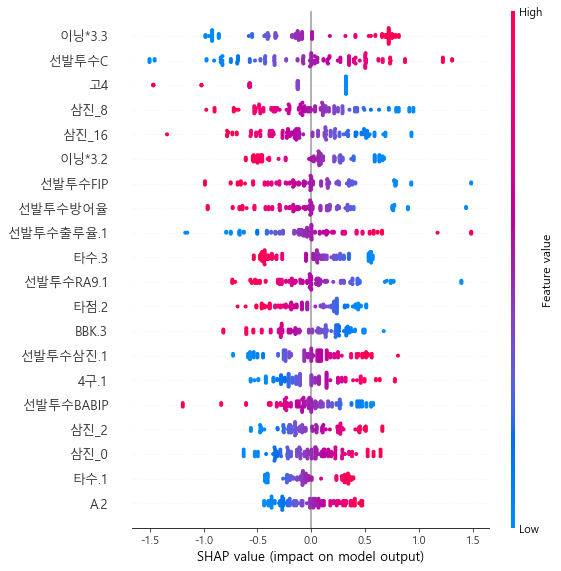

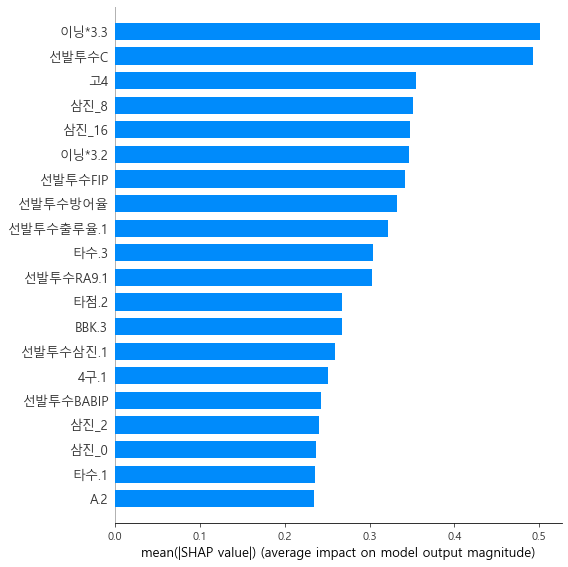

,column_name,shap_importance
1365,이닝*3.3,0.501418
1205,선발투수C,0.49235
1261,고4,0.354889
62,삼진_8,0.350932
70,삼진_16,0.348052
...,...,...
1000,투구수std.1,2.38538e-05
1074,팀구원C.1,2.23277e-05
738,희비6.1,1.68026e-05
1132,XR.1,1.384e-05


In [10]:
import shap

X_importance = test_x

# model = XGBClassifier(random_state=0).fit(train_x, y_train)
# explainer = shap.TreeExplainer(model)
# shap_values = explainer.shap_values(X_importance)

model = LogisticRegression(random_state=0).fit(train_x, y_train)
explainer = shap.LinearExplainer(model, train_x, feature_dependence="independent")
shap_values = explainer.shap_values(X_importance)

# Plot summary_plot
shap.summary_plot(shap_values, X_importance)
# Plot summary_plot as barplot
shap.summary_plot(shap_values, X_importance, plot_type='bar')

shap_sum = np.abs(shap_values).mean(axis=0)
importance_df = pd.DataFrame([X_importance.columns.tolist(), shap_sum.tolist()]).T
importance_df.columns = ['column_name', 'shap_importance']
importance_df = importance_df.sort_values('shap_importance', ascending=False)
importance_df

In [11]:
# train_x
train_x = train_x.rename({'이닝*3.3':'이닝33'}, axis='columns')
train_x['es_weighted'] = (train_x.이닝33) * 4 + (train_x.선발투수C) * 2
for function_name in ['min', 'max', 'sum', 'mean', 'std']:
    train_x['es_{}'.format(function_name)] = eval('np.{}'.format(function_name))(
    train_x[['이닝33', '선발투수C']], axis=1)
train_x['es_cv'] = train_x['es_std']/train_x['es_mean']


# test_x   
test_x = test_x.rename({'이닝*3.3':'이닝33'}, axis='columns')
test_x['es_weighted'] = (test_x.이닝33) * 4 + (test_x.선발투수C) * 2
for function_name in ['min', 'max', 'sum', 'mean', 'std']:
    test_x['es_{}'.format(function_name)] = eval('np.{}'.format(function_name))(
    test_x[['이닝33', '선발투수C']], axis=1)
test_x['es_cv'] = test_x['es_std']/test_x['es_mean']

train_x.head()

,이루삼루타율_0,이루삼루타율_1,이루삼루타율_2,이루삼루타율_3,이루삼루타율_4,이루삼루타율_5,이루삼루타율_6,이루삼루타율_7,이루삼루타율_8,이루삼루타율_9,...,kwERA.3,이닝당투구수.3,도루저지율.3,es_weighted,es_min,es_max,es_sum,es_mean,es_std,es_cv
0,2.709928,-0.108878,-0.641543,-0.913352,-0.309802,0.024614,0.207212,-0.647192,1.199701,-0.617470,...,-0.808226,-0.939239,1.452728,17.564829,0.665333,7.451748,8.117082,4.058541,3.393208,0.836066
1,0.079739,-0.183146,-0.365515,-0.042207,-1.277150,1.023640,-1.484780,-0.705677,-0.039694,-0.172660,...,1.942806,1.700378,-0.483000,-8.727427,-1.655241,-1.053231,-2.708472,-1.354236,0.301005,-0.222269
2,-0.165763,-1.863181,-0.460174,1.604273,-0.426901,-0.771532,-0.090622,0.887890,-1.183094,-0.432974,...,-0.077125,-1.339369,-0.052838,-2.349961,-0.556022,-0.062937,-0.618959,-0.309479,0.246543,-0.796637
3,0.237859,0.765263,0.218078,1.630921,0.487870,0.781938,-0.159304,-0.321706,-0.248331,-0.402118,...,-0.442483,0.806089,-1.257291,1.054081,-1.166699,2.860439,1.693740,0.846870,2.013569,2.377661
4,-1.366980,0.155231,-1.435581,0.195695,-0.137045,-0.593945,0.635775,-1.919076,0.820411,1.087268,...,0.214036,1.185019,-0.353951,2.686677,0.256943,0.543198,0.800141,0.400070,0.143127,0.357755


### Feature Selection

*Select Percentile*
- 각 특성과 타깃(class) 사이에 유의한 통계적 관계가 있는지 계산하여 특성을 선택하는 방법
- model -> 분류분석 : Logistic Regression 사용
- Cross Validations 값 : ShuffileSplit 함수 사용
- 평가지표 : roc auc 기준

교차 검증 결과, 5%의 percentile에서 0.6140이라는 최적의 점수 도출  
-> 과적합을 피하기 위해 최적의 p값 주변의 값을 선택함

100%|██████████████████████████████████████████████████████████████████████████████████| 95/95 [01:26<00:00,  1.10it/s]

(5, 0.6140362107712746)


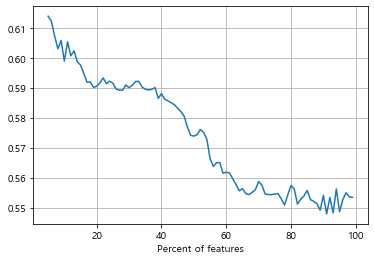

In [12]:
model = LogisticRegression(random_state=0)

cv_scores = []

sscv = ShuffleSplit(n_splits = 5, random_state = 0)

for p in tqdm(range(5,100,1)):
    X_new = SelectPercentile(percentile=p).fit_transform(train_x, y_train)    
    cv_score = cross_val_score(model, X_new, y_train, scoring='roc_auc', cv=sscv).mean()
    cv_scores.append((p,cv_score))

# Print the best percentile
best_score = cv_scores[np.argmax([score for _, score in cv_scores])]
print(best_score)

# Plot the performance change with p
plt.plot([k for k, _ in cv_scores], [score for _, score in cv_scores])
plt.xlabel('Percent of features')
plt.grid()

In [13]:
selectp = SelectPercentile(percentile=best_score[0]).fit(train_x, y_train)
X_train_sel = selectp.transform(train_x)
X_test_sel = selectp.transform(test_x)

### Modeling & Evaluation - Build Models with Hyperparameter Optimization

- 학습데이터 80%, 평가데이터 20%로 데이터 분할
- 15개의 모델 사용(분류분석 모델)
  - KNN, MLP, LR, RF, GB, XGB, LGBM, AdaBoost, Bagging, SGD, SVM, CatBoost, ExtraTree, DT, NB
- Random Search 실행
  - 평가지표 : roc auc 기준
  - Cross Validation : ShuffleSplit 함수 사용

In [14]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train_sel, y_train, test_size=0.2, random_state=0)

In [15]:
clfs = [
   (
        KNeighborsClassifier(),              # 사용하려는 모델
        {'n_neighbors': [3,5,7,9,11],        # 최적화하려는 하이퍼파라미터
         'weights': ['uniform','distance']}
    ),
    (
        MLPClassifier(random_state=0),
        {'batch_size': [32, 64, 128],
         'learning_rate' : ['constant', 'adaptive'],
         'activation': ['tanh', 'relu'],
         'solver': ['sgd', 'adam']}
    ),
    (
        LogisticRegression(random_state=0),  
        {'C': np.arange(0.1, 1.1, 0.1),      
         'penalty': ['l1','l2']}
    ),
    (
        RandomForestClassifier(random_state=0),
        {'n_estimators': [100,200,300],
         'max_depth': [3,4,5],}
        # 'max_features': (np.arange(0.5, 1.0, 0.1)*X_train.shape[1]).astype(int)}
    ),
    (
        GradientBoostingClassifier(random_state=0),
        {'n_estimators': [100, 200, 300],
         'learning_rate': [1, 0.1, 0.01],}
        # 'max_features': (np.arange(0.5, 1.0, 0.1)*X_train.shape[1]).astype(int)}
    ),
    (
        XGBClassifier(tree_method = 'hist', random_state=0),
        {'min_child_weight': range(0, 121, 20),
         'learning_rate': np.arange(0.1, 0.6, 0.1),
         'subsample': np.arange(0.5, 1.0, 0.1)}
    ),
    (
        LGBMClassifier(random_state=0),
        {'min_child_weight': range(0, 121, 20),
         'learning_rate': np.arange(0.1, 0.6, 0.1),
         'subsample': np.arange(0.5, 1.0, 0.1)}
    ),
    (
        AdaBoostClassifier(random_state=0),
        {'n_estimators': [100, 200, 300],
         'learning_rate': [1, 0.1, 0.01],}
    ),
    (
        BaggingClassifier(random_state=0),
        {'n_estimators': [100, 200, 300],
         'max_features': (np.arange(0.5, 1.0, 0.1)*X_train.shape[1]).astype(int)}
    ),
    (
        CatBoostClassifier(random_state=0,verbose=0),
        {'learning_rate': np.arange(0.1, 0.6, 0.1),
         'depth': [3,4,5]}
    ),
    (
        SGDClassifier(loss='log', random_state=0),
        {'penalty': ['l1','l2'],
         'alpha': [0.001, 0.05, 1, 100, 200],
         'max_iter': [1000, 2000, 3000]}
    ),
    (
        SVC(kernel='rbf', probability=True, random_state=0),              
        {'C': [0.01, 0.05, 1.0, 1.1],
         'gamma': np.arange(0.01, 1.0, 0.1)}
    ),
    (
        ExtraTreesClassifier(random_state=0),
        {'n_estimators': [100,200,300],
         'max_depth': [3,4,5,6,7]}
    ),
    (
        DecisionTreeClassifier(random_state=0),              
        {'max_depth': range(2,9,1),        
         'criterion': ['gini', 'entropy']}
    ),
    (
        GaussianNB(),
        {'var_smoothing': np.arange(0.1,1.0,0.1)}
    ),
]

clfs_tuned = []  # 튜닝된 모델을 저장

sscv = ShuffleSplit(n_splits = 5, random_state = 0)

for clf, param_grid in tqdm(clfs):
    start = time.time()
    rand_search = RandomizedSearchCV(clf, param_grid, n_iter=5, scoring='roc_auc', 
                                     cv=sscv, random_state=0, n_jobs=-1)
    rand_search.fit(X_train, y_train)
    clf_name = type(clf).__name__
    clf_score = rand_search.score(X_valid, y_valid)
    print('{:30s} {:30f} {:.1f}'.format(clf_name, clf_score, time.time() - start))
    clfs_tuned.append((clf_name, rand_search, clf_score))

  7%|█████▌                                                                             | 1/15 [00:06<01:27,  6.22s/it]

KNeighborsClassifier                                 0.550938 6.2


 13%|███████████                                                                        | 2/15 [00:22<02:01,  9.36s/it]

MLPClassifier                                        0.597721 16.7


 20%|████████████████▌                                                                  | 3/15 [00:23<01:19,  6.63s/it]

LogisticRegression                                   0.594556 0.3


 27%|██████████████████████▏                                                            | 4/15 [00:29<01:12,  6.62s/it]

RandomForestClassifier                               0.608087 6.6


 33%|███████████████████████████▋                                                       | 5/15 [00:54<02:00, 12.07s/it]

GradientBoostingClassifier                           0.607454 24.8


 40%|█████████████████████████████████▏                                                 | 6/15 [00:57<01:23,  9.31s/it]

XGBClassifier                                        0.558672 2.9


 47%|██████████████████████████████████████▋                                            | 7/15 [00:59<00:56,  7.00s/it]

LGBMClassifier                                       0.543322 1.6


 53%|████████████████████████████████████████████▎                                      | 8/15 [01:13<01:04,  9.28s/it]

AdaBoostClassifier                                   0.576495 14.6


 60%|█████████████████████████████████████████████████▊                                 | 9/15 [01:50<01:45, 17.64s/it]

BaggingClassifier                                    0.570205 37.1


 67%|██████████████████████████████████████████████████████▋                           | 10/15 [03:41<03:47, 45.55s/it]

CatBoostClassifier                                   0.561046 110.7
SGDClassifier                                        0.612913 0.2

 73%|████████████████████████████████████████████████████████████▏                     | 11/15 [03:41<02:07, 31.94s/it]

 80%|█████████████████████████████████████████████████████████████████▌                | 12/15 [03:47<01:12, 24.15s/it]

SVC                                                  0.598868 6.0


 87%|███████████████████████████████████████████████████████████████████████           | 13/15 [03:50<00:35, 17.81s/it]

ExtraTreesClassifier                                 0.607236 3.0


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [03:51<00:00, 15.40s/it]

DecisionTreeClassifier                               0.500277 0.3
GaussianNB                                           0.614536 0.1


### Ensemble

*Averaging*
- Random Search를 통한 15개의 모델을 사용하여 averaging ensemble 실행
- p=1 : 산술평균, p=0 : 기하평균, 그 외 : 멱평균(과적합 가능성)

p=0인 기하평균일때,  
MLP, RF, GB, SGD, GaussianNB 라는 최적의 모델이 추출되어 조합됨 -> roc auc 기준 0.6250의 score값 생성  
  
*Stacking*
- Random Search를 통한 15개의 모델을 사용하여 Logistic Regression 기반 stacking ensemble 실행
- 1단계 : 15개의 모델로 학습 데이터로 학습 모델 생성
- 2단계 : 15개의 모델에서 학습을 마친 뒤 예측한 값들을 합쳐서 최종 예측

-> roc auc 기준 0.6228의 score값 생성

In [16]:
selected = [
    'KNeighborsClassifier', 
    'MLPClassifier',
    'LogisticRegression', 
    'RandomForestClassifier', 
    'GradientBoostingClassifier',    
    'XGBClassifier',
    'LGBMClassifier',
    'AdaBoostClassifier',
    'BaggingClassifier',
    'CatBoostClassifier',
    'SGDClassifier',
    'SVC',
    'ExtraTreesClassifier',
    'DecisionTreeClassifier',
    'GaussianNB'
]
models_for_ensemble = [clf for clf in clfs_tuned if clf[0] in selected]

In [17]:
max_score = 0
for p in tqdm([0, 1, 2.56]):  # p=1:산술평균, p=0:기하평균, 그 외:멱평균 
    for i in range(2, len(models_for_ensemble)+1):
        for models in combinations(models_for_ensemble, i):
            if p == 0:
                pred_mean = gmean([clf.predict_proba(X_valid)[:,1] for name, clf, _ in models], axis=0)
            else:
                preds = [clf.predict_proba(X_valid)[:,1] for name, clf, _ in models]
                pred_mean = (np.sum(np.array(preds)**p, axis=0) / len(models))**(1/p)
            score = roc_auc_score(y_valid, pred_mean)
            if max_score < score:
                best_avg_ensemble = (p, models, score)
                max_score = score

p, models, score = best_avg_ensemble
print('p={}\n{}\n{}'.format(p, '●'.join([clf_name for clf_name, _, _ in models]), score))

100%|████████████████████████████████████████████████████████████████████████████████| 3/3 [3:26:33<00:00, 4131.08s/it]

p=0
MLPClassifier●RandomForestClassifier●GradientBoostingClassifier●SGDClassifier●GaussianNB
0.6250197816110143


In [33]:
# Initialize 1st level estimators
selected = [
    'KNeighborsClassifier', 
    'MLPClassifier',
    'LogisticRegression', 
    'RandomForestClassifier', 
    'GradientBoostingClassifier',    
    'XGBClassifier',
    'LGBMClassifier',
    'AdaBoostClassifier',
    'BaggingClassifier',
    'CatBoostClassifier',
    'SGDClassifier',
    'SVC',
    'CatBoostClassifier',
    'ExtraTreesClassifier',
    'DecisionTreeClassifier',
    'GaussianNB'
]
estimators = [(name, clf) for name, clf, _ in clfs_tuned if name in selected]
              
# Initialize StackingTransformer
stack = StackingTransformer(estimators, regression=False, needs_proba=True, metric=None,
                            n_folds=3, stratified=True, shuffle=True, random_state=0)

# Fit
stack = stack.fit(X_train, y_train)

# Get your stacked features
S_train = stack.transform(X_train)
S_valid = stack.transform(X_valid)
S_test = stack.transform(X_test_sel)

# Use 2nd level estimator with stacked features
meta_model = LogisticRegression().fit(S_train, y_train)
print(roc_auc_score(y_valid, meta_model.predict_proba(S_valid)[:,1]))  

0.6228833676214591


### Deployment

averaging ensemble과 stacking ensemble의 score값을 비교하여 더 높은 점수를 가진 모델을 선택함  
--> 승률 예측에선 averaging ensemble 선택   
선택한 모델과 test 데이터를 각 클래스에 대한 확률로 예측 -> 팀별 승률 예측

In [34]:
# Apply the best averaging ensemble model to Unseen Data
if p == 0:
    pred_mean = gmean([clf.predict_proba(X_test_sel)[:,1] for name, clf, _ in models], axis=0)
else:
    preds = [clf.predict_proba(X_test_sel)[:,1] for name, clf, _ in models]
    pred_mean = (np.sum(np.array(preds)**p, axis=0) / len(models))**(1/p)
    
pm_wl = pd.DataFrame({'T_ID': t_id_wl, '승률': pred_mean})
# pm_wl.to_csv('승률_predmean.csv', encoding='cp949', index=False)

gb_wl = pm_wl.groupby('T_ID')['승률'].agg([('승률',np.mean)]).reset_index().sort_values(by='승률', ascending=False)
# gb_wl.to_csv('승률_groupby.csv', encoding='cp949', index=False)

gb_wl

,T_ID,승률
0,HH,0.550535
2,KT,0.520015
7,SK,0.493308
9,WO,0.460478
3,LG,0.429478
1,HT,0.426598
4,LT,0.416067
8,SS,0.396232
6,OB,0.372002
5,NC,0.329374


## 타율 예측

In [75]:
# (2016~2019) 학습데이터
train_x = feaavg.iloc[:,2:] # G_ID,T_ID 제외
y_train = y_train_hp

# (2020) 예측데이터
test_x = feaavg20.iloc[:,2:]
t_id_hp = feaavg20.iloc[:,1]

**(2016~2019 / 2020)** Addition / Subtraction 피쳐  
#### Shap importance를 통해 1위, 2위 피쳐를 이용한 새로운 피쳐 생성  
1위 : 삼진_6, 2위 : 삼진_0의 addition/subtraction 피쳐  
model -> 회귀분석 : Linear Regression 사용

- 가중치(1위 0.4, 2위 0.2) 피쳐
- numpy의 내장함수 이용한 피쳐
- 변동계수(cv, 평균/표준편차) 피쳐

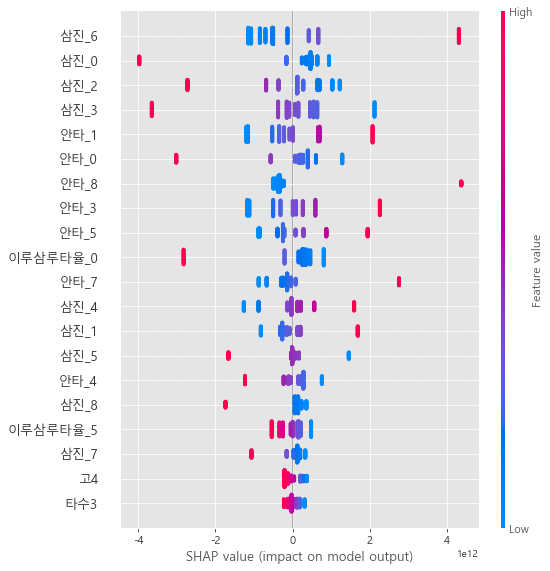

,column_name,shap_importance
33,삼진_6,1.03117e+12
27,삼진_0,8.31699e+11
29,삼진_2,8.19473e+11
30,삼진_3,8.11656e+11
19,안타_1,7.38285e+11
...,...,...
490,3루타.1,0.000165057
561,도루저지율,0.000150761
546,345번타자WHIP,0.000139433
458,선발투수희비,0.000138986


In [76]:
import shap

X_importance = test_x

# model = xgboost.XGBRegressor(random_state=0).fit(train_x, y_train)
# explainer = shap.TreeExplainer(model)
# shap_values = explainer.shap_values(X_importance)

from sklearn.linear_model import LinearRegression
model = LinearRegression().fit(train_x, y_train)
explainer = shap.LinearExplainer(model, train_x, feature_dependence="independent")
shap_values = explainer.shap_values(X_importance)

# Plot summary_plot
shap.summary_plot(shap_values, X_importance)

shap_sum = np.abs(shap_values).mean(axis=0)
importance_df = pd.DataFrame([X_importance.columns.tolist(), shap_sum.tolist()]).T
importance_df.columns = ['column_name', 'shap_importance']
importance_df = importance_df.sort_values('shap_importance', ascending=False)
importance_df

In [77]:
# train_x
train_x['ss_weighted'] = (train_x.삼진_6) * 4 + (train_x.삼진_0) * 2
for function_name in ['min', 'max', 'sum', 'mean', 'std']:
    train_x['ss_{}'.format(function_name)] = eval('np.{}'.format(function_name))(
    train_x[['삼진_6', '삼진_0']], axis=1)
train_x['ss_cv'] = train_x['ss_std']/train_x['ss_mean']
    
    
# test_x
test_x['ss_weighted'] = (test_x.삼진_6) * 4 + (test_x.삼진_0) * 2
for function_name in ['min', 'max', 'sum', 'mean', 'std']:
    test_x['ss_{}'.format(function_name)] = eval('np.{}'.format(function_name))(
    test_x[['삼진_6', '삼진_0']], axis=1)
test_x['ss_cv'] = test_x['ss_std']/test_x['ss_mean']
           
train_x.head()

,이루삼루타율_0,이루삼루타율_1,이루삼루타율_2,이루삼루타율_3,이루삼루타율_4,이루삼루타율_5,이루삼루타율_6,이루삼루타율_7,이루삼루타율_8,도루성공률_0,...,kwERA,이닝당투구수,도루저지율,ss_weighted,ss_min,ss_max,ss_sum,ss_mean,ss_std,ss_cv
0,2.969593,0.042357,0.002978,0.042376,-0.058793,-0.185816,-0.032002,-0.048296,-0.018998,-0.159259,...,-0.775189,-0.904451,1.428883,-20.463837,-10.617242,0.192662,-10.424580,-5.212290,5.404952,-1.036963
1,-0.287941,0.046760,0.108054,-0.158302,0.223848,-0.169027,0.359315,1.299129,1.832094,-0.178608,...,1.045172,1.229368,-0.243742,-22.451988,-6.001742,0.777490,-5.224252,-2.612126,3.389616,-1.297646
2,2.969593,0.042357,0.002978,0.042376,-0.058793,-0.185816,-0.032002,-0.048296,-0.018998,-0.159259,...,-2.427277,-1.224419,-0.057895,-20.463837,-10.617242,0.192662,-10.424580,-5.212290,5.404952,-1.036963
3,-0.385760,-0.020920,1.580718,1.695307,-0.303762,-0.484375,-0.164467,-0.277848,-0.110255,-0.172402,...,0.244345,1.243027,-0.355250,1.404755,-0.448935,0.575656,0.126721,0.063361,0.512295,8.085385
4,-0.300168,0.273493,-0.139424,-0.095158,0.156986,-0.212613,0.240436,1.694387,-1.508773,-0.096483,...,-0.843707,-0.737734,-2.394260,-2.980245,-0.763565,0.037008,-0.726557,-0.363279,0.400287,-1.101872


### Feature Selection

*Select Percentile*
- 각 특성과 타깃(class) 사이에 유의한 통계적 관계가 있는지 계산하여 특성을 선택하는 방법
- model -> 회귀분석 : Linear Regression 사용
- Cross Validations 값 : ShuffileSplit 함수 사용
- 평가지표 : mean absolute error 기준

교차 검증 결과, 5%의 percentile에서 -0.0628이라는 최적의 점수 도출  
-> 과적합을 피하기 위해 최적의 p값 주변의 값을 선택함

100%|██████████████████████████████████████████████████████████████████████████████████| 95/95 [00:43<00:00,  2.17it/s]


(5, -0.06285790788069907)


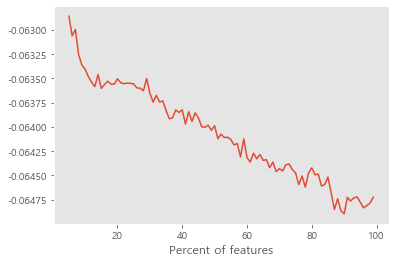

In [78]:
model = LinearRegression()

cv_scores = []

sscv = ShuffleSplit(n_splits = 5, random_state = 0)

for p in tqdm(range(5,100,1)):
    X_new = SelectPercentile(percentile=p).fit_transform(train_x, y_train)    
    cv_score = cross_val_score(model, X_new, y_train, scoring='neg_mean_absolute_error', cv=sscv).mean()
    cv_scores.append((p,cv_score))

# Print the best percentile
best_score = cv_scores[np.argmax([score for _, score in cv_scores])]
print(best_score)

# Plot the performance change with p
plt.plot([k for k, _ in cv_scores], [score for _, score in cv_scores])
plt.xlabel('Percent of features')
plt.grid()

In [79]:
selectp = SelectPercentile(percentile=best_score[0]).fit(train_x, y_train)
X_train_sel = selectp.transform(train_x)
X_test_sel = selectp.transform(test_x)

### Modeling & Evaluation - Build Models with Hyperparameter Optimization

- 학습데이터 80%, 평가데이터 20%로 데이터 분할
- 12개의 모델 사용(회귀분석 모델)
  - KNN, LR, RF, GB, XGB, LGBM, AdaBoost, Bagging, SGD, CatBoost, ExtraTree, DT
- Random Search 실행
  - 평가지표 : mean absolute error 기준
  - Cross Validation : ShuffleSplit 함수 사용

In [81]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train_sel, y_train, test_size=0.2, random_state=0)

In [82]:
clfs = [
   (
        KNeighborsRegressor(),              # 사용하려는 모델
        {'n_neighbors': [3,5,7,9,11],        # 최적화하려는 하이퍼파라미터
         'weights': ['uniform','distance']}
    ),
    (
        LinearRegression(),  
        {
         }
    ),
    (
        RandomForestRegressor(random_state=0),
        {'n_estimators': [100,200,300],
         'max_depth': [3,4,5],}
        # 'max_features': (np.arange(0.5, 1.0, 0.1)*X_train.shape[1]).astype(int)}
    ),
    (
        GradientBoostingRegressor(random_state=0),
        {'n_estimators': [100, 200, 300],
         'learning_rate': [1, 0.1, 0.01],}
        # 'max_features': (np.arange(0.5, 1.0, 0.1)*X_train.shape[1]).astype(int)}
    ),
    (
        XGBRegressor(tree_method = 'hist', random_state=0),
        {'min_child_weight': range(0, 121, 20),
         'learning_rate': np.arange(0.1, 0.6, 0.1),
         'subsample': np.arange(0.5, 1.0, 0.1)}
    ),
    (
        LGBMRegressor(random_state=0),
        {'min_child_weight': range(0, 121, 20),
         'learning_rate': np.arange(0.1, 0.6, 0.1),
         'subsample': np.arange(0.5, 1.0, 0.1)}
    ),
    (
        AdaBoostRegressor(random_state=0),
        {'n_estimators': [100, 200, 300],
         'learning_rate': [1, 0.1, 0.01],}
    ),
    (
        BaggingRegressor(random_state=0),
        {'n_estimators': [100, 200, 300],
         'max_features': (np.arange(0.5, 1.0, 0.1)*X_train.shape[1]).astype(int)}
    ),
    (
        CatBoostRegressor(random_state=0,verbose=0),
        {'learning_rate': np.arange(0.1, 0.6, 0.1),
         'depth': [3,4,5]}
    ),
    (
        SGDRegressor(random_state=0),
        {'penalty': ['l1','l2'],
         'alpha': [0.001, 0.05, 1, 100, 200],
         'max_iter': [1000, 2000, 3000]}
    ),
    (
        ExtraTreesRegressor(random_state=0),
        {'n_estimators': [100,200,300],
         'max_depth': [3,4,5,6,7]}
    ),
    (
        DecisionTreeRegressor(random_state=0),              
        {'max_depth': range(2,9,1),        
         'criterion': ['mse', 'friedman_mse', 'mae'],
         'splitter': ['best','random']}
    ),
]

clfs_tuned = []  # 튜닝된 모델을 저장

sscv = ShuffleSplit(n_splits = 5, random_state = 0)

for clf, param_grid in tqdm(clfs):
    start = time.time()
    rand_search = RandomizedSearchCV(clf, param_grid, n_iter=5, scoring='neg_mean_absolute_error', 
                                     cv=sscv, random_state=0, n_jobs=-1)
    rand_search.fit(X_train, y_train)
    clf_name = type(clf).__name__
    clf_score = rand_search.score(X_valid, y_valid)
    print('{:30s} {:30f} {:.1f}'.format(clf_name, clf_score, time.time() - start))
    clfs_tuned.append((clf_name, rand_search, clf_score))

  8%|██████▉                                                                            | 1/12 [00:06<01:09,  6.30s/it]

KNeighborsRegressor                                 -0.068023 6.3
LinearRegression                                    -0.065332 0.1


 25%|████████████████████▊                                                              | 3/12 [00:29<01:10,  7.86s/it]

RandomForestRegressor                               -0.065693 22.9


 33%|███████████████████████████▋                                                       | 4/12 [00:54<01:43, 12.95s/it]

GradientBoostingRegressor                           -0.065589 24.8
[12:05:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 42%|██████████████████████████████████▌                                                | 5/12 [01:00<01:17, 11.02s/it]

XGBRegressor                                        -0.068697 6.5


 50%|█████████████████████████████████████████▌                                         | 6/12 [01:06<00:57,  9.52s/it]

LGBMRegressor                                       -0.071032 6.0


 58%|████████████████████████████████████████████████▍                                  | 7/12 [01:26<01:02, 12.55s/it]

AdaBoostRegressor                                   -0.065583 19.6


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [02:37<02:00, 30.02s/it]

BaggingRegressor                                    -0.071217 70.8


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [05:13<03:23, 67.95s/it]

CatBoostRegressor                                   -0.073366 156.5


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [05:13<01:35, 47.65s/it]

SGDRegressor                                        -0.064737 0.3


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [05:28<00:37, 37.83s/it]

ExtraTreesRegressor                                 -0.065714 14.9


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [05:33<00:00, 27.78s/it]

DecisionTreeRegressor                               -0.067457 4.6


### Ensemble

*Averaging*
- Random Search를 통한 12개의 모델을 사용하여 averaging ensemble 실행
- p=1 : 산술평균, p=0 : 기하평균, 그 외 : 멱평균(과적합 가능성)

p=0인 기하평균일때,  
BR, CatBoost 라는 최적의 모델이 추출되어 조합됨 -> mean absolute error 기준 0.0717의 score값 생성  
  
*Stacking*
- Random Search를 통한 12개의 모델을 사용하여 Linear Regression 기반 stacking ensemble 실행
- 1단계 : 12개의 모델로 학습 데이터로 학습 모델 생성
- 2단계 : 12개의 모델에서 학습을 마친 뒤 예측한 값들을 합쳐서 최종 예측

-> mean absolute error 기준 0.0651의 score값 생성

In [83]:
selected = [
    'KNeighborsRegressor', 
    'LinearRegression', 
    'RandomForestRegressor', 
    'GradientBoostingRegressor',    
    'XGBRegressor',
    'LGBMRegressor',
    'AdaBoostRegressor',
    'BaggingRegressor',
    'CatBoostRegressor',
    'SGDRegressor',
    'ExtraTreesRegressor',
    'DecisionTreeRegressor',
]
models_for_ensemble = [clf for clf in clfs_tuned if clf[0] in selected]

In [84]:
max_score = 0
for p in tqdm([0, 1, 2.56]):  # p=1:산술평균, p=0:기하평균, 그 외:멱평균   
    for i in range(2, len(models_for_ensemble)+1):
        for models in combinations(models_for_ensemble, i):
            if p == 0:
                pred_mean = gmean([clf.predict(X_valid) for name, clf, _ in models], axis=0)
            else:
                preds = [clf.predict(X_valid) for name, clf, _ in models]
                pred_mean = (np.sum(np.array(preds)**p, axis=0) / len(models))**(1/p)
            score = mean_absolute_error(y_valid, pred_mean)
            if max_score < score:
                best_avg_ensemble = (p, models, score)
                max_score = score

p, models, score = best_avg_ensemble
print('p={}\n{}\n{}'.format(p, '●'.join([clf_name for clf_name, _, _ in models]), score))

100%|██████████████████████████████████████████████████████████████████████████████████| 3/3 [51:11<00:00, 1023.84s/it]

p=0
BaggingRegressor●CatBoostRegressor
0.07175500690937042


In [85]:
# Initialize 1st level estimators
selected = [
    'KNeighborsRegressor', 
    'LinearRegression', 
    'RandomForestRegressor', 
    'GradientBoostingRegressor',    
    'XGBRegressor',
    'LGBMRegressor',
    'AdaBoostRegressor',
    'BaggingRegressor',
    'CatBoostRegressor',
    'SGDRegressor',
    'ExtraTreesRegressor',
    'DecisionTreeRegressor',
]
estimators = [(name, clf) for name, clf, _ in clfs_tuned if name in selected]
              
# Initialize StackingTransformer
stack = StackingTransformer(estimators, regression=True, needs_proba=True, metric=None,
                            n_folds=3, stratified=True, shuffle=True, random_state=0)

# Fit
stack = stack.fit(X_train, y_train)

# Get your stacked features
S_train = stack.transform(X_train)
S_valid = stack.transform(X_valid)
S_test = stack.transform(X_test_sel)

# Use 2nd level estimator with stacked features
meta_model = LinearRegression().fit(S_train, y_train)
print(mean_absolute_error(y_valid, meta_model.predict(S_valid)))  

[13:05:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:05:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:05:17] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
tf.Tensor(0.065132126, shape=(), dtype=float32)


### Deployment

averaging ensemble과 stacking ensemble의 score값을 비교하여 더 높은 점수를 가진 모델을 선택함  
--> 타율 예측에선 stacking ensemble 선택  
선택한 모델과 test 데이터를 각 클래스에 대한 확률로 예측 -> 팀별 타율 예측

In [87]:
# Apply the stacking model to Unseen Data
me_hp = pd.DataFrame({'T_ID': t_id_hp, '타율': meta_model.predict(S_test)})
# me_hp.to_csv('타율_meta.csv', encoding='cp949', index=False)

gb_hp = me_hp.groupby('T_ID')['타율'].agg([('타율',np.mean)]).reset_index().sort_values(by='타율', ascending=False)
# gb_hp.to_csv('타율_groupby.csv', encoding='cp949', index=False)

gb_hp

,T_ID,타율
2,KT,0.299387
6,OB,0.291961
9,WO,0.284828
4,LT,0.283194
8,SS,0.280435
3,LG,0.278214
5,NC,0.274950
1,HT,0.272298
7,SK,0.267659
0,HH,0.267368


## 방어율 예측

In [34]:
# (2016~2019) 학습데이터
train_x = feaera.iloc[:,2:] # G_ID,T_ID 제외
y_train = y_train_pp

# (2020) 예측데이터
test_x = feaera20.iloc[:,2:]
t_id_pp = feaera20.iloc[:,1]

**(2016~2019 / 2020)** Addition / Subtraction 피쳐  
#### Shap importance를 통해 1위, 2위 피쳐를 이용한 새로운 피쳐 생성  
1위 : 타수, 2위 : 이닝* 3의 addition/subtraction 피쳐  
model -> 회귀분석 : Linear Regression 사용

- 가중치(1위 0.4, 2위 0.2) 피쳐
- numpy의 내장함수 이용한 피쳐
- 변동계수(cv, 평균/표준편차) 피쳐

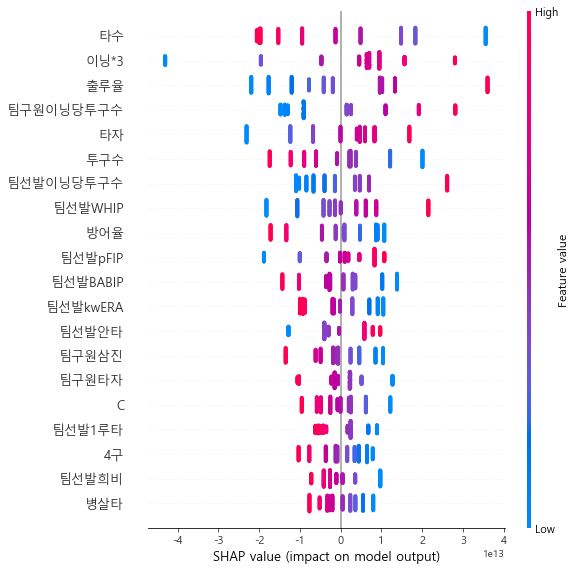

,column_name,shap_importance
143,타수,1.61896e+13
140,이닝*3,1.48759e+13
163,출루율,1.37403e+13
121,팀구원이닝당투구수,1.20813e+13
142,타자,9.33544e+12
...,...,...
274,2점차WHIP,0.0293362
198,선발투수2점차WHIP,0.0284835
186,선발투수희타,0.0283512
183,선발투수홈런,0.00770612


In [35]:
import shap

X_importance = test_x

# model = xgboost.XGBRegressor(random_state=0).fit(train_x, y_train)
# explainer = shap.TreeExplainer(model)
# shap_values = explainer.shap_values(X_importance)

from sklearn.linear_model import LinearRegression
model = LinearRegression().fit(train_x, y_train)
explainer = shap.LinearExplainer(model, train_x, feature_dependence="independent")
shap_values = explainer.shap_values(X_importance)

# Plot summary_plot
shap.summary_plot(shap_values, X_importance)

shap_sum = np.abs(shap_values).mean(axis=0)
importance_df = pd.DataFrame([X_importance.columns.tolist(), shap_sum.tolist()]).T
importance_df.columns = ['column_name', 'shap_importance']
importance_df = importance_df.sort_values('shap_importance', ascending=False)
importance_df

In [36]:
# train_x
train_x = train_x.rename({'이닝*3':'이닝3'}, axis='columns')
train_x['et_weighted'] = (train_x.타수) * 4 + (train_x.이닝3) * 2
for function_name in ['min', 'max', 'sum', 'mean', 'std']:
    train_x['et_{}'.format(function_name)] = eval('np.{}'.format(function_name))(
    train_x[['타수', '이닝3']], axis=1)
train_x['et_cv'] = train_x['et_std']/train_x['et_mean']
    
    
# test_x
test_x = test_x.rename({'이닝*3':'이닝3'}, axis='columns')
test_x['et_weighted'] = (test_x.타수) * 4 + (test_x.이닝3) * 2
for function_name in ['min', 'max', 'sum', 'mean', 'std']:
    test_x['et_{}'.format(function_name)] = eval('np.{}'.format(function_name))(
    test_x[['타수', '이닝3']], axis=1)
test_x['et_cv'] = test_x['et_std']/test_x['et_mean']
           
train_x.head()

,이루삼루타율_0,이루삼루타율_1,이루삼루타율_2,이루삼루타율_3,이루삼루타율_4,이루삼루타율_5,이루삼루타율_6,이루삼루타율_7,이루삼루타율_8,도루성공률_0,...,kwERA.1,이닝당투구수.1,도루저지율.1,et_weighted,et_min,et_max,et_sum,et_mean,et_std,et_cv
0,2.969593,0.042357,0.002978,0.042376,-0.058793,-0.185816,-0.032002,-0.048296,-0.018998,-0.159259,...,-0.775189,-0.904451,1.428883,1.777399,-0.048674,0.468687,0.420013,0.210006,0.258680,1.231774
1,-0.287941,0.046760,0.108054,-0.158302,0.223848,-0.169027,0.359315,1.299129,1.832094,-0.178608,...,1.045172,1.229368,-0.243742,7.003680,0.983636,1.534568,2.518204,1.259102,0.275466,0.218780
2,2.969593,0.042357,0.002978,0.042376,-0.058793,-0.185816,-0.032002,-0.048296,-0.018998,-0.159259,...,-2.427277,-1.224419,-0.057895,-3.858215,-1.325330,0.721552,-0.603778,-0.301889,1.023441,-3.390124
3,-0.385760,-0.020920,1.580718,1.695307,-0.303762,-0.484375,-0.164467,-0.277848,-0.110255,-0.172402,...,0.244345,1.243027,-0.355250,7.003680,0.983636,1.534568,2.518204,1.259102,0.275466,0.218780
4,-0.300168,0.273493,-0.139424,-0.095158,0.156986,-0.212613,0.240436,1.694387,-1.508773,-0.096483,...,-0.843707,-0.737734,-2.394260,-1.921211,-0.926659,0.892713,-0.033946,-0.016973,0.909686,-53.595740


### Feature Selection

*Select Percentile*
- 각 특성과 타깃(class) 사이에 유의한 통계적 관계가 있는지 계산하여 특성을 선택하는 방법
- model -> 회귀분석 : Linear Regression 사용
- Cross Validations 값 : ShuffileSplit 함수 사용
- 평가지표 : mean absolute error 기준

교차 검증 결과, 20%의 percentile에서 -2.8985라는 최적의 점수 도출  
-> 과적합을 피하기 위해 최적의 p값 주변의 값을 선택함

100%|██████████████████████████████████████████████████████████████████████████████████| 95/95 [00:34<00:00,  2.78it/s]


(20, -2.898537894141731)


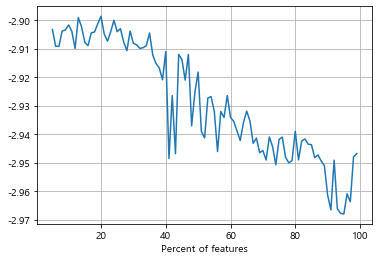

In [37]:
model = LinearRegression()

cv_scores = []

sscv = ShuffleSplit(n_splits = 5, random_state = 0)

for p in tqdm(range(5,100,1)):
    X_new = SelectPercentile(percentile=p).fit_transform(train_x, y_train)    
    cv_score = cross_val_score(model, X_new, y_train, scoring='neg_mean_absolute_error', cv=sscv).mean()
    cv_scores.append((p,cv_score))

# Print the best percentile
best_score = cv_scores[np.argmax([score for _, score in cv_scores])]
print(best_score)

# Plot the performance change with p
plt.plot([k for k, _ in cv_scores], [score for _, score in cv_scores])
plt.xlabel('Percent of features')
plt.grid()

In [38]:
selectp = SelectPercentile(percentile=best_score[0]).fit(train_x, y_train)
X_train_sel = selectp.transform(train_x)
X_test_sel = selectp.transform(test_x)

### Modeling & Evaluation - Build Models with Hyperparameter Optimization

- 학습데이터 80%, 평가데이터 20%로 데이터 분할
- 12개의 모델 사용(회귀분석 모델)
  - KNN, LR, RF, GB, XGB, LGBM, AdaBoost, Bagging, SGD, CatBoost, ExtraTree, DT
- Random Search 실행
  - 평가지표 : mean absolute error 기준
  - Cross Validation : ShuffleSplit 함수 사용

In [40]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train_sel, y_train, test_size=0.2, random_state=0)

In [41]:
clfs = [
   (
        KNeighborsRegressor(),              # 사용하려는 모델
        {'n_neighbors': [3,5,7,9,11],        # 최적화하려는 하이퍼파라미터
         'weights': ['uniform','distance']}
    ),
    (
        LinearRegression(),  
        {
         }
    ),
    (
        RandomForestRegressor(random_state=0),
        {'n_estimators': [100,200,300],
         'max_depth': [3,4,5],}
        # 'max_features': (np.arange(0.5, 1.0, 0.1)*X_train.shape[1]).astype(int)}
    ),
    (
        GradientBoostingRegressor(random_state=0),
        {'n_estimators': [100, 200, 300],
         'learning_rate': [1, 0.1, 0.01],}
        # 'max_features': (np.arange(0.5, 1.0, 0.1)*X_train.shape[1]).astype(int)}
    ),
    (
        XGBRegressor(tree_method = 'hist', random_state=0),
        {'min_child_weight': range(0, 121, 20),
         'learning_rate': np.arange(0.1, 0.6, 0.1),
         'subsample': np.arange(0.5, 1.0, 0.1)}
    ),
    (
        LGBMRegressor(random_state=0),
        {'min_child_weight': range(0, 121, 20),
         'learning_rate': np.arange(0.1, 0.6, 0.1),
         'subsample': np.arange(0.5, 1.0, 0.1)}
    ),
    (
        AdaBoostRegressor(random_state=0),
        {'n_estimators': [100, 200, 300],
         'learning_rate': [1, 0.1, 0.01],}
    ),
    (
        BaggingRegressor(random_state=0),
        {'n_estimators': [100, 200, 300],
         'max_features': (np.arange(0.5, 1.0, 0.1)*X_train.shape[1]).astype(int)}
    ),
    (
        CatBoostRegressor(random_state=0,verbose=0),
        {'learning_rate': np.arange(0.1, 0.6, 0.1),
         'depth': [3,4,5]}
    ),
    (
        SGDRegressor(random_state=0),
        {'penalty': ['l1','l2'],
         'alpha': [0.001, 0.05, 1, 100, 200],
         'max_iter': [1000, 2000, 3000]}
    ),
    (
        ExtraTreesRegressor(random_state=0),
        {'n_estimators': [100,200,300],
         'max_depth': [3,4,5,6,7]}
    ),
    (
        DecisionTreeRegressor(random_state=0),              
        {'max_depth': range(2,9,1),        
         'criterion': ['mse', 'friedman_mse', 'mae'],
         'splitter': ['best','random']}
    ),
]

clfs_tuned = []  # 튜닝된 모델을 저장

sscv = ShuffleSplit(n_splits = 5, random_state = 0)

for clf, param_grid in tqdm(clfs):
    start = time.time()
    rand_search = RandomizedSearchCV(clf, param_grid, n_iter=5, scoring='neg_mean_absolute_error', 
                                     cv=sscv, random_state=0, n_jobs=-1)
    rand_search.fit(X_train, y_train)
    clf_name = type(clf).__name__
    clf_score = rand_search.score(X_valid, y_valid)
    print('{:30s} {:30f} {:.1f}'.format(clf_name, clf_score, time.time() - start))
    clfs_tuned.append((clf_name, rand_search, clf_score))

  8%|██████▉                                                                            | 1/12 [00:11<02:08, 11.66s/it]

KNeighborsRegressor                                 -2.947527 11.7


 17%|█████████████▊                                                                     | 2/12 [00:11<01:22,  8.23s/it]

LinearRegression                                    -2.870205 0.2


 25%|████████████████████▊                                                              | 3/12 [00:59<03:01, 20.14s/it]

RandomForestRegressor                               -2.874083 48.0


 33%|███████████████████████████▋                                                       | 4/12 [02:09<04:39, 34.92s/it]

GradientBoostingRegressor                           -2.873997 69.4
[12:41:09] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 42%|██████████████████████████████████▌                                                | 5/12 [02:20<03:15, 27.87s/it]

XGBRegressor                                        -2.941087 11.4


 50%|█████████████████████████████████████████▌                                         | 6/12 [02:32<02:18, 23.00s/it]

LGBMRegressor                                       -3.078941 11.6


 58%|████████████████████████████████████████████████▍                                  | 7/12 [03:17<02:29, 29.81s/it]

AdaBoostRegressor                                   -2.920830 45.7


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [05:15<03:44, 56.12s/it]

BaggingRegressor                                    -3.136564 117.5


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [08:07<04:32, 90.91s/it]

CatBoostRegressor                                   -3.180987 172.1


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [08:08<02:07, 63.90s/it]

SGDRegressor                                        -2.901525 0.9


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [08:29<00:51, 51.05s/it]

ExtraTreesRegressor                                 -2.883430 21.1


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [08:35<00:00, 43.00s/it]

DecisionTreeRegressor                               -2.813458 6.4


### Ensemble

*Averaging*
- Random Search를 통한 12개의 모델을 사용하여 averaging ensemble 실행
- p=1 : 산술평균, p=0 : 기하평균, 그 외 : 멱평균(과적합 가능성)

p=1인 산술평균일때,  
Bagging, CatBoost 라는 최적의 모델이 추출되어 조합됨 -> mean absolute error 기준 3.1347의 score값 생성  
  
*Stacking*
- Random Search를 통한 12개의 모델을 사용하여 Linear Regression 기반 stacking ensemble 실행
- 1단계 : 12개의 모델로 학습 데이터로 학습 모델 생성
- 2단계 : 12개의 모델에서 학습을 마친 뒤 예측한 값들을 합쳐서 최종 예측

-> mean absolute error 기준 2.8771의 score값 생성

In [42]:
selected = [
    'KNeighborsRegressor', 
    'LinearRegression', 
    'RandomForestRegressor', 
    'GradientBoostingRegressor',    
    'XGBRegressor',
    'LGBMRegressor',
    'AdaBoostRegressor',
    'BaggingRegressor',
    'CatBoostRegressor',
    'SGDRegressor',
    'ExtraTreesRegressor',
    'DecisionTreeRegressor',
]
models_for_ensemble = [clf for clf in clfs_tuned if clf[0] in selected]

In [43]:
max_score = 0
for p in tqdm([0, 1, 2.56]):  # p=1:산술평균, p=0:기하평균, 그 외:멱평균   
    for i in range(2, len(models_for_ensemble)+1):
        for models in combinations(models_for_ensemble, i):
            if p == 0:
                pred_mean = gmean([clf.predict(X_valid) for name, clf, _ in models], axis=0)
            else:
                preds = [clf.predict(X_valid) for name, clf, _ in models]
                pred_mean = (np.sum(np.array(preds)**p, axis=0) / len(models))**(1/p)
            score = mean_absolute_error(y_valid, pred_mean)
            if max_score < score:
                best_avg_ensemble = (p, models, score)
                max_score = score

p, models, score = best_avg_ensemble
print('p={}\n{}\n{}'.format(p, '●'.join([clf_name for clf_name, _, _ in models]), score))

100%|██████████████████████████████████████████████████████████████████████████████████| 3/3 [50:48<00:00, 1016.05s/it]

p=1
BaggingRegressor●CatBoostRegressor
3.134795665740967


In [44]:
# Initialize 1st level estimators
selected = [
    'KNeighborsRegressor', 
    'LinearRegression', 
    'RandomForestRegressor', 
    'GradientBoostingRegressor',    
    'XGBRegressor',
    'LGBMRegressor',
    'AdaBoostRegressor',
    'BaggingRegressor',
    'CatBoostRegressor',
    'SGDRegressor',
    'ExtraTreesRegressor',
    'DecisionTreeRegressor',
]
estimators = [(name, clf) for name, clf, _ in clfs_tuned if name in selected]
              
# Initialize StackingTransformer
stack = StackingTransformer(estimators, regression=True, needs_proba=True, metric=None,
                            n_folds=3, stratified=True, shuffle=True, random_state=0)

# Fit
stack = stack.fit(X_train, y_train)

# Get your stacked features
S_train = stack.transform(X_train)
S_valid = stack.transform(X_valid)
S_test = stack.transform(X_test_sel)

# Use 2nd level estimator with stacked features
meta_model = LinearRegression().fit(S_train, y_train)
print(mean_absolute_error(y_valid, meta_model.predict(S_valid)))  

[13:40:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:40:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:40:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
tf.Tensor(2.87717, shape=(), dtype=float32)


### Deployment

averaging ensemble과 stacking ensemble의 score값을 비교하여 더 높은 점수를 가진 모델을 선택함  
--> 방어율 예측에선 stacking ensemble 선택   
선택한 모델과 test 데이터를 각 클래스에 대한 확률로 예측 -> 팀별 방어율 예측

In [45]:
# Apply the stacking model to Unseen Data
me_pp = pd.DataFrame({'T_ID': t_id_pp, '방어율': meta_model.predict(S_test)})
# me_pp.to_csv('방어율_meta.csv', encoding='cp949', index=False)

gb_pp = me_pp.groupby('T_ID')['방어율'].agg([('방어율',np.mean)]).reset_index().sort_values(by='방어율', ascending=False)
# gb_pp.to_csv('방어율_groupby.csv', encoding='cp949', index=False)

gb_pp

,T_ID,방어율
6,OB,5.588570
0,HH,5.569695
3,LG,5.469727
8,SS,5.369298
7,SK,5.349900
1,HT,5.299522
4,LT,5.289439
2,KT,5.233929
9,WO,5.117535
5,NC,5.040976


# 2) 딥러닝

## 승률 예측

In [148]:
feaWL=pd.read_csv('WL_train_x.csv',encoding='cp949')
fea20WL=pd.read_csv('WL_test_x.csv',encoding='cp949')
y_train_WL=pd.read_csv('WL_train_y.csv',encoding='cp949')

In [149]:
# (2016~2019) 학습데이터
featureWL = feaWL.iloc[:,2:] # G_ID,T_ID 제외
y_train_WL = y_train_WL['WL']

# (2020) 예측데이터
test_x = fea20WL.iloc[:,2:]

### Multi Input 생성
- 각 피쳐의 특성을 극대화하기 위해 train set을 10개의 feature set으로 나누어 Multi-input 모델을 구축하였다.
- BOW피쳐를 두가지로 나누고 세이버메트릭스의 기존 4가지 데이터셋을 홈과 어웨이 팀으로 각각 데이터셋을 나누었다.

In [150]:
tr_wl1=featureWL.iloc[:1200,:36]
tr_wl2=featureWL.iloc[:1200,36:72]
tr_wl3=featureWL.iloc[:1200,72:623]
tr_wl4=featureWL.iloc[:1200,623:1174]
tr_wl5=featureWL.iloc[:1200,1174:1211]
tr_wl6=featureWL.iloc[:1200,1211:1248]
tr_wl7=featureWL.iloc[:1200,1248:1287]
tr_wl8=featureWL.iloc[:1200,1287:1326]
tr_wl9=featureWL.iloc[:1200,1326:1365]
tr_wl10=featureWL.iloc[:1200,1365:]
ts_wl1=featureWL.iloc[1200:,:36]
ts_wl2=featureWL.iloc[1200:,36:72]
ts_wl3=featureWL.iloc[1200:,72:623]
ts_wl4=featureWL.iloc[1200:,623:1174]
ts_wl5=featureWL.iloc[1200:,1174:1211]
ts_wl6=featureWL.iloc[1200:,1211:1248]
ts_wl7=featureWL.iloc[1200:,1248:1287]
ts_wl8=featureWL.iloc[1200:,1287:1326]
ts_wl9=featureWL.iloc[1200:,1326:1365]
ts_wl10=featureWL.iloc[1200:,1365:]
y_train=y_train_WL.iloc[:1200]
y_test=y_train_WL.iloc[1200:]

In [151]:
#하이퍼옵티마이저
seq_space = hp.choice('model',[
    {
        'units':hp.quniform('units',16,48,8),
        'units1':hp.quniform('units1',16,128,8),
        'units2':hp.quniform('units2',16,128,8),
        'units3':hp.quniform('units3',16,128,8),
        'activation':hp.choice('activation',['relu','elu','selu']),
        'batchsize':random.randint(32,128),
        'dropout':random.uniform(0,0.5),
        'dropout1':random.uniform(0,0.5),
        'optimizer': hp.choice('optimizer',['Nadam','adam','rmsprop'])
    }
])

### 모델 구축
- Bow피쳐는 PCA된 결과이므로 CNN을 이용하여 모델링한다.
- 많은 피쳐의 유의미한 특성만을 뽑기 위해 전체적인 모델의 구조를 Auto Encoding 방식에서 착안하였다.


In [152]:
def objective(h):   
    input1=Input(shape=(tr_wl5.shape[1],))
    #dense1=layers.Dense(64,activation='relu')(input1)
    dense1=layers.Dense(32,activation='relu')(input1)
    dense1=layers.Dense(64,activation='relu')(dense1)

    input2=Input(shape=(tr_wl6.shape[1],))
    #dense2=layers.Dense(64,activation='relu')(input2)
    dense2=layers.Dense(32,activation='relu')(input2)
    dense2=layers.Dense(64,activation='relu')(dense2)

    input3=Input(shape=(tr_wl7.shape[1],))
    #dense3=layers.Dense(64,activation='relu')(input3)
    dense3=layers.Dense(32,activation='relu')(input3)
    dense3=layers.Dense(64,activation='relu')(dense3)

    input4=Input(shape=(tr_wl8.shape[1],))
    #dense4=layers.Dense(64,activation='relu')(input4)
    dense4=layers.Dense(32,activation='relu')(input4)
    dense4=layers.Dense(64,activation='relu')(dense4)

    input5=Input(shape=(tr_wl9.shape[1],))
    #dense7=layers.Dense(64,activation='relu')(input5)
    dense7=layers.Dense(32,activation='relu')(input5)
    dense7=layers.Dense(64,activation='relu')(dense7)

    input6=Input(shape=(tr_wl10.shape[1],))
    #dense8=layers.Dense(64,activation='relu')(input6)
    dense8=layers.Dense(32,activation='relu')(input6)
    dense8=layers.Dense(64,activation='relu')(dense8)

    input7=Input(shape=(tr_wl3.shape[1]))
    dense5=layers.Dense(512,activation='relu')(input7)
    dense5=layers.Dense(256,activation='relu')(dense5)
    dense5=layers.Dense(128,activation='relu')(dense5)
    dense5=layers.Dense(64,activation='relu')(dense5)
    dense5=layers.Dense(32,activation='relu')(dense5)
    dense5=layers.Dense(64,activation='relu')(dense5)

    input8=Input(shape=(tr_wl4.shape[1]))
    dense6=layers.Dense(512,activation='relu')(input8)
    dense6=layers.Dense(256,activation='relu')(dense6)
    dense6=layers.Dense(128,activation='relu')(dense6)
    dense6=layers.Dense(64,activation='relu')(dense6)
    dense6=layers.Dense(32,activation='relu')(dense6)
    dense6=layers.Dense(64,activation='relu')(dense6)

    input9=Input(shape=(tr_wl1.shape[1],1))
    cnn9=layers.Conv1D(32,2,activation="relu",padding='same')(input9)
    maxpool2=layers.MaxPooling1D(2)(cnn9)
    dense9=layers.Flatten()(maxpool2)
    dense9=layers.Dense(128,activation='selu')(dense9)
    dense9=layers.Dense(64,activation='selu')(dense9)
    dense9=layers.Dense(32,activation='selu')(dense9)
    dense9=layers.Dense(64,activation='selu')(dense9)
    dense9=layers.Dense(128,activation='selu')(dense9)

    input10=Input(shape=(tr_wl2.shape[1],1))
    cnn10=layers.Conv1D(32,2,activation="relu",padding='same')(input10)
    maxpool2=layers.MaxPooling1D(2)(cnn10)
    dense10=layers.Flatten()(maxpool2)
    dense10=layers.Dense(128,activation='selu')(dense10)
    dense10=layers.Dense(64,activation='selu')(dense10)
    dense10=layers.Dense(32,activation='selu')(dense10)
    dense10=layers.Dense(64,activation='selu')(dense10)
    dense10=layers.Dense(128,activation='selu')(dense10)

    Add1=layers.Concatenate()([dense1,dense2])
    output1=layers.AlphaDropout(0.2)(Add1)
    output1=layers.Dense(64,activation='selu')(output1)
    output1=layers.Dense(h['units1'],activation='selu')(output1)
    output1=layers.Dense(64,activation='selu')(output1)
    output1=layers.Dense(128,activation='selu')(output1)

    Add2=layers.Concatenate()([dense3,dense4])
    output2=layers.AlphaDropout(0.2)(Add2)
    output2=layers.Dense(64,activation='selu')(output2)
    output2=layers.Dense(h['units2'],activation='selu')(output2)
    output2=layers.Dense(64,activation='selu')(output2)
    output2=layers.Dense(128,activation='selu')(output2)

    Add3=layers.Concatenate()([dense5,dense6])
    output3=layers.AlphaDropout(0.5)(Add3)
    output3=layers.Dense(64,activation='selu')(Add3)
    output3=layers.Dense(128,activation='selu')(Add3)

    Add4=layers.Concatenate()([dense7,dense8])
    output4=layers.AlphaDropout(0.2)(Add4)
    output4=layers.Dense(128,activation='selu')(output4)
    output4=layers.Dense(h['units3'],activation='selu')(output4)
    output4=layers.Dense(64,activation='selu')(output4)
    output4=layers.Dense(128,activation='selu')(output4)


    concatenate1=layers.Add()([output1,output2,output3,output4])
    output5=layers.Dense(128,activation='selu')(concatenate1)
    output5=layers.AlphaDropout(h['dropout'])(output5)
    output5=layers.Dense(64,activation='selu')(output5)
    output5=layers.AlphaDropout(h['dropout'])(output5)
    output5=layers.Dense(128,activation='selu')(output5)

    Add=layers.Add()([output5,dense9,dense10])
    output=layers.Dense(64,activation='selu')(Add)
    output=layers.Dense(h['units'],activation=h['activation'])(output)
    output=layers.Dense(1,activation='sigmoid')(output)

    model1=Model([input1,input2,input3,input4,input5,input6,input7,input8,input9,input10],output)

    model1.compile(optimizer='Adam',loss='binary_crossentropy',metrics=['accuracy'])
    
    mc = tf.keras.callbacks.ModelCheckpoint('fin_Model.tf',monitor='val_accuracy',save_best_only=True)
    es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=3)
    
    model1.fit([tr_wl5,tr_wl6,tr_wl7,tr_wl8,tr_wl9,tr_wl10,tr_wl3,tr_wl4,tr_wl1,tr_wl2],y_train,epochs=10,batch_size=h['batchsize'],validation_split=0.2,callbacks=[es,mc],verbose=0)
    
    fin_Model = load_model('fin_Model.tf')
    
    loss,acc=fin_Model.evaluate([ts_wl5,ts_wl6,ts_wl7,ts_wl8,ts_wl9,ts_wl10,ts_wl3,ts_wl4,ts_wl1,ts_wl2],y_test,verbose=0)
    
    filename = str(uuid.uuid4())
    
    fin_Model.save(filename)

    return {
        'loss':loss,'acc':-acc,
        'status':STATUS_OK,
        'filename':filename
    }

In [153]:
trialfin=Trials()

fmin(
    objective,
    space=seq_space,
    algo=tpe.suggest,
    max_evals=10, #10번의 파라미터 튜닝
    trials=trialfin)

  0%|                                                                           | 0/10 [00:00<?, ?trial/s, best loss=?]INFO:tensorflow:Assets written to: fin_Model.tf\assets
INFO:tensorflow:Assets written to: fin_Model.tf\assets
INFO:tensorflow:Assets written to: 93294527-686c-47d3-8dd7-191f940d7c65\assets
 10%|████▉                                            | 1/10 [00:23<03:33, 23.77s/trial, best loss: 0.6828978657722473]INFO:tensorflow:Assets written to: fin_Model.tf\assets
INFO:tensorflow:Assets written to: fin_Model.tf\assets
INFO:tensorflow:Assets written to: fin_Model.tf\assets
INFO:tensorflow:Assets written to: 0bbff08f-0905-416b-a42d-f5e836061998\assets
 20%|█████████▊                                       | 2/10 [00:52<03:21, 25.14s/trial, best loss: 0.6828978657722473]INFO:tensorflow:Assets written to: fin_Model.tf\assets
INFO:tensorflow:Assets written to: 05867947-d7b5-45a3-b217-19a33140c059\assets
 30%|██████████████▋                                  | 3/10 [01:12<02:45, 2

{'activation': 1,
 'model': 0,
 'optimizer': 0,
 'units': 32.0,
 'units1': 16.0,
 'units2': 120.0,
 'units3': 72.0}

In [139]:
trialfin.best_trial #가장 좋은 성능을 보이는 모델

{'state': 2,
 'tid': 7,
 'spec': None,
 'result': {'loss': 0.673443615436554,
  'acc': -0.5824999809265137,
  'status': 'ok',
  'filename': 'c0619905-a476-407e-b43c-37a70ecd074c'},
 'misc': {'tid': 7,
  'cmd': ('domain_attachment', 'FMinIter_Domain'),
  'workdir': None,
  'idxs': {'activation': [7],
   'model': [7],
   'optimizer': [7],
   'units': [7],
   'units1': [7],
   'units2': [7],
   'units3': [7]},
  'vals': {'activation': [0],
   'model': [0],
   'optimizer': [0],
   'units': [32.0],
   'units1': [120.0],
   'units2': [64.0],
   'units3': [96.0]}},
 'exp_key': None,
 'owner': None,
 'version': 0,
 'book_time': datetime.datetime(2020, 9, 28, 6, 15, 4, 74000),
 'refresh_time': datetime.datetime(2020, 9, 28, 6, 15, 37, 989000)}

In [140]:
best_fin_model = tf.keras.models.load_model(trialfin.best_trial['result']['filename'])

In [141]:
best_fin_model.save('best_WL_Model.tf')

INFO:tensorflow:Assets written to: best_WL_Model.tf\assets


In [142]:
best_fin_model=tf.keras.models.load_model('best_WL_model.tf')

In [143]:
best_fin_model.summary()

Model: "model_127"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1121 (InputLayer)         [(None, 37)]         0                                            
__________________________________________________________________________________________________
input_1122 (InputLayer)         [(None, 37)]         0                                            
__________________________________________________________________________________________________
input_1123 (InputLayer)         [(None, 39)]         0                                            
__________________________________________________________________________________________________
input_1124 (InputLayer)         [(None, 39)]         0                                            
__________________________________________________________________________________________

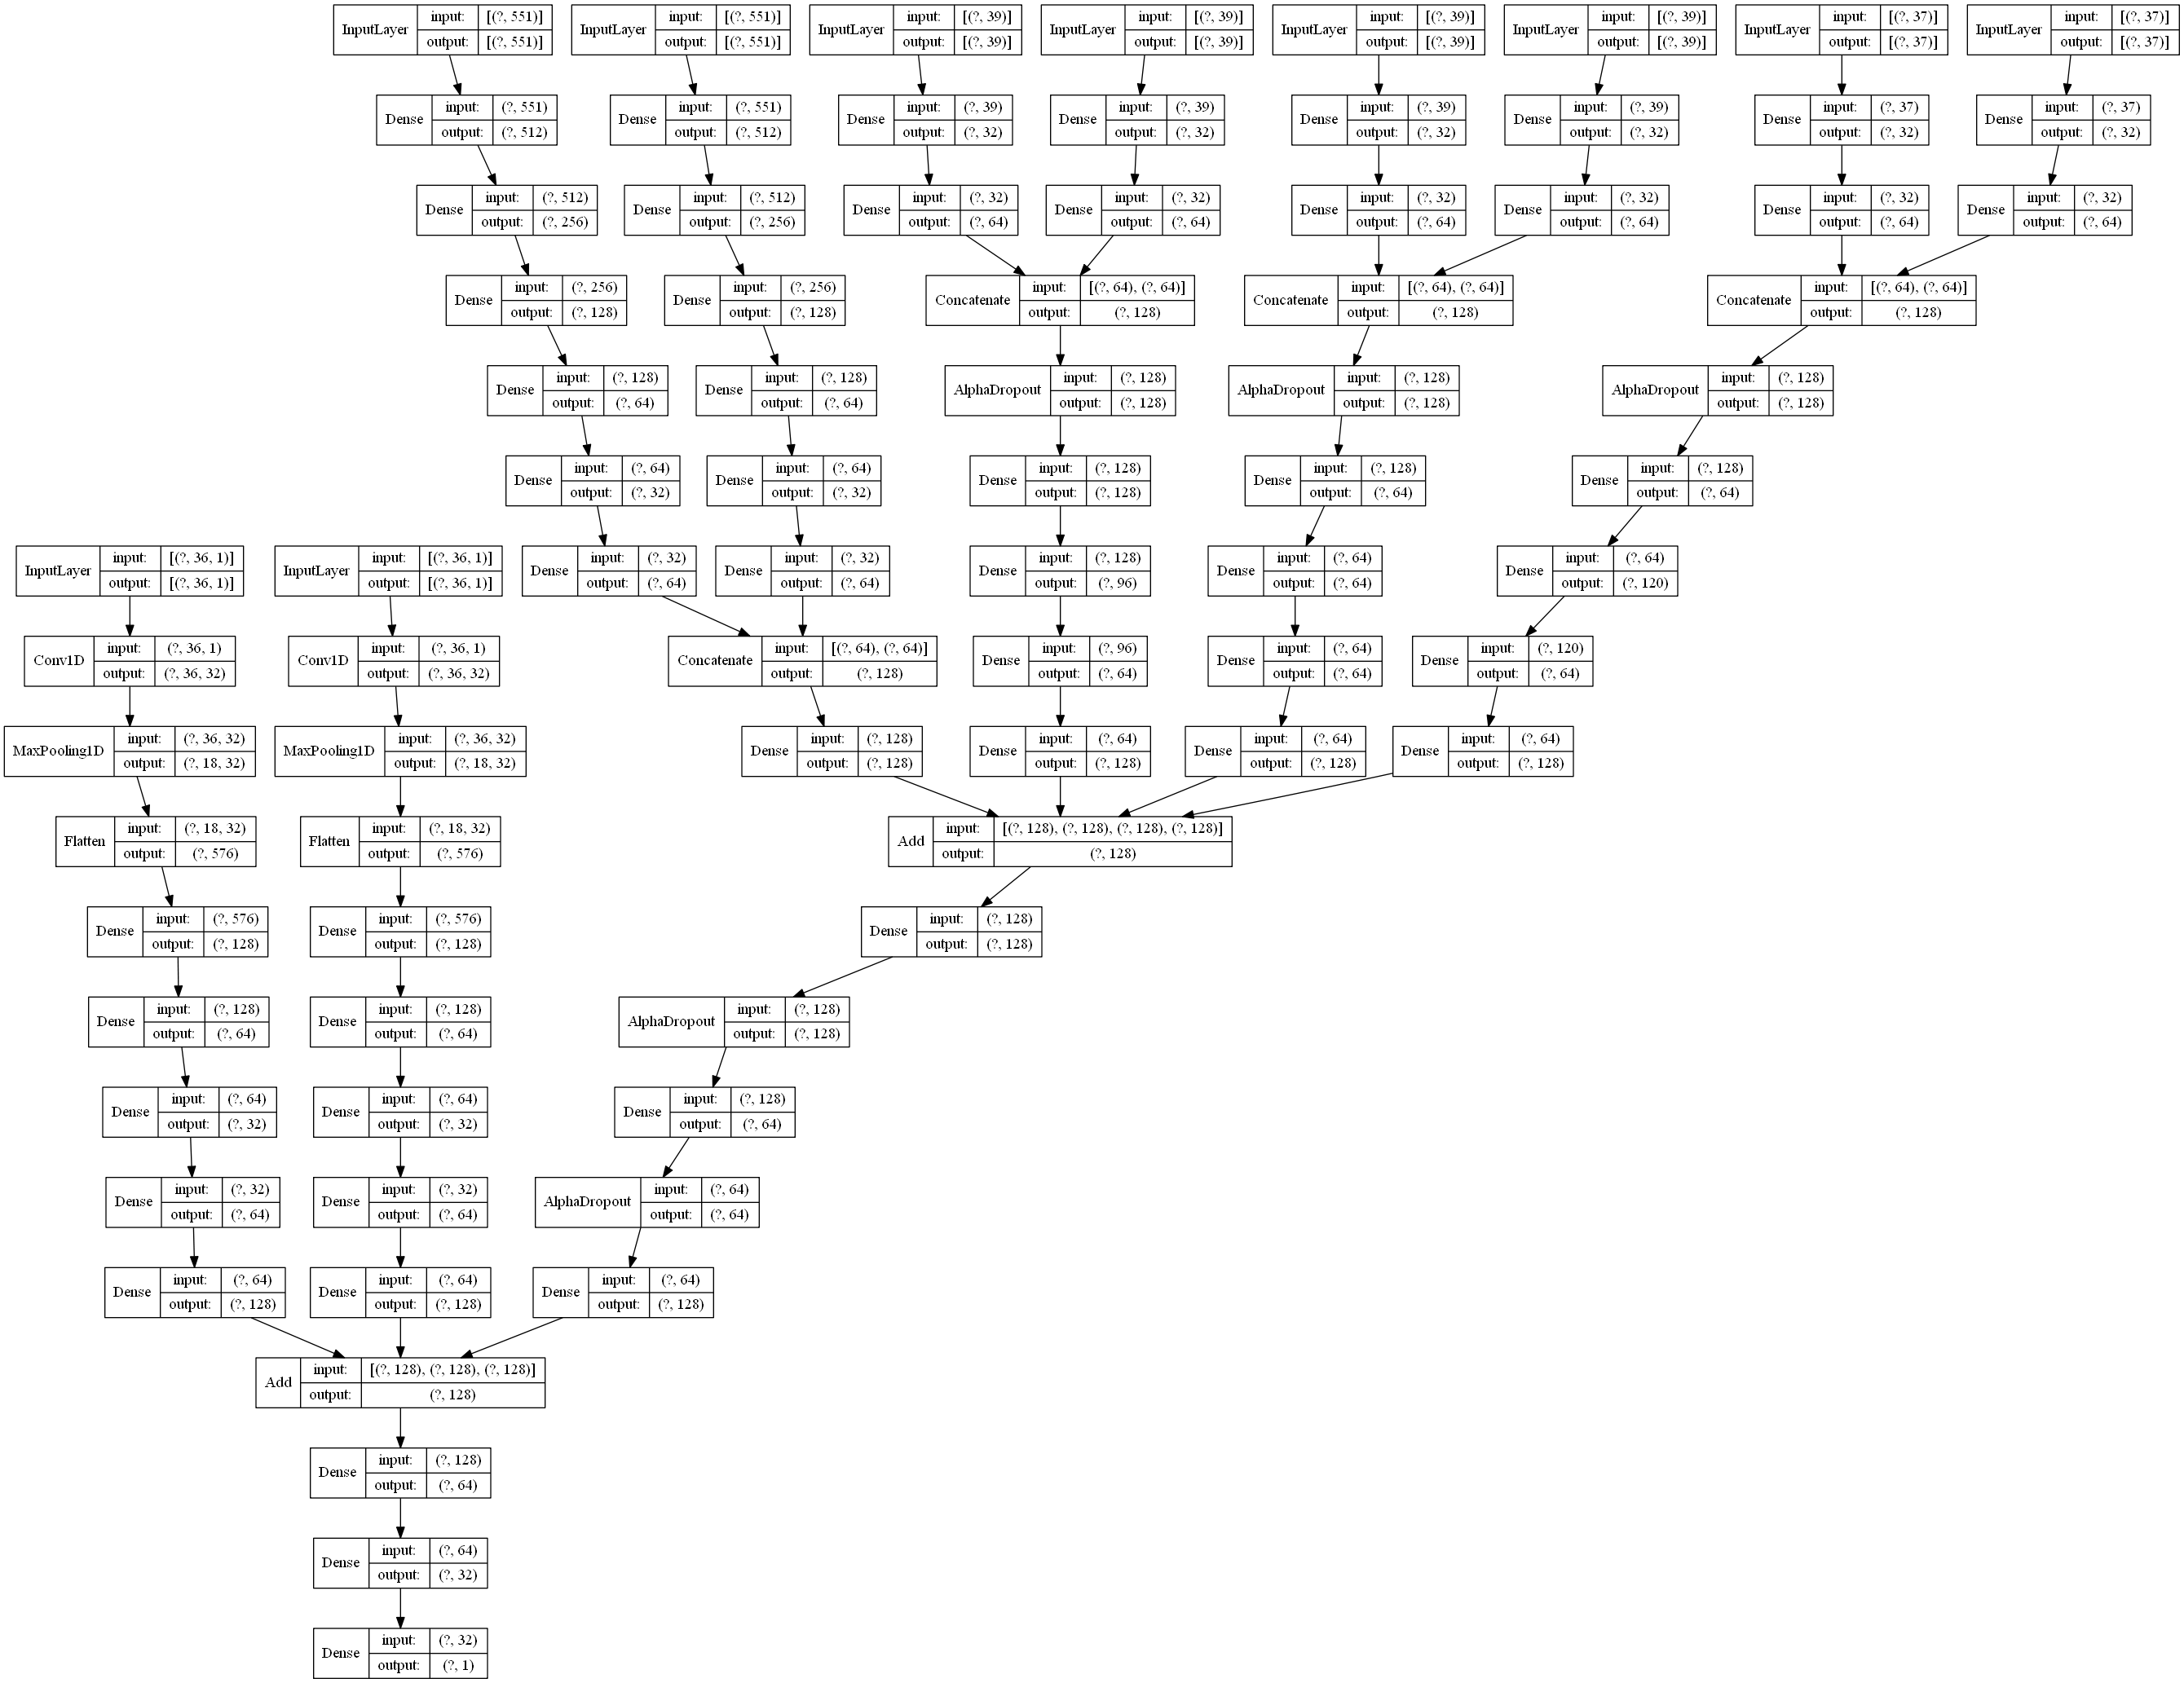

In [144]:
# model 구조 시각화
tf.keras.utils.plot_model(best_fin_model,show_shapes=True, show_layer_names=False, to_file ='victory.png')

### Target 승률 예측

In [154]:
tg=fea20WL
tgWL=tg.iloc[:,2:]

In [155]:
tg_wl1=tgWL.iloc[:,:36]
tg_wl2=tgWL.iloc[:,36:72]
tg_wl3=tgWL.iloc[:,72:623]
tg_wl4=tgWL.iloc[:,623:1174]
tg_wl5=tgWL.iloc[:,1174:1211]
tg_wl6=tgWL.iloc[:,1211:1248]
tg_wl7=tgWL.iloc[:,1248:1287]
tg_wl8=tgWL.iloc[:,1287:1326]
tg_wl9=tgWL.iloc[:,1326:1365]
tg_wl10=tgWL.iloc[:,1365:]

In [156]:
pred=best_fin_model.predict([tg_wl5,tg_wl6,tg_wl7,tg_wl8,tg_wl9,tg_wl10,tg_wl3,tg_wl4,tg_wl1,tg_wl2])

In [168]:
tg['other'] = tg.G_ID.apply(lambda x: x[10:12]) # 팀코드

In [169]:
a = fea20WL.reset_index()
a['팀코드'] = a['index'].apply(lambda x : fea20WL['other'][x])
a['상대팀코드'] = a['index'].apply(lambda x : fea20WL['T_ID'][x])
team_code = a['팀코드']
away_code = a['상대팀코드']

result1 = pd.DataFrame({'팀코드': team_code, '승률': pred.flatten()})
result2 = pd.DataFrame({'팀코드': away_code, '승률': 1-pred.flatten()})
result3 = pd.concat([result1, result2], axis=0)
result = result3.groupby('팀코드')['승률'].agg([('승률',np.mean)]).reset_index().sort_values(by='승률', ascending=False)
result.to_csv('averaging_승률.csv', encoding='cp949', index=False)

### 결과

In [170]:
result

,팀코드,승률
5,NC,0.538252
2,KT,0.532247
7,SK,0.525018
9,WO,0.510091
3,LG,0.507932
6,OB,0.499419
4,LT,0.483197
8,SS,0.481623
0,HH,0.475911
1,HT,0.453340


## 방어율 예측

방어율 예측은 2016~2018년을 Train으로, 2019년 데이터를 Validation으로 활용한다.

In [21]:
feaera=pd.read_csv('ERA_train_x.csv',encoding='cp949')
feaera20=pd.read_csv('ERA_test_x.csv',encoding='cp949')
y_train_pp=pd.read_csv('ERA_train_y.csv',encoding='cp949')

In [22]:
# G_ID,T_ID 제외
pitx = feaera.iloc[:,2:] # Train:2016~2018 Validation:2019 
pity = y_train_pp['pit_prob']

### Multi Input
- 각 피쳐의 특성을 극대화하기 위해 train set을 6개의 feature set으로  나누어 Multi-input 모델을 구축하였다.

In [23]:
tr_fx=pitx.iloc[:2400,:18]
tr_sx=pitx.iloc[:2400,18:36]
tr_tx=pitx.iloc[:2400,36:177]
tr_fox=pitx.iloc[:2400,177:213]
tr_fix=pitx.iloc[:2400,213:252]
tr_six=pitx.iloc[:2400,252:]
#Validation
ts_fx=pitx.iloc[2400:,:18]
ts_sx=pitx.iloc[2400:,18:36]
ts_tx=pitx.iloc[2400:,36:177]
ts_fox=pitx.iloc[2400:,177:213]
ts_fix=pitx.iloc[2400:,213:252]
ts_six=pitx.iloc[2400:,252:]

**하이퍼옵티마이저를 이용하여 파라미터 튜닝을 하였다.**

In [24]:
#하이퍼옵티마이저
pit_space = hp.choice('model',[
    {
        'units':hp.quniform('units',16,48,4),
        'units1':hp.quniform('units1',64,128,4),
        'units2':hp.quniform('units2',32,128,4),
        'units3':hp.quniform('units3',64,128,4),
        #'activation':hp.choice('activation',['relu','elu','selu']),
        'batchsize':random.randint(32,128),
        'dropout':random.uniform(0,0.5),
        'conv':random.randint(1,3),
        #'maxp':random.randint(1,5),
    }
])

### 모델 구축
- BOW 피쳐는 PCA된 결과이므로 CNN을 이용하여 모델링
- 방어율은 각 경기 별 평균 이닝이 9이닝이라 가정하고 단순히 방어율만 예측하여 경기별로 평균하였다.
- CNN층에 신경망 연결 가중치 규제(L1_L2 regularization)을 주어 과적합을 방지하였다.

In [25]:
def pitmodel(h):
    pitinput1=Input(shape=(tr_fx.shape[1],1))
    pitcnn1=layers.Conv1D(16,2,activation="relu",padding='same',kernel_regularizer=l1_l2(0.002))(pitinput1)
    maxpool1=layers.MaxPooling1D(2)(pitcnn1)
    flatten1=layers.Flatten()(maxpool1)
    pitdense1=layers.Dense(64,activation='relu')(flatten1)
    pitdense1=layers.Dense(43,activation='relu')(pitdense1)

    pitinput2=Input(shape=(tr_sx.shape[1],1))
    pitcnn2=layers.Conv1D(16,2,activation="relu",padding='same',kernel_regularizer=l1_l2(0.002))(pitinput2)
    maxpool2=layers.MaxPooling1D(2)(pitcnn2)
    flatten2=layers.Flatten()(maxpool2)
    pitdense2=layers.Dense(64,activation='relu')(flatten2)
    pitdense2=layers.Dense(43,activation='relu')(pitdense2)

    Add1=layers.Add()([pitdense1,pitdense2])
    Add1=layers.Dense(64,activation='relu')(Add1)
    Add1=layers.Dense(h['units1'],activation='relu')(Add1)
    Add1=layers.Dense(32,activation='relu')(Add1)

    pitinput3=Input(shape=(tr_tx.shape[1],1))
    pitcnn3=layers.Conv1D(64,1,activation="relu",padding='same',kernel_regularizer=l1_l2(0.002))(pitinput3)
    maxpool3=layers.MaxPooling1D(1)(pitcnn3)
    pitdense3=layers.Flatten()(maxpool3)
    pitdense2=layers.AlphaDropout(0.4)(pitdense3)
    pitdense3=layers.Dense(128,activation='relu')(pitdense3)
    pitdense3=layers.Dense(64,activation='relu')(pitdense3)
    pitdense3=layers.Dense(32,activation='relu')(pitdense3)

    pitinput4=Input(shape=(tr_fox.shape[1],))
    pitdense4=layers.Dense(32,activation='relu')(pitinput4)

    pitinput5=Input(shape=(tr_fix.shape[1],))
    pitdense5=layers.Dense(32,activation='relu')(pitinput5)

    pitinput6=Input(shape=(tr_six.shape[1],))
    pitdense6=layers.Dense(32,activation='relu')(pitinput6)

    Add2=layers.Concatenate()([Add1,pitdense3,pitdense4,pitdense5,pitdense6])
    pitdense=layers.Dense(128,activation='selu')(Add2)
    pitdense=layers.AlphaDropout(h['dropout'])(pitdense)
    pitdense=layers.Dense(64,activation='selu')(pitdense)
    pitdense=layers.Dense(h['units'],activation='selu')(pitdense)
    pitoutput=layers.Dense(1,activation='selu')(pitdense)

    stacked_pitae=Model([pitinput1,pitinput2,pitinput3,pitinput4,pitinput5,pitinput6],pitoutput)
    
    stacked_pitae.compile(optimizer=RMSprop(),loss='mse',metrics=['mae'])
    
    mc = tf.keras.callbacks.ModelCheckpoint('pit_Model.th',monitor='val_mae',save_best_only=True)
    es = tf.keras.callbacks.EarlyStopping(monitor='val_mae',patience=3)
    
    stacked_pitae.fit([tr_fx,tr_sx,tr_tx,tr_fox,tr_fix,tr_six],pity[:2400],epochs=10,batch_size=h['batchsize'],validation_split=0.2,callbacks=[es,mc],verbose=0)
    
    pit_Model = load_model('pit_Model.th')
    
    loss,mae=pit_Model.evaluate([ts_fx,ts_sx,ts_tx,ts_fox,ts_fix,ts_six],pity[2400:],verbose=0)
    
    filename = 'p'+str(uuid.uuid4())
    
    pit_Model.save(filename)

    return {
        'loss':loss,'mae':mae,
        'status':STATUS_OK,
        'filename':filename
    }

In [26]:
trialpit=Trials()

fmin(
    pitmodel,
    space=pit_space,
    algo=tpe.suggest,
    max_evals=10,
    trials=trialpit)

  0%|                                                                           | 0/10 [00:00<?, ?trial/s, best loss=?]INFO:tensorflow:Assets written to: pit_Model.th\assets
INFO:tensorflow:Assets written to: paba7165d-b98b-407b-8a4d-1c79878e4120\assets
 10%|████▉                                            | 1/10 [00:23<03:30, 23.38s/trial, best loss: 15.564151763916016]INFO:tensorflow:Assets written to: pit_Model.th\assets
INFO:tensorflow:Assets written to: p6ffab3fa-508d-4c8b-81c5-c855eb299dfb\assets
 20%|█████████▊                                       | 2/10 [00:42<02:56, 22.03s/trial, best loss: 12.700583457946777]INFO:tensorflow:Assets written to: pit_Model.th\assets
INFO:tensorflow:Assets written to: pit_Model.th\assets
INFO:tensorflow:Assets written to: pit_Model.th\assets
INFO:tensorflow:Assets written to: p0fe7efb7-99b7-41fc-8024-b6fe0eb5dc85\assets
 30%|██████████████▋                                  | 3/10 [01:13<02:54, 24.89s/trial, best loss: 12.700583457946777]INFO:tens

{'model': 0, 'units': 24.0, 'units1': 68.0, 'units2': 120.0, 'units3': 100.0}

In [27]:
trialpit.best_trial

{'state': 2,
 'tid': 3,
 'spec': None,
 'result': {'loss': 11.274857521057129,
  'mae': 2.7337992191314697,
  'status': 'ok',
  'filename': 'p16fedda6-9e20-43fd-9736-ac6d0a64a199'},
 'misc': {'tid': 3,
  'cmd': ('domain_attachment', 'FMinIter_Domain'),
  'workdir': None,
  'idxs': {'model': [3],
   'units': [3],
   'units1': [3],
   'units2': [3],
   'units3': [3]},
  'vals': {'model': [0],
   'units': [24.0],
   'units1': [68.0],
   'units2': [120.0],
   'units3': [100.0]}},
 'exp_key': None,
 'owner': None,
 'version': 0,
 'book_time': datetime.datetime(2020, 9, 28, 4, 42, 24, 87000),
 'refresh_time': datetime.datetime(2020, 9, 28, 4, 42, 50, 343000)}

In [29]:
best_pit_model = tf.keras.models.load_model(trialpit.best_trial['result']['filename'])

In [30]:
best_pit_model.save('best_pit_Model2009272.tf')#가장 잘나온 모델 저장

INFO:tensorflow:Assets written to: best_pit_Model2009272.tf\assets


In [31]:
best_pit_model=tf.keras.models.load_model('best_pit_model2009272.tf')

In [32]:
best_pit_model.summary()

Model: "model_33"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_319 (InputLayer)          [(None, 18, 1)]      0                                            
__________________________________________________________________________________________________
input_320 (InputLayer)          [(None, 18, 1)]      0                                            
__________________________________________________________________________________________________
conv1d_69 (Conv1D)              (None, 18, 16)       48          input_319[0][0]                  
__________________________________________________________________________________________________
conv1d_70 (Conv1D)              (None, 18, 16)       48          input_320[0][0]                  
___________________________________________________________________________________________

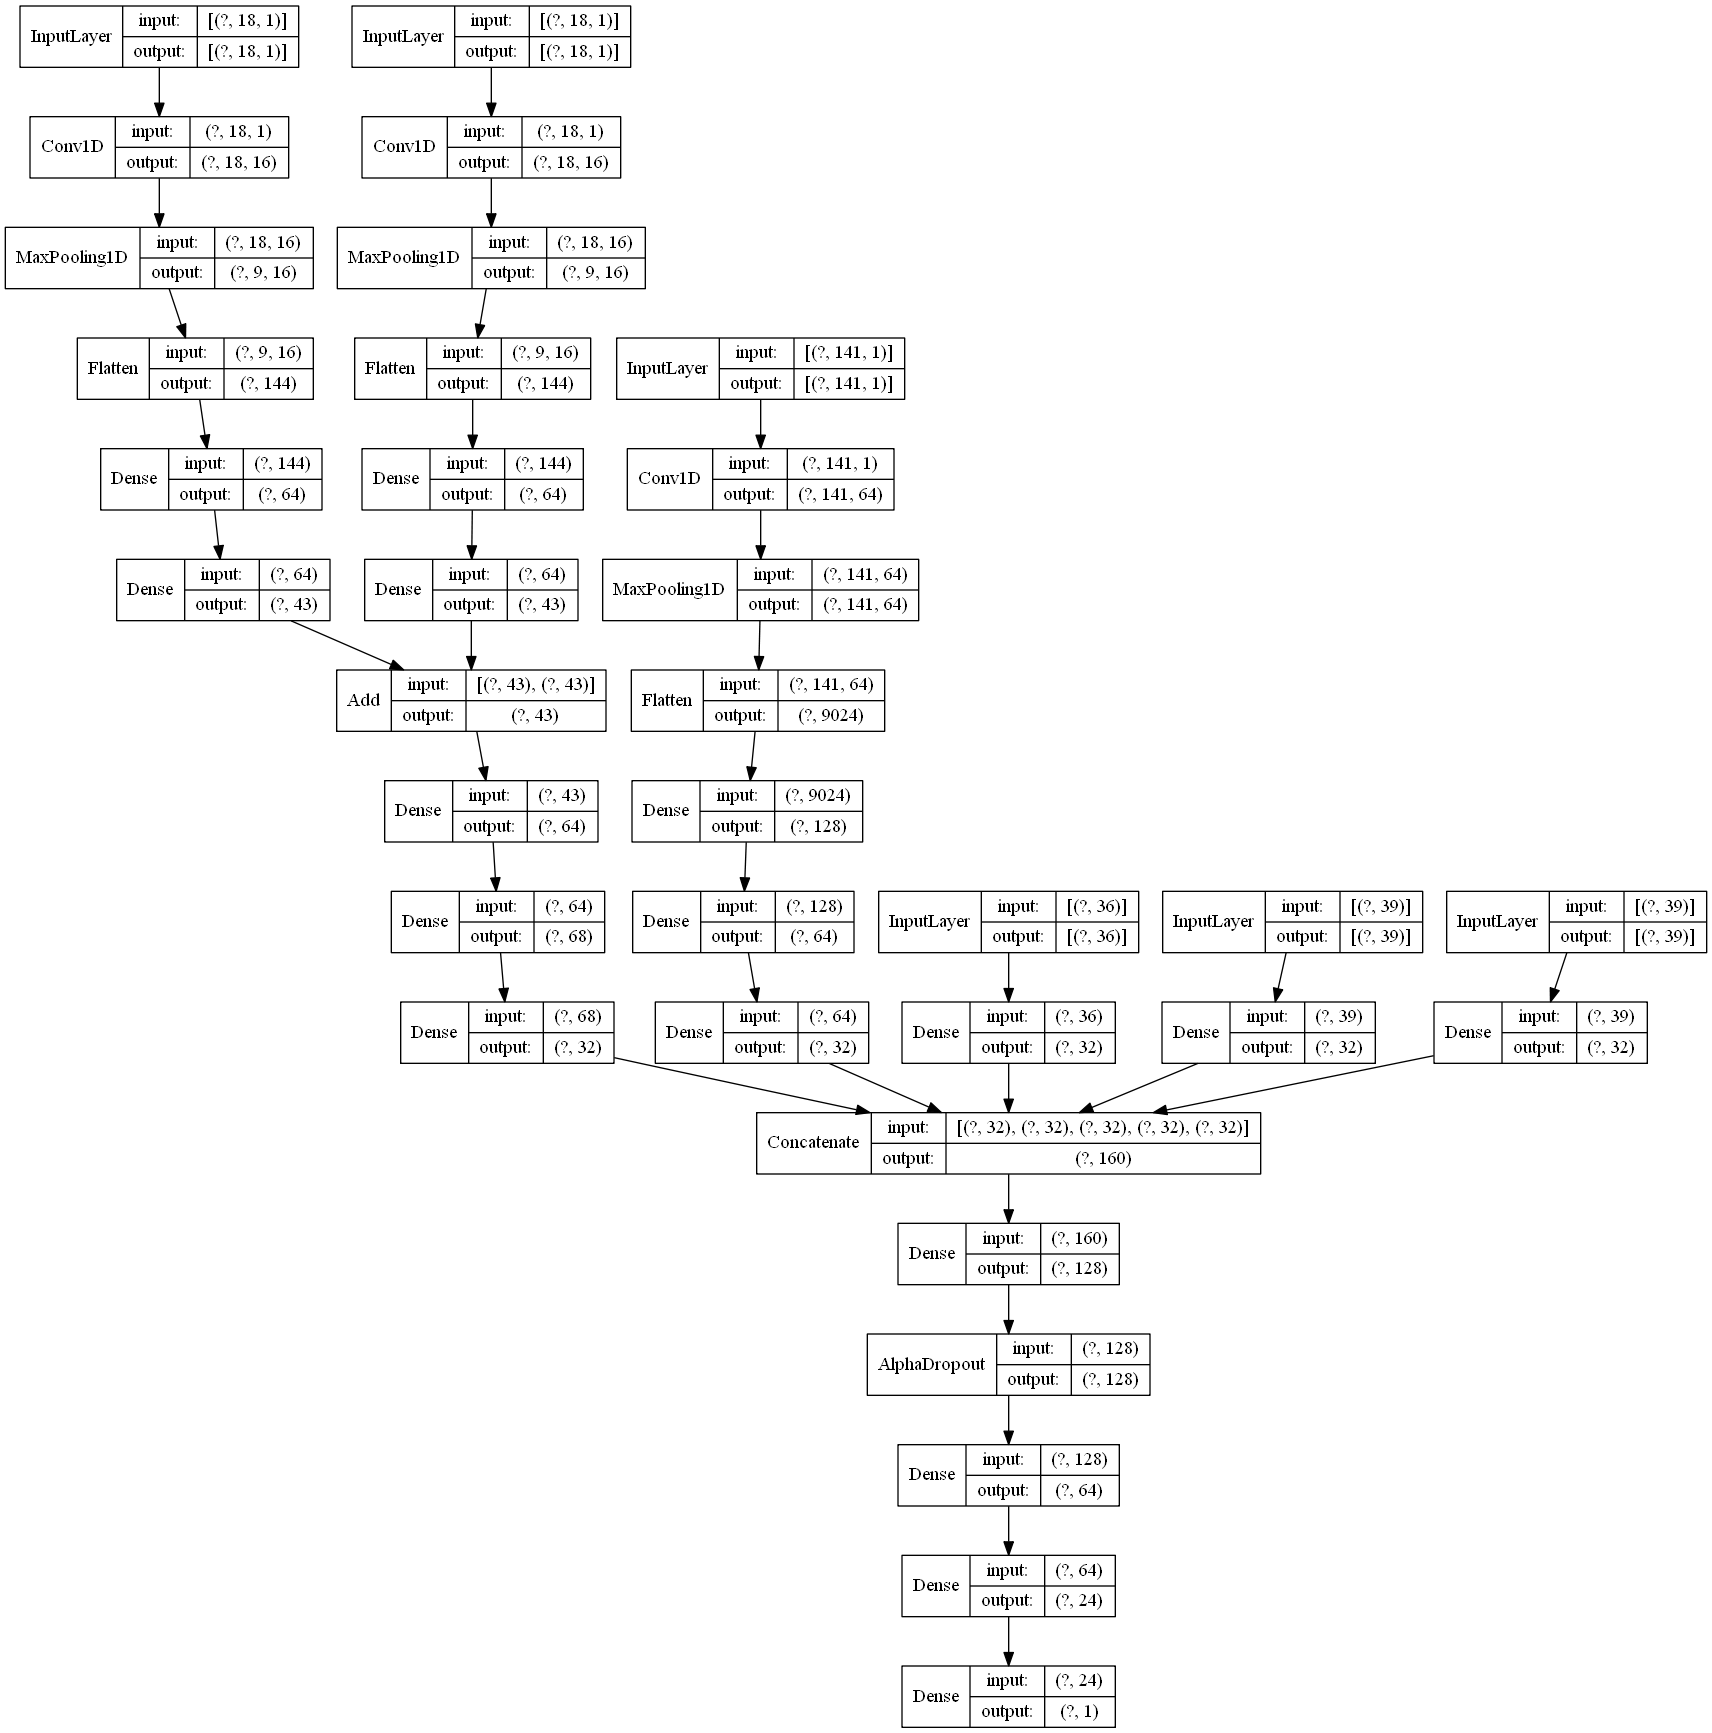

In [33]:
# model 구조 시각화
tf.keras.utils.plot_model(best_pit_model,show_shapes=True, show_layer_names=False, to_file ='pit.png')

### Target ERA예측

In [88]:
best_pit_model = tf.keras.models.load_model(trialpit.best_trial['result']['filename'])

In [89]:
tg= feaera20
tgERA=tg.iloc[:,2:]

In [90]:
tg_fx=tgERA.iloc[:,:18]
tg_sx=tgERA.iloc[:,18:36]
tg_tx=tgERA.iloc[:,36:177]
tg_fox=tgERA.iloc[:,177:213]
tg_fix=tgERA.iloc[:,213:252]
tg_six=tgERA.iloc[:,252:]

In [91]:
pred=best_pit_model.predict([tg_fx,tg_sx,tg_tx,tg_fox,tg_fix,tg_six])

In [93]:
a = feaera20.reset_index()
a['팀코드'] = a['index'].apply(lambda x : feaera20['T_ID'][x])
team_code = a['팀코드']

result = pd.DataFrame({'팀코드': team_code, '방어율': pred.flatten()})
result.groupby('팀코드')['방어율'].agg([('방어율',np.mean)]).reset_index().to_csv('hit_prob.csv', index=False)

## 타율 예측

In [77]:
feaavg=pd.read_csv('AVG_train_x.csv',encoding='cp949')
feaavg20=pd.read_csv('AVG_test_x.csv',encoding='cp949')
y_train_hp=pd.read_csv('AVG_train_y.csv',encoding='cp949')

In [78]:
# G_ID,T_ID 제외
hitx = feaavg.iloc[:,2:] # 2016~2019 
hity = y_train_hp['hit_prob']

### Multi Input
- 각 피쳐의 특성을 극대화하기 위해 train set을 6개의 feature set으로  나누어 Multi-input 모델을 구축


In [45]:
tr_1hitx=hitx.iloc[:2400,:18]
tr_2hitx=hitx.iloc[:2400,18:36]
tr_3hitx=hitx.iloc[:2400,36:447]
tr_4hitx=hitx.iloc[:2400,447:484]
tr_5hitx=hitx.iloc[:2400,484:523]
tr_6hitx=hitx.iloc[:2400,523:]
ts_1hitx=hitx.iloc[2400:,:18]
ts_2hitx=hitx.iloc[2400:,18:36]
ts_3hitx=hitx.iloc[2400:,36:447]
ts_4hitx=hitx.iloc[2400:,447:484]
ts_5hitx=hitx.iloc[2400:,484:523]
ts_6hitx=hitx.iloc[2400:,523:]

In [50]:
hity1=pd.concat([hit_t16[-800:]['안타'],hit_t17[-800:]['안타'],hit_t18[-800:]['안타']],axis=0).reset_index(drop=True)
hity2=pd.concat([hit_t16[-800:]['타수'],hit_t17[-800:]['타수'],hit_t18[-800:]['타수']],axis=0).reset_index(drop=True)

In [51]:
#하이퍼옵티마이저
hit_space = hp.choice('model',[
    {
        'units':hp.quniform('units',16,48,8),
        'units1':hp.quniform('units1',64,128,4),
        'units2':hp.quniform('units2',16,64,4),
        'units3':hp.quniform('units3',32,128,8),
        'activation':hp.choice('activation',['relu','elu','selu']),
        'batchsize':random.randint(32,128),
        'dropout':random.uniform(0,0.5),
        'conv':random.randint(1,5),
        'maxp':random.randint(1,5),
    }
])

### 모델구축
- 타율은 안타/타수 이므로 안타와 타수를 2가지를 예측하는 Multi-output 모델을 구축하였다.
- BOW 피쳐는 PCA된 결과이므로 CNN을 이용하여 모델링
- CNN층에 신경망 연결 가중치 규제(L1_L2 regularization)을 주어 과적합을 방지하였다.

In [52]:


def hitmodel(h):
    hitinput1=Input(shape=(tr_1hitx.shape[1],1))
    hitcnn1=layers.Conv1D(32,2,activation="relu",padding='same')(hitinput1)
    maxpool1=layers.MaxPooling1D(2)(hitcnn1)
    flatten1=layers.Flatten()(maxpool1)

    hitinput2=Input(shape=(tr_2hitx.shape[1],1))
    hitcnn2=layers.Conv1D(32,2,activation="relu",padding='same')(hitinput2)
    maxpool2=layers.MaxPooling1D(2)(hitcnn2)
    flatten2=layers.Flatten()(maxpool2)

    Add1=layers.Concatenate()([flatten1,flatten2])
    Add1=layers.Dense(128,activation='relu')(Add1)
    Add1=layers.Dense(h['units2'],activation='relu')(Add1)
    Add1=layers.Dense(32,activation='relu')(Add1)
    Add1=layers.Dense(64,activation='relu')(Add1)

    hitinput3=Input(shape=(tr_3hitx.shape[1],1))
    hitcnn3=layers.Conv1D(64,1,activation="relu",padding='same')(hitinput3)
    maxpool3=layers.MaxPooling1D(2)(hitcnn3)
    hitdense3=layers.Flatten()(maxpool3)
    hitdense3=layers.Dense(128,activation='selu')(hitdense3)
    hitdense3=layers.Dense(h['units1'],activation='selu')(hitdense3)
    hitdense3=layers.Dense(32,activation='selu')(hitdense3)
    hitdense3=layers.Dense(64,activation='selu')(hitdense3)

    hitinput4=Input(shape=(tr_4hitx.shape[1],))
    hitdense4=layers.Dense(32,activation='selu')(hitinput4)
    hitdense4=layers.Dense(64,activation='selu')(hitinput4)

    hitinput5=Input(shape=(tr_5hitx.shape[1],))
    hitdense5=layers.Dense(32,activation='selu')(hitinput5)
    hitdense5=layers.Dense(64,activation='selu')(hitinput5)

    hitinput6=Input(shape=(tr_6hitx.shape[1],))
    hitdense6=layers.Dense(32,activation='selu')(hitinput6)
    hitdense6=layers.Dense(64,activation='selu')(hitinput6)

    Add2=layers.Concatenate()([Add1,hitdense3,hitdense4,hitdense5,hitdense6])
    hitdense2=layers.Dense(64,activation='selu')(Add2)
    hitdense2=layers.Dense(128,activation='selu')(hitdense2)
    hitdense2=layers.Dense(256,activation='selu')(hitdense2)
    hitdense2=layers.Dropout(h['dropout'])(hitdense2)
    hitdense2=layers.Dense(128,activation='selu')(hitdense2)
    hitdense2=layers.Dense(h['units'],activation='selu')(hitdense2)
    hitoutput1=layers.Dense(1,activation='selu',name='hitoutput1')(hitdense2)
    
    hitdense2=layers.Dense(64,activation='selu')(Add2)
    hitdense2=layers.Dense(128,activation='selu')(hitdense2)
    hitdense2=layers.Dense(64,activation='selu')(hitdense2)
    hitdense2=layers.Dropout(h['dropout'])(hitdense2)
    hitdense2=layers.Dense(128,activation='selu')(hitdense2)
    hitdense2=layers.Dense(h['units'],activation='selu')(hitdense2)
    hitoutput2=layers.Dense(1,activation='relu',name='hitoutput2')(hitdense2)


    stacked_hitae=Model([hitinput1,hitinput2,hitinput3,hitinput4,hitinput5,hitinput6],outputs=[hitoutput1,hitoutput2])

    stacked_hitae.compile(optimizer='Rmsprop',loss={'hitoutput1':MeanSquaredError(),
                                                    'hitoutput2':MeanSquaredError()},
                          metrics={'hitoutput1':[MeanAbsoluteError()],
                                   'hitoutput2':[MeanAbsoluteError()]},
                         loss_weights={'hitoutput1': 2., 'hitoutput2': 1.})

    mc = tf.keras.callbacks.ModelCheckpoint('hit_Model.hdf5',monitor='val_hitoutput1_mean_absolute_error',save_best_only=True)
    es = tf.keras.callbacks.EarlyStopping(monitor='val_hitoutput1_mean_absolute_error',patience=3)
    
    stacked_hitae.fit([tr_1hitx,tr_2hitx,tr_3hitx,tr_4hitx,tr_5hitx,tr_6hitx],[hity1,hity2],epochs=10,batch_size=h['batchsize'],validation_split=0.2,callbacks=[es,mc],verbose=0)
    
    hit_Model = load_model('hit_Model.hdf5',compile=False)
    
    hit_Model.compile(optimizer='Rmsprop',loss={'hitoutput1':MeanSquaredError(),
                                                    'hitoutput2':MeanSquaredError()},
                          metrics={'hitoutput1':[MeanAbsoluteError()],
                                   'hitoutput2':[MeanAbsoluteError()]},
                         )
    
    loss0,loss1,loss2,mae1,mae2=hit_Model.evaluate([ts_1hitx,ts_2hitx,ts_3hitx,ts_4hitx,ts_5hitx,ts_6hitx],{'hitoutput1':hit_t19[-800:]['안타'],'hitoutput2':hit_t19[-800:]['타수']},verbose=0)
    
    filename = 'h'+str(uuid.uuid4())+'.hdf5'

    hit_Model.save(filename)

    return {
        'loss':loss0,'loss1':loss1,'loss2':loss2,'mae1':mae1,'mae2':mae2,
        'status':STATUS_OK,
        'filename':filename
    }

In [53]:
trialhit=Trials()

fmin(
    hitmodel,
    space=hit_space,
    algo=tpe.suggest,
    max_evals=30,
    trials=trialhit)

100%|████████████████████████████████████████████████| 30/30 [05:37<00:00, 11.24s/trial, best loss: 28.704814910888672]


{'activation': 0,
 'model': 0,
 'units': 32.0,
 'units1': 100.0,
 'units2': 60.0,
 'units3': 112.0}

In [54]:
trialhit.best_trial

{'state': 2,
 'tid': 5,
 'spec': None,
 'result': {'loss': 28.704814910888672,
  'loss1': 12.72962760925293,
  'loss2': 15.975189208984375,
  'mae1': 2.8373312950134277,
  'mae2': 3.0621237754821777,
  'status': 'ok',
  'filename': 'h65f4e560-58b5-4082-b2e1-ededdfba7421.hdf5'},
 'misc': {'tid': 5,
  'cmd': ('domain_attachment', 'FMinIter_Domain'),
  'workdir': None,
  'idxs': {'activation': [5],
   'model': [5],
   'units': [5],
   'units1': [5],
   'units2': [5],
   'units3': [5]},
  'vals': {'activation': [0],
   'model': [0],
   'units': [32.0],
   'units1': [100.0],
   'units2': [60.0],
   'units3': [112.0]}},
 'exp_key': None,
 'owner': None,
 'version': 0,
 'book_time': datetime.datetime(2020, 9, 28, 4, 53, 10, 610000),
 'refresh_time': datetime.datetime(2020, 9, 28, 4, 53, 20, 963000)}

In [60]:
hi=tf.keras.models.load_model('best_hit_model.hdf5',compile=False)
hi.compile(optimizer='Rmsprop',loss={'hitoutput1':MeanSquaredError(),
                                                    'hitoutput2':MeanSquaredError()},
                          metrics={'hitoutput1':[MeanAbsoluteError()],
                                   'hitoutput2':[MeanAbsoluteError()]})


In [61]:
hi.summary() #모델 개요

Model: "model_45"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_391 (InputLayer)          [(None, 18, 1)]      0                                            
__________________________________________________________________________________________________
input_392 (InputLayer)          [(None, 18, 1)]      0                                            
__________________________________________________________________________________________________
conv1d_105 (Conv1D)             (None, 18, 32)       96          input_391[0][0]                  
__________________________________________________________________________________________________
conv1d_106 (Conv1D)             (None, 18, 32)       96          input_392[0][0]                  
___________________________________________________________________________________________

### Target 타율 예측

In [79]:
tg= feaavg20
tgavg=tg.iloc[:,2:]

In [81]:
tg_1hitx=tgavg.iloc[:,:18]
tg_2hitx=tgavg.iloc[:,18:36]
tg_3hitx=tgavg.iloc[:,36:447]
tg_4hitx=tgavg.iloc[:,447:484]
tg_5hitx=tgavg.iloc[:,484:523]
tg_6hitx=tgavg.iloc[:,523:]

In [82]:
pp=hi.predict([tg_1hitx,tg_2hitx,tg_3hitx,tg_4hitx,tg_5hitx,tg_6hitx])

In [108]:
a = feaavg20.reset_index()
a['팀코드'] = a['index'].apply(lambda x : feaavg20['T_ID'][x])
team_code = a['팀코드']

result = pd.DataFrame({'팀코드': team_code, '안타': pp[0].flatten(),'타수':pp[1].flatten()})
result=result.groupby('팀코드')['안타'].agg(np.sum)/result.groupby('팀코드')['타수'].agg(np.sum)
pd.DataFrame(result).to_csv('hit_prob_result.csv',encoding='cp949')

In [109]:
result

팀코드
HH    0.255922
HT    0.257862
KT    0.271033
LG    0.253782
LT    0.263067
NC    0.258526
OB    0.264006
SK    0.258784
SS    0.261370
WO    0.268024
dtype: float32

## 앙상블 - 멱평균

In [1]:
ml_wl = pd.read_csv('승률_groupby.csv',encoding='cp949').rename(columns = {'T_ID':'팀코드'})
ml_avg = pd.read_csv('타율_groupby.csv',encoding='cp949').rename(columns = {'T_ID':'팀코드'})
ml_era = pd.read_csv('방어율_groupby.csv',encoding='cp949').rename(columns = {'T_ID':'팀코드'})

dl_wl = pd.read_csv('averaging_승률.csv',encoding='cp949')
dl_avg = pd.read_csv('hit_prob_result.csv',encoding='cp949').rename(columns = {'0':'타율'})
dl_era = pd.read_csv('pit_prob.csv')

In [2]:
#멱평균 값 설정
p = 2.56

#### 승률

In [3]:
result_wl = ml_wl.merge(dl_wl,on='팀코드')
result_wl['승률'] = ((result_wl['승률_x'] ** p + result_wl['승률_y'] ** p) / p) ** (1/p)
result_wl = result_wl[['팀코드','승률']];result_wl

,팀코드,승률
0,HH,0.481718
1,KT,0.461550
2,SK,0.442797
3,WO,0.439225
4,LG,0.429493
5,HT,0.425722
6,LT,0.415725
7,SS,0.421214
8,OB,0.403450
9,NC,0.375989


#### 타율

In [4]:
result_avg = ml_avg.merge(dl_avg,on='팀코드')
result_avg['타율'] = ((result_avg['타율_x'] ** p + result_avg['타율_y'] ** p) / p) ** (1/p)
result_avg = result_avg[['팀코드','타율']];result_avg

,팀코드,타율
0,KT,0.259490
1,OB,0.252927
2,WO,0.251196
3,LT,0.248285
4,SS,0.246237
5,LG,0.241943
6,NC,0.242396
7,HT,0.240852
8,SK,0.239077
9,HH,0.237682


#### 방어율

In [5]:
result_era = ml_era.merge(dl_era,on='팀코드')
result_era['방어율'] = ((result_era['방어율_x'] ** p + result_era['방어율_y'] ** p) / p) ** (1/p)
result_era = result_era[['팀코드','방어율']];result_era

,팀코드,방어율
0,OB,4.651598
1,HH,4.743911
2,LG,4.654278
3,SS,4.591033
4,SK,4.666991
5,HT,4.534554
6,LT,4.561607
7,KT,4.645637
8,WO,4.558936
9,NC,4.514986


## 최종 결과

In [6]:
result_wl.to_csv('승률.csv',index=False)
result_avg.to_csv('타율.csv',index=False)
result_era.to_csv('방어율.csv',index=False)